# **Predictive Analysis and Forecasting of Commodity Market Dynamics**

## **Dataset Overview**

This dataset contains synthetically generated daily commodity price data from 2015 to 2025, designed to closely mimic real-world market behavior. It includes standard financial metrics such as Open, High, Low, and Close prices, Trading Volume, and a Market Sentiment Score (ranging from -1 to 1), alongside key macroeconomic indicators like GDP Growth, Inflation, and Interest Rates. The data was sourced from Kaggle and created using a Python-based simulation that incorporates randomized price movements, volatility factors, and sentiment-driven adjustments. By reflecting realistic financial patterns and economic contexts, this dataset is well-suited for our project, which focuses on commodity price predictive analysis and time series forecasting by benchmarking various machine learning/time series models and exploring underlying market dynamics to gain deeper insights into price behavior.

[Dataset link](https://www.kaggle.com/datasets/arittrabag/synthetic-commodity-price-data-2015-2025)


## **Importing Tools**

Before diving into the data, let's begin by dedicating a cell to importing all the necessary libraries that will be used throughout the project.

In [6]:
import warnings

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

import numpy as np
import pandas as pd
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout, 
                                     Input, LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## **Explanatory Data Analysis (EDA)**

In this section we will explore the data, uncover patterns and dependencies of our features and observe their characteristics more deeply.

Firstly, let's import our dataset and look into every feature closely

In [10]:
df = pd.read_csv(r"C:\Users\user\Desktop\commodity_prices.csv")
df.head()

Date    Commodity     Open     High      Low    Close  Volume  \
0  2015-01-01         Gold   998.11   998.46   997.80   998.18   38403   
1  2015-01-01       Silver   809.49   812.67   805.96   808.97   42850   
2  2015-01-01    Crude Oil    86.13    87.94    83.44    85.05   86981   
3  2015-01-01  Natural Gas  1817.05  1817.32  1816.17  1816.25   93167   
4  2015-01-01       Copper   985.28   989.37   982.19   984.04    5090   

   Market_Sentiment  GDP_Growth  Inflation  Interest_Rates  
0             -0.61        2.25       1.12            4.05  
1              0.47        2.25       1.12            4.05  
2              0.38        2.25       1.12            4.05  
3              0.70        2.25       1.12            4.05  
4              0.07        2.25       1.12            4.05

Before we do further analysis, let's take the 3 main commodities that we will be analyzing and forecasting in this project.

In [12]:
df = df[df['Commodity'].isin(['Gold', 'Crude Oil', 'Natural Gas'])]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10962 entries, 0 to 18268
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              10962 non-null  object 
 1   Commodity         10962 non-null  object 
 2   Open              10962 non-null  float64
 3   High              10962 non-null  float64
 4   Low               10962 non-null  float64
 5   Close             10962 non-null  float64
 6   Volume            10962 non-null  int64  
 7   Market_Sentiment  10962 non-null  float64
 8   GDP_Growth        10962 non-null  float64
 9   Inflation         10962 non-null  float64
 10  Interest_Rates    10962 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 1.0+ MB


The dataset contains 18,270 rows and 11 columns. All columns have complete data with no missing values. There are 8 float columns, 1 integer column, and 2 object (text) columns, which represent dates and commodity names.









Let's firstly observe every variable separately, starting with Date column.

In [16]:
df['Date'] = pd.to_datetime(df['Date'])  
start_date = df['Date'].min().date()
end_date = df['Date'].max().date()
time_range = (df['Date'].max().date() - df['Date'].min().date()).days

print("Start date:", start_date)
print("End date:", end_date)
print("Time range:", time_range)

Start date: 2015-01-01
End date: 2025-01-01
Time range: 3653


We converted our Date column into the proper data type (datetime). Our data ranges from 2015-01-01 to 2025-01-01, which is 10 years.

Before we check time series of our commodity prices, let's analyse our economic variables first.

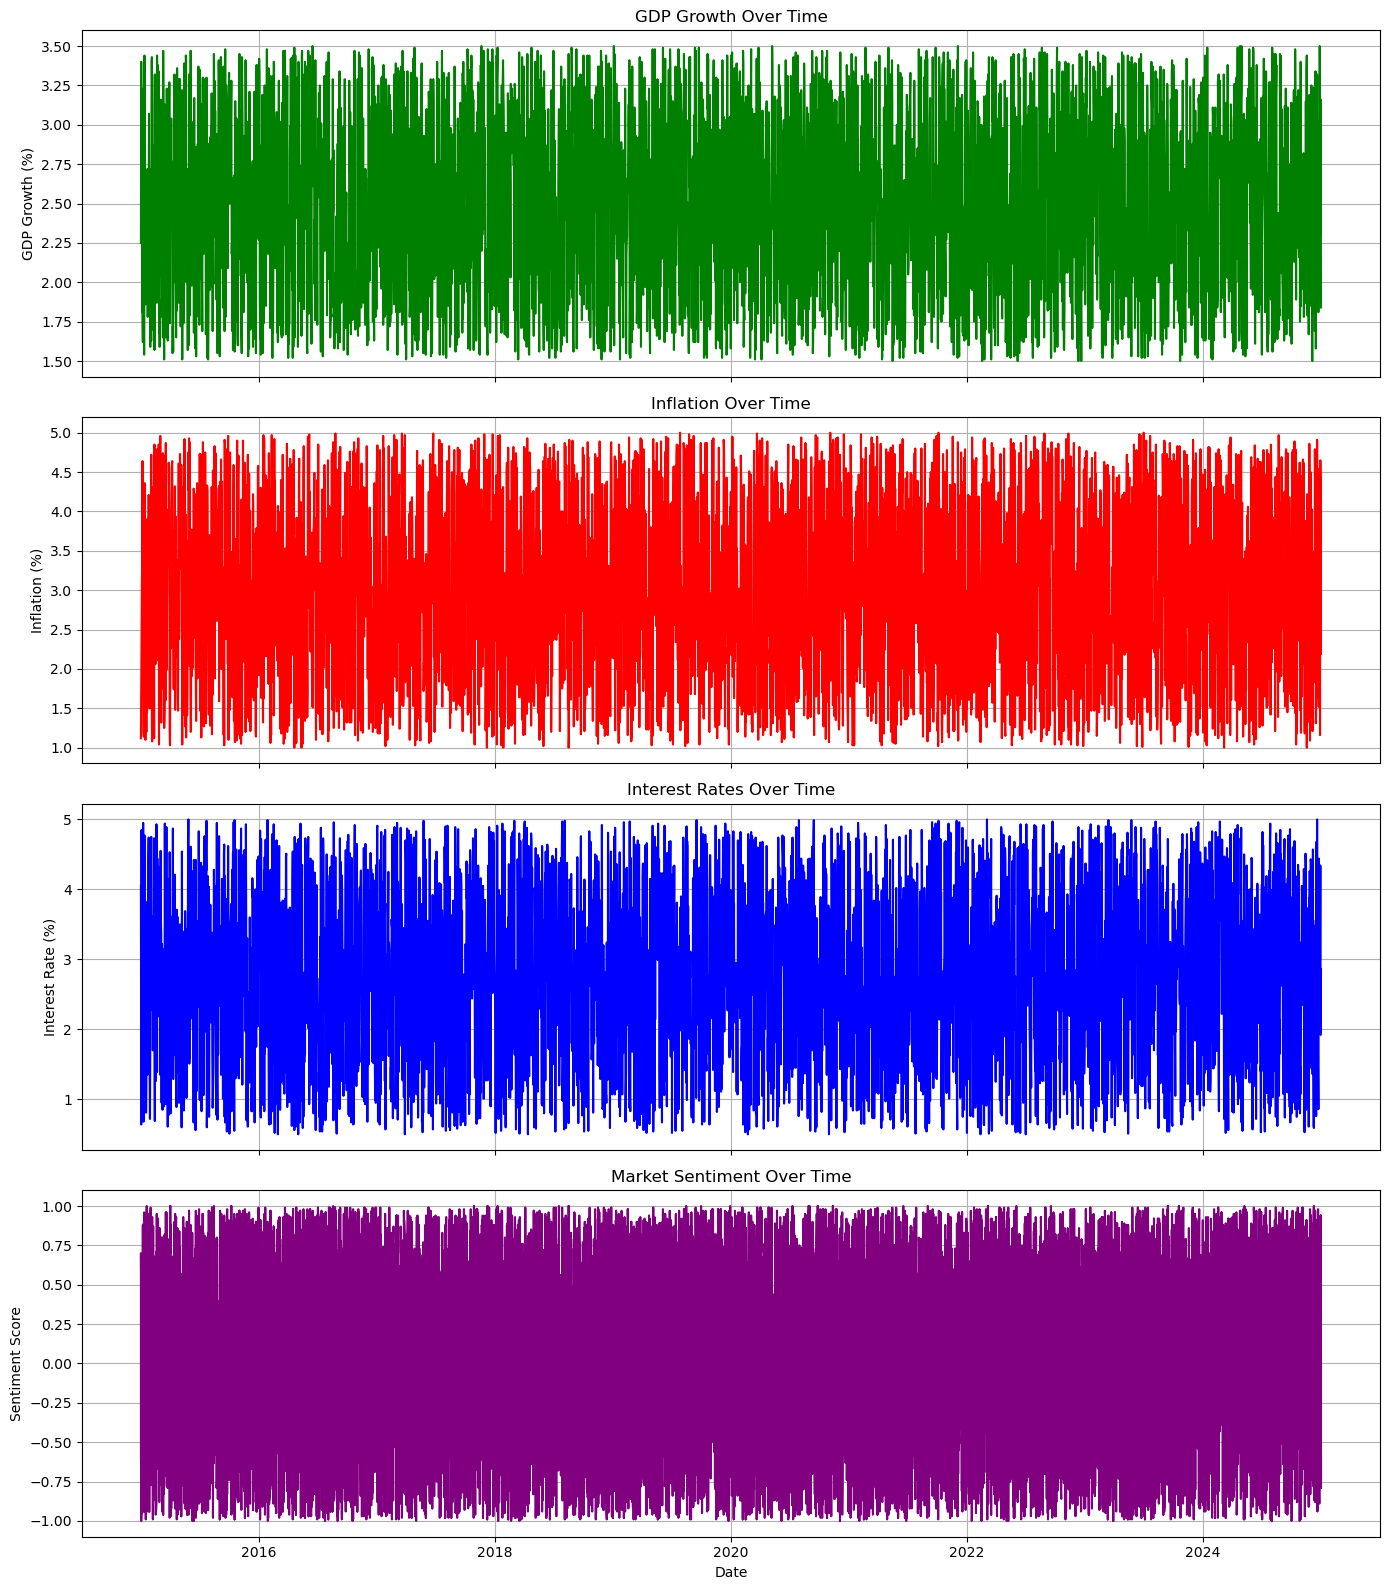

In [19]:
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

axes[0].plot(df['Date'], df['GDP_Growth'], 'g-')
axes[0].set_title('GDP Growth Over Time')
axes[0].set_ylabel('GDP Growth (%)')
axes[0].grid(True)

axes[1].plot(df['Date'], df['Inflation'], 'r-')
axes[1].set_title('Inflation Over Time')
axes[1].set_ylabel('Inflation (%)')
axes[1].grid(True)

axes[2].plot(df['Date'], df['Interest_Rates'], 'b-')
axes[2].set_title('Interest Rates Over Time')
axes[2].set_ylabel('Interest Rate (%)')
axes[2].grid(True)

axes[3].plot(df['Date'], df['Market_Sentiment'], 'purple')
axes[3].set_title('Market Sentiment Over Time')
axes[3].set_ylabel('Sentiment Score')
axes[3].set_xlabel('Date')
axes[3].grid(True)

plt.tight_layout()
plt.show()

As it turns out, our economic variables are very noisy, which is pretty expected based on our dataset's characteristics and daily intervals. Let's firstly check the monthyl aggregated version of the plots, and after I observe the Volume too, I will conduct a noise reduction to all the exogenous features together, for enhanced forecasting.

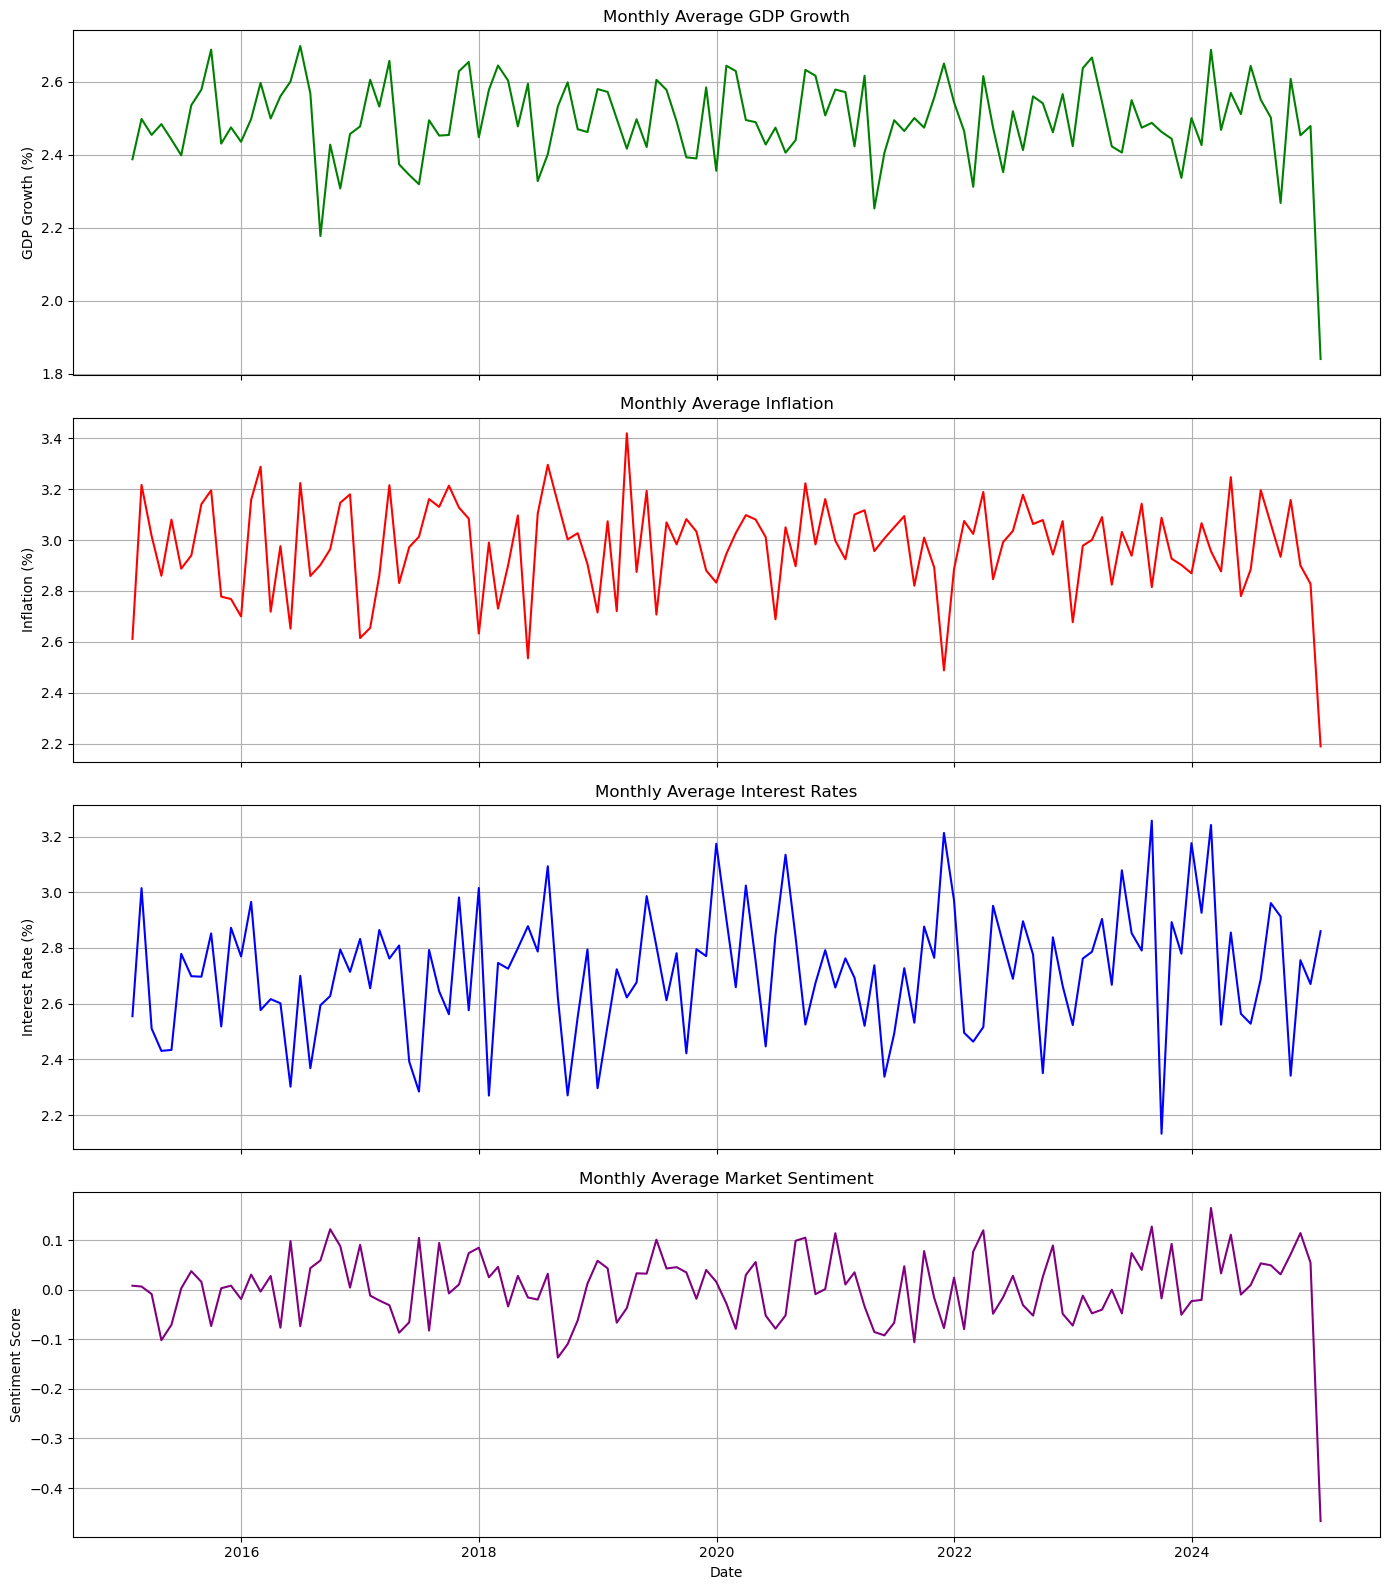

In [21]:
df_monthly = df.resample('ME', on='Date').mean(numeric_only=True)

fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

axes[0].plot(df_monthly.index, df_monthly['GDP_Growth'], 'g-')
axes[0].set_title('Monthly Average GDP Growth')
axes[0].set_ylabel('GDP Growth (%)')
axes[0].grid(True)

axes[1].plot(df_monthly.index, df_monthly['Inflation'], 'r-')
axes[1].set_title('Monthly Average Inflation')
axes[1].set_ylabel('Inflation (%)')
axes[1].grid(True)

axes[2].plot(df_monthly.index, df_monthly['Interest_Rates'], 'b-')
axes[2].set_title('Monthly Average Interest Rates')
axes[2].set_ylabel('Interest Rate (%)')
axes[2].grid(True)

axes[3].plot(df_monthly.index, df_monthly['Market_Sentiment'], 'purple')
axes[3].set_title('Monthly Average Market Sentiment')
axes[3].set_ylabel('Sentiment Score')
axes[3].set_xlabel('Date')
axes[3].grid(True)

plt.tight_layout()
plt.show()

All of our variables show remarkably high-frequency fluctuations, suggesting a volatile economic environment during our observation period. We should also mention that none of our economic variables show neither upward or downward trend, only high and rapid volatility.This information gives us some more insights for the noise reduction method selection. Let's keep inspecting economic variables.

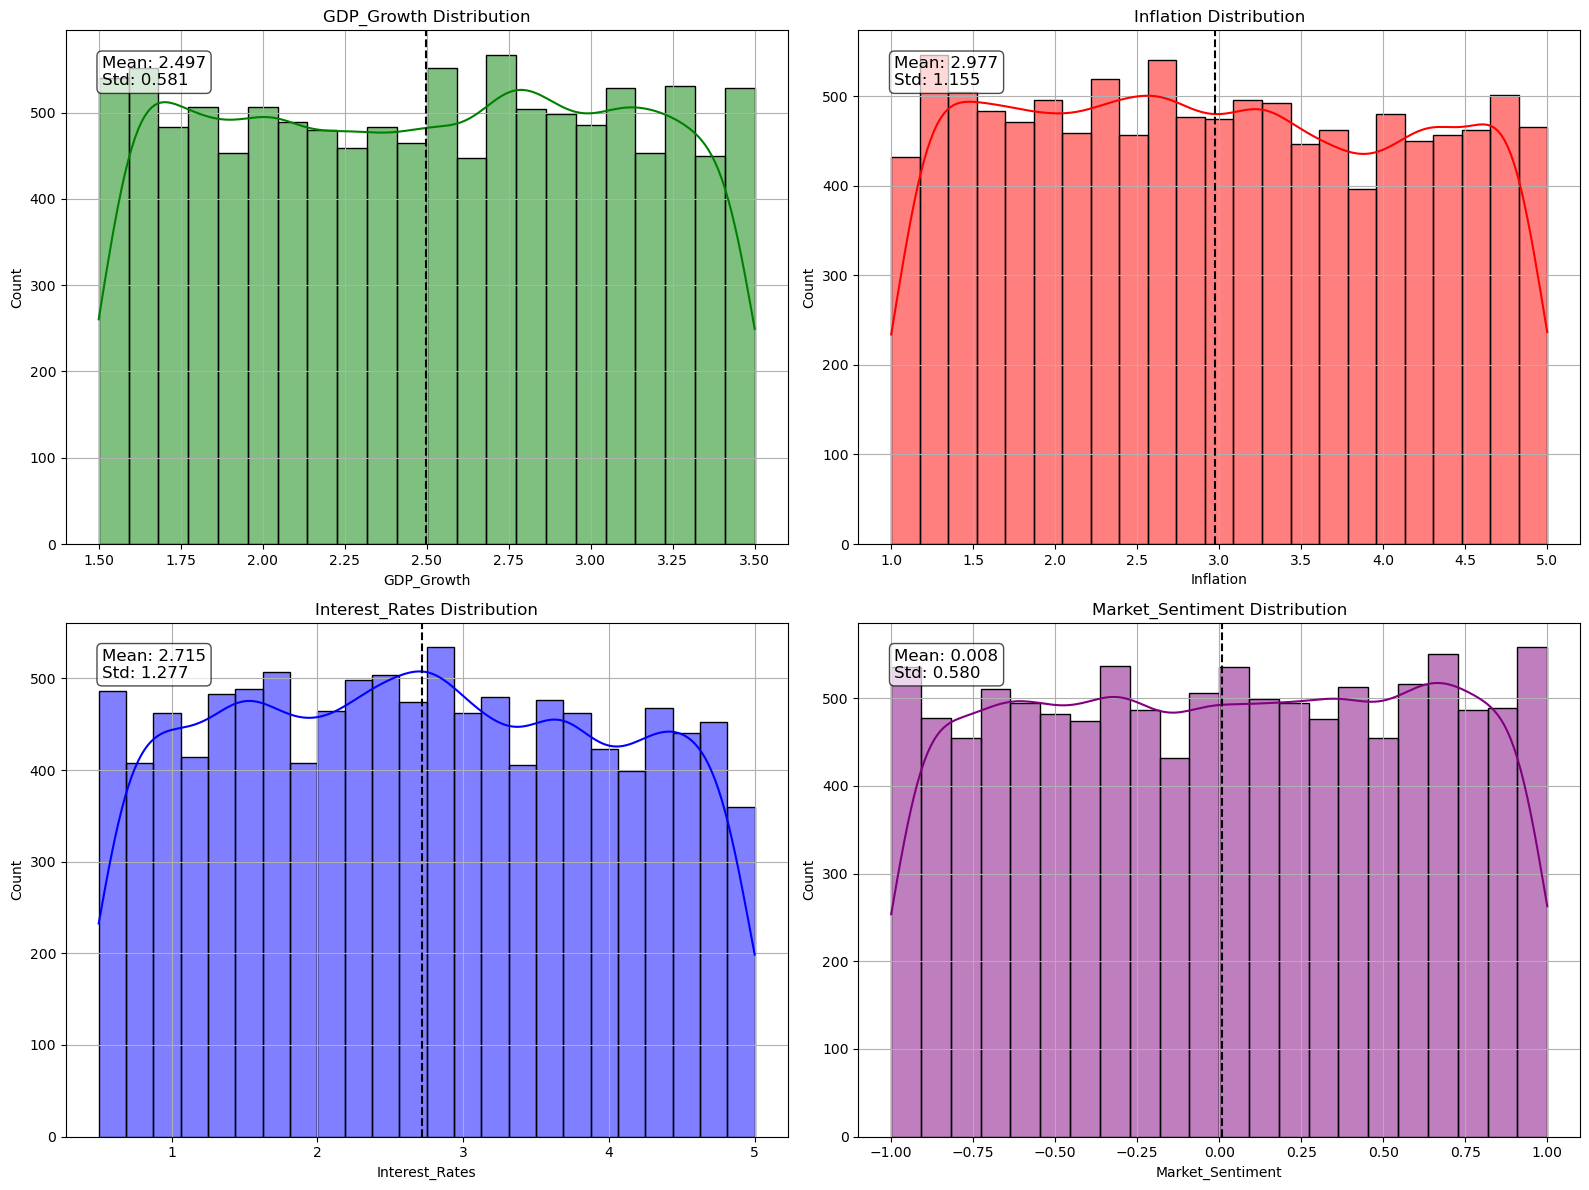

In [23]:
econ_vars = ['GDP_Growth', 'Inflation', 'Interest_Rates', 'Market_Sentiment']
colors = ['green', 'red', 'blue', 'purple']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, var in enumerate(econ_vars):
    sns.histplot(df[var], kde=True, color=colors[i], ax=axes[i])
    axes[i].set_title(f'{var} Distribution')
    axes[i].grid(True)
    
    mean = df[var].mean()
    std = df[var].std()
    axes[i].axvline(mean, color='black', linestyle='--')
    axes[i].text(0.05, 0.95, f'Mean: {mean:.3f}\nStd: {std:.3f}', 
                transform=axes[i].transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

- **GDP growth** displays a relatively uniform distribution with a mean of 2.497% and standard deviation of 0.581%. The histogram shows values predominantly ranging from 1.5% to 3.5%, with a fairly flat distribution across this range. Several small peaks appear around 1.75%, 2.0%, and 2.75%, but no single dominant mode is evident, suggesting consistent variability in growth rates.


- **Inflation** exhibits a broader distribution with a mean of 2.977% and standard deviation of 1.155%. The histogram reveals inflation values spanning from approximately 1.0% to 5.0%. The distribution shows some bimodal characteristics with peaks around 2.5-3.0% and another at 4.5-5.0%. The overall shape is flatter than a normal curve, indicating complex inflation dynamics during this period.

 
- **Interest** rates show the highest variability among the economic indicators with a mean of 2.715% and standard deviation of 1.277%. The distribution features a notable peak around 2.7-3.0%, with a broad spread of values from near 0% to 5%. This suggests periodic concentration around the central bank's target rate with significant deviations in both directions.

- **Market sentiment** presents a perfectly symmetrical distribution centered exactly at zero with a standard deviation of 0.580. Values span the complete range from -1.0 to 1.0, with a relatively uniform distribution suggesting balanced market perspectives. The equal distribution of positive and negative sentiment values indicates neither persistent optimism nor pessimism dominated this period.

Now let's investigaet Volume column, which shows the trading volume in commodity markets, total number of contracts or units of a commodity traded during that specific day. This will gives us more clues about the best method of how we can reduct the noise in our exogenous variables, and if Volume is suitable for that process.

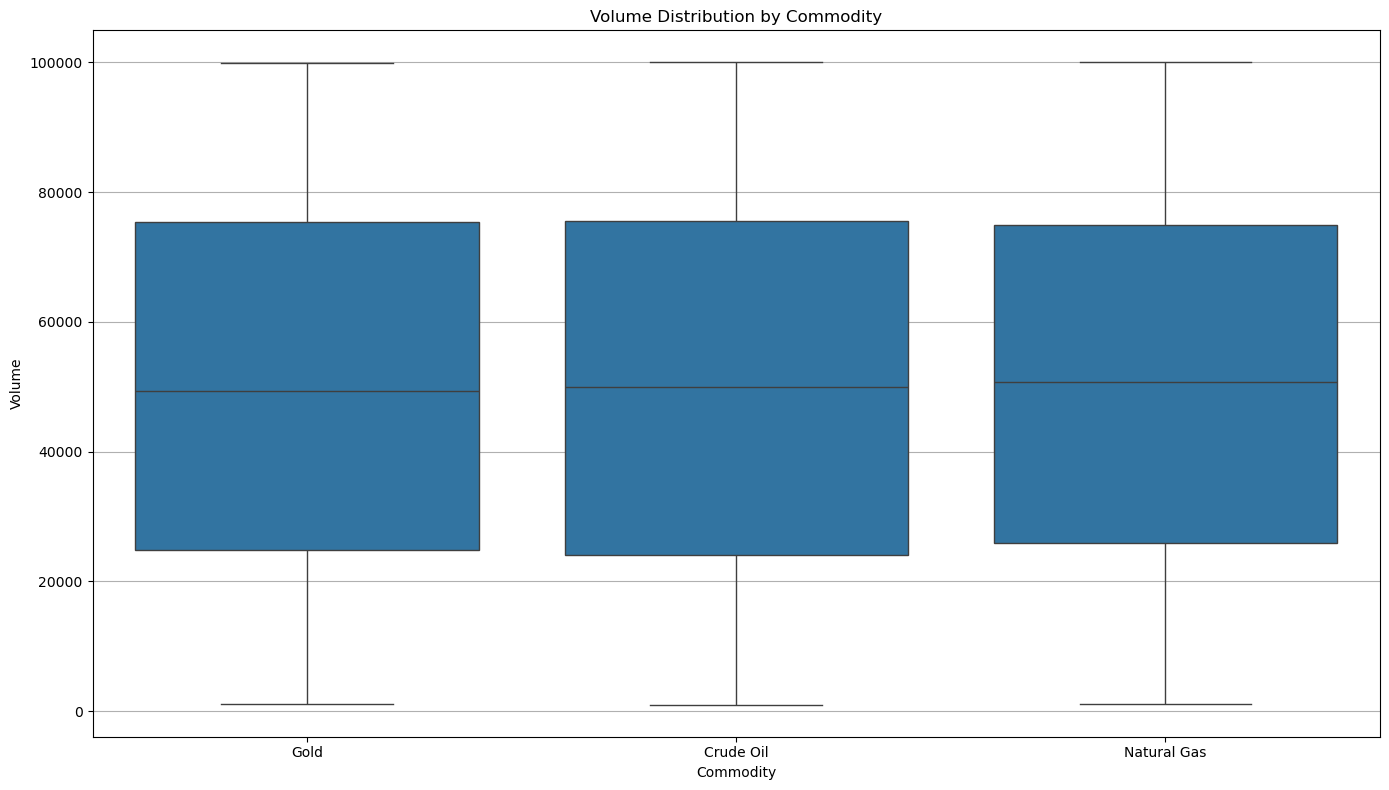

In [26]:
commodities = df['Commodity'].unique()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Commodity', y='Volume', data=df)
plt.title('Volume Distribution by Commodity')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

All three commodities have nearly identical median trading volumes at approximately 50,000 units. Trading volumes trypically fluctuate between around 25,000 to 75,000 units. Extreme values range form near zero to 100,000. The distributions are also remarkably similar across all three commodities.

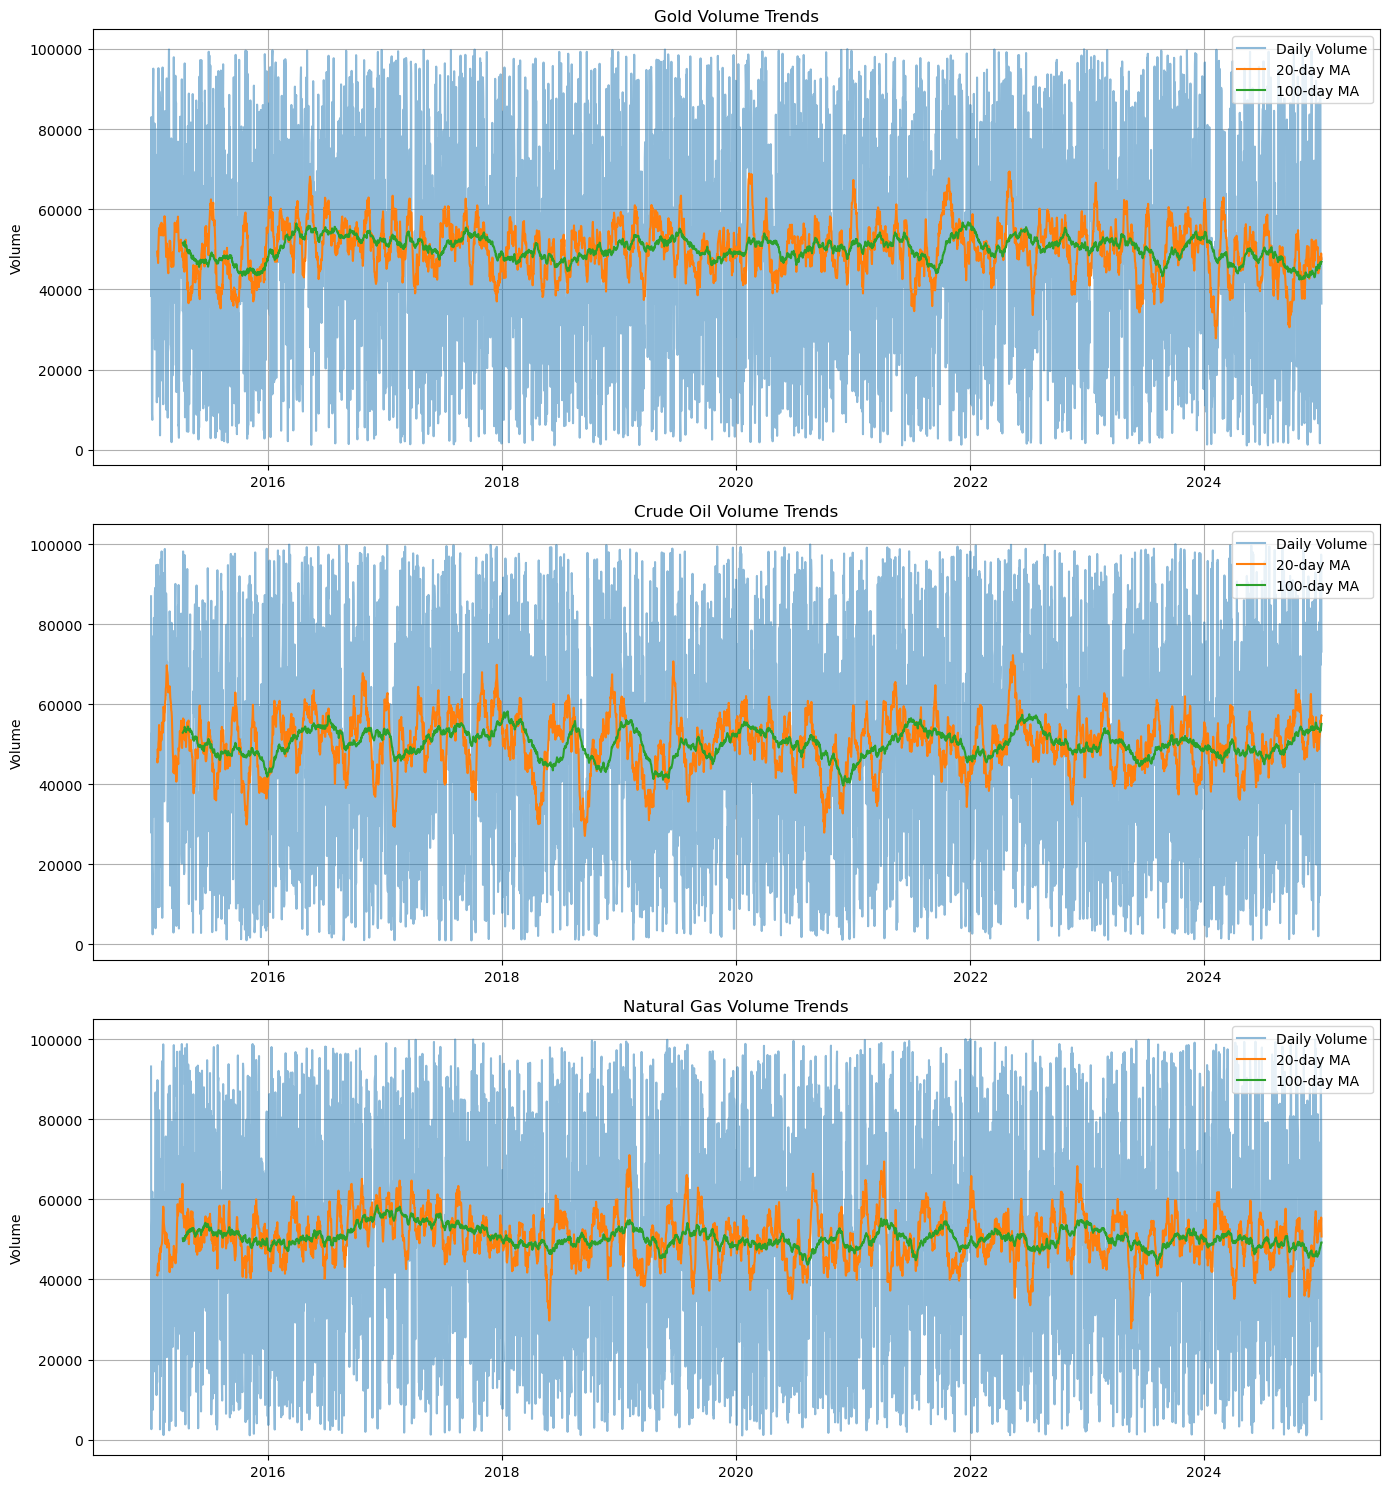

In [28]:
fig, axes = plt.subplots(len(commodities), 1, figsize=(14, 5*len(commodities)))

for i, commodity in enumerate(commodities):
    commodity_data = df[df['Commodity'] == commodity]
    
    short_window = 20
    long_window = 100
    
    axes[i].plot(commodity_data['Date'], commodity_data['Volume'], alpha=0.5, label='Daily Volume')
    axes[i].plot(commodity_data['Date'], 
                commodity_data['Volume'].rolling(window=short_window).mean(), 
                label=f'{short_window}-day MA')
    axes[i].plot(commodity_data['Date'], 
                commodity_data['Volume'].rolling(window=long_window).mean(), 
                label=f'{long_window}-day MA')
    
    axes[i].set_title(f'{commodity} Volume Trends')
    axes[i].set_ylabel('Volume')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

All the three commodities show remarkably similar trading volume patterns. Moving averages reveal that average trading volumes have remained relatively stable over the decade, fluctuating within consistent bands. Preiodic volume spikes occur across all commodities, likely corresponding to major market events. No significant long term volume growth or decline is shown in any commodity. 

Okay since we finally have gone through all the exogenous columns in our data, it turns out that they have pretty same structure and volatility intervals with no trend, which tells us that the most appropriate noise reduction method for all the exogenous variables is Exponential Weighted Moving Average (EWMA) with span of 10. Let's clear the noise and plot the results.

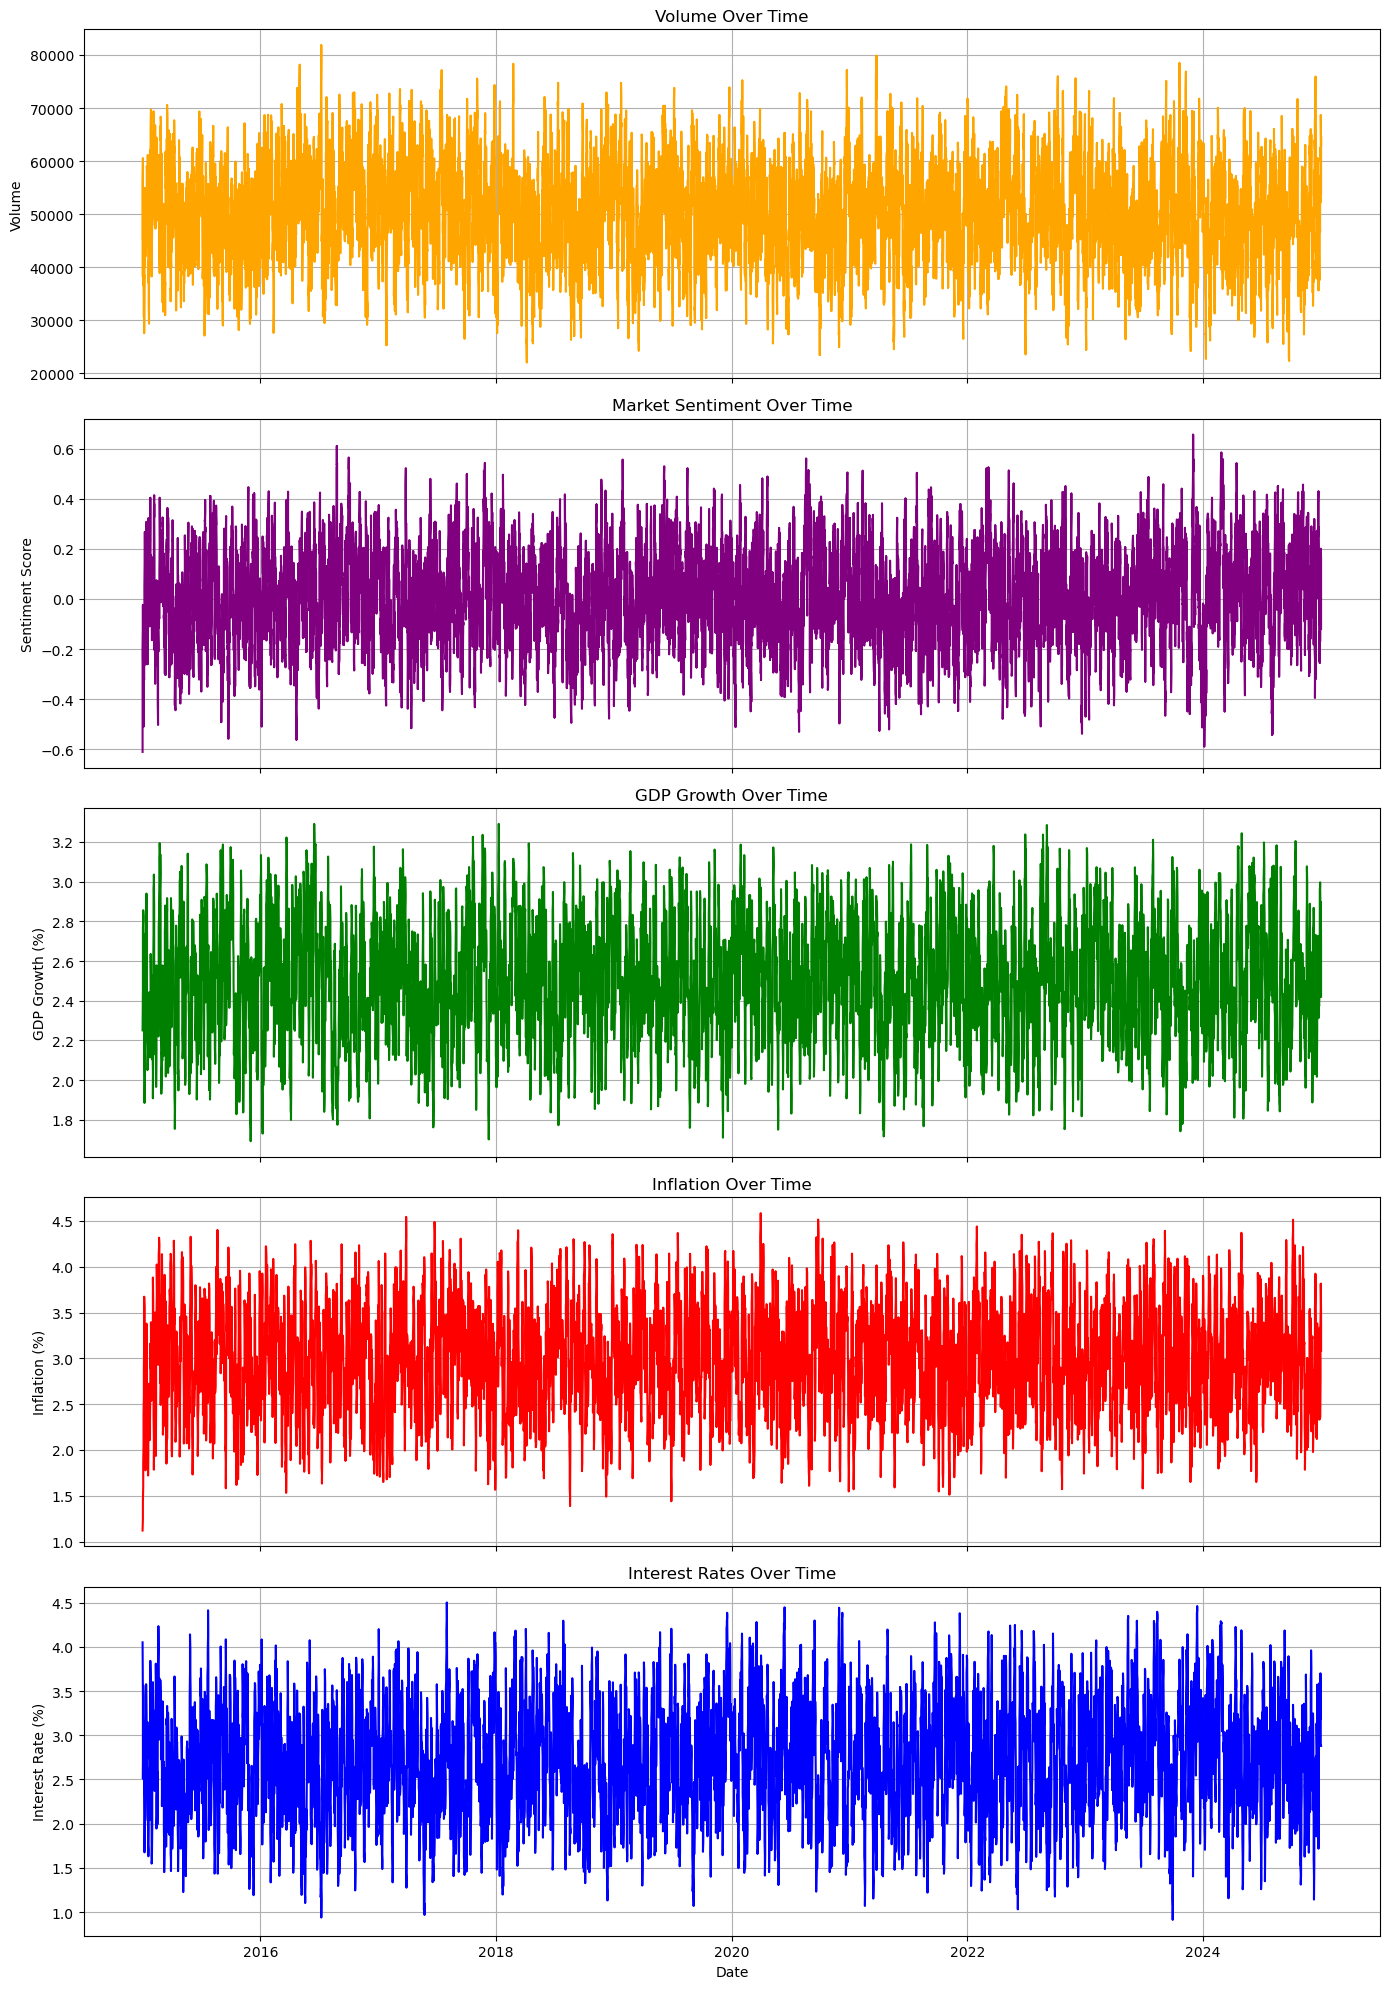

In [31]:
span = 10
df['Volume'] = df['Volume'].ewm(span=span, adjust=False).mean()
df['Market_Sentiment'] = df['Market_Sentiment'].ewm(span=span, adjust=False).mean()
df['GDP_Growth'] = df['GDP_Growth'].ewm(span=span, adjust=False).mean()
df['Inflation'] = df['Inflation'].ewm(span=span, adjust=False).mean()
df['Interest_Rates'] = df['Interest_Rates'].ewm(span=span, adjust=False).mean()

fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

axes[0].plot(df['Date'], df['Volume'], 'orange')
axes[0].set_title('Volume Over Time')
axes[0].set_ylabel('Volume')
axes[0].grid(True)

axes[1].plot(df['Date'], df['Market_Sentiment'], 'purple')
axes[1].set_title('Market Sentiment Over Time')
axes[1].set_ylabel('Sentiment Score')
axes[1].grid(True)

axes[2].plot(df['Date'], df['GDP_Growth'], 'g-')
axes[2].set_title('GDP Growth Over Time')
axes[2].set_ylabel('GDP Growth (%)')
axes[2].grid(True)

axes[3].plot(df['Date'], df['Inflation'], 'r-')
axes[3].set_title('Inflation Over Time')
axes[3].set_ylabel('Inflation (%)')
axes[3].grid(True)

axes[4].plot(df['Date'], df['Interest_Rates'], 'b-')
axes[4].set_title('Interest Rates Over Time')
axes[4].set_ylabel('Interest Rate (%)')
axes[4].set_xlabel('Date')
axes[4].grid(True)

plt.tight_layout()
plt.show()

Much better! Since we removed the most of the noise, without losing the pattern, we can now move on to our target variable - Close, and analyze it.

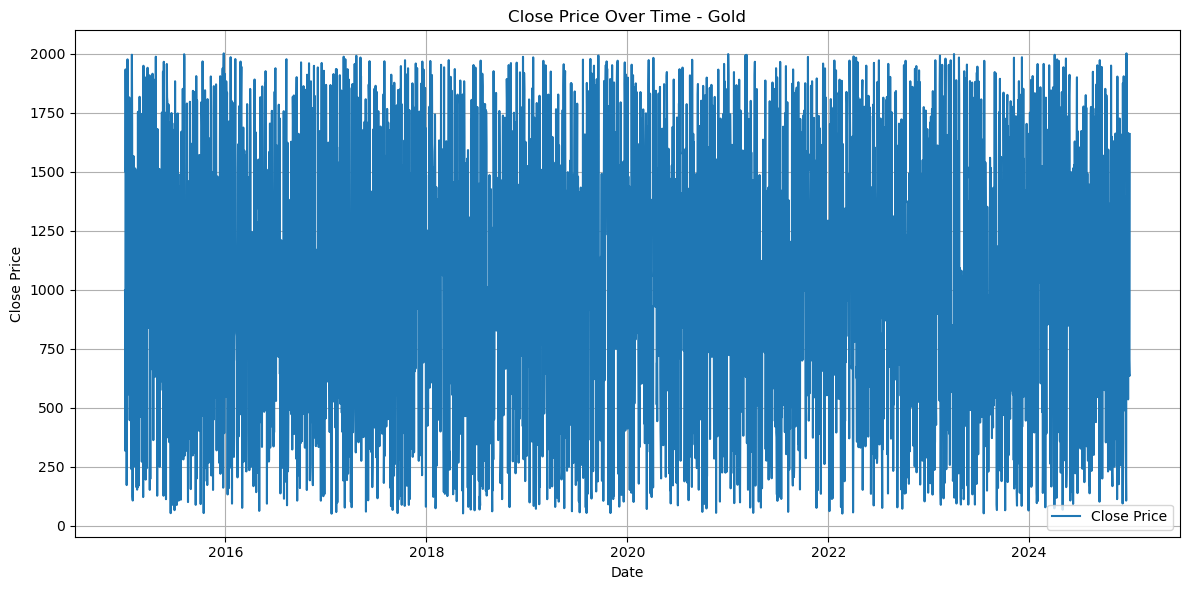

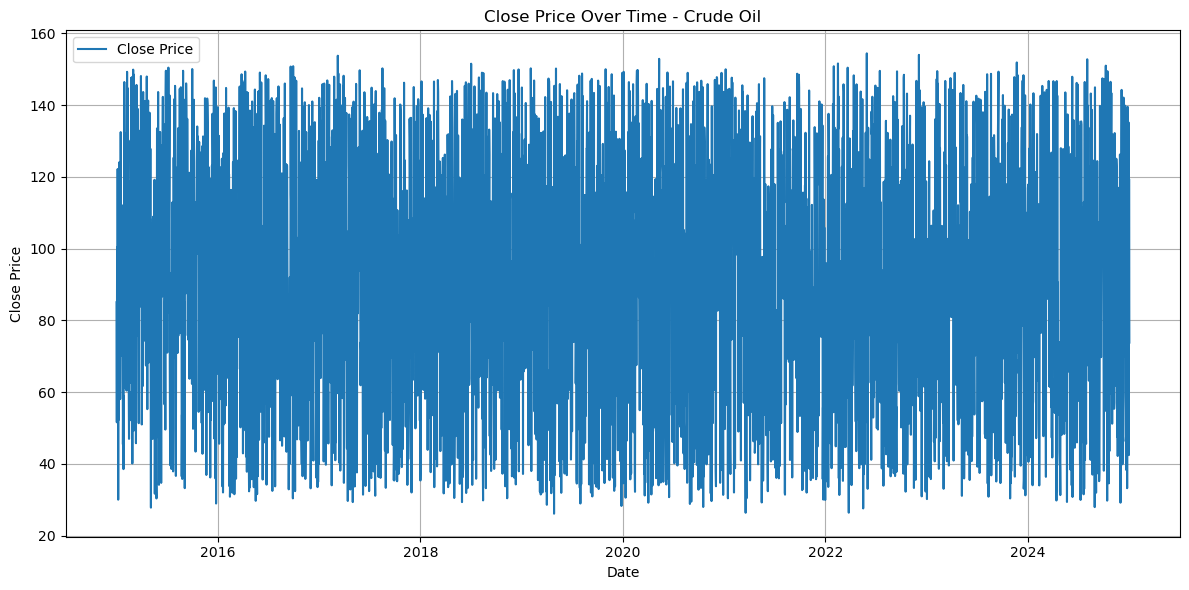

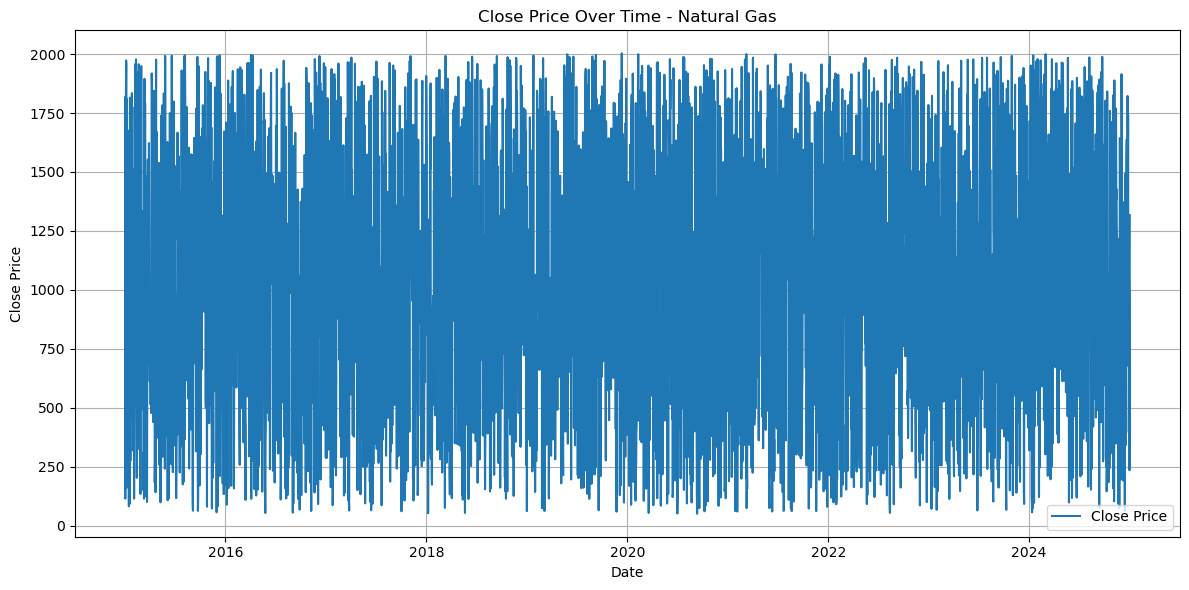

In [33]:
commodities = df['Commodity'].unique()

for commodity in commodities:
    plt.figure(figsize=(12, 6))
    df_commodity = df[df['Commodity'] == commodity]
    plt.plot(df_commodity['Date'], df_commodity['Close'], label='Close Price')
    plt.title(f'Close Price Over Time - {commodity}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

We have also really really noisy time series for all of our commodities as well, which should be taken care of, but before we do that let's keep observing some trends and characteristics of raw data.

<Figure size 1200x600 with 0 Axes>

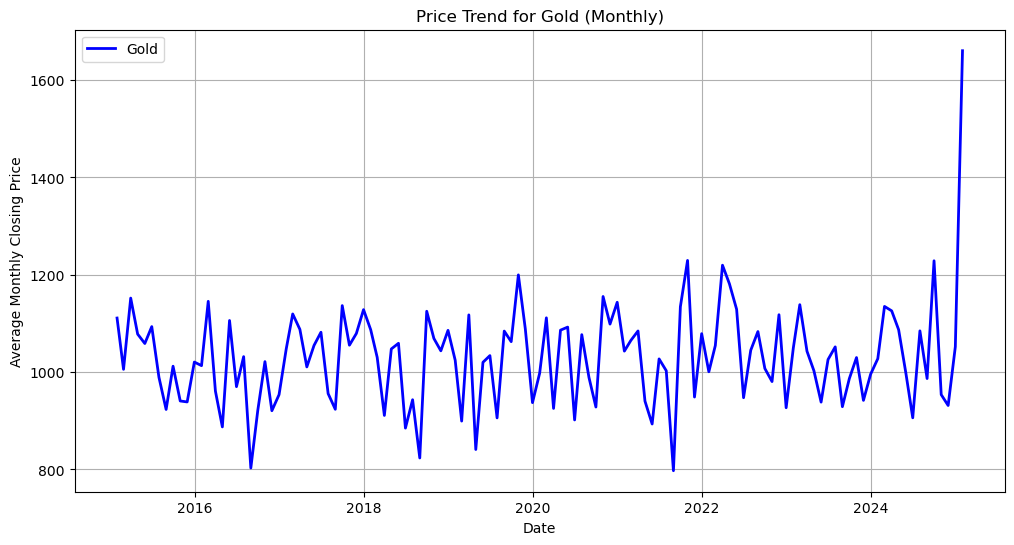

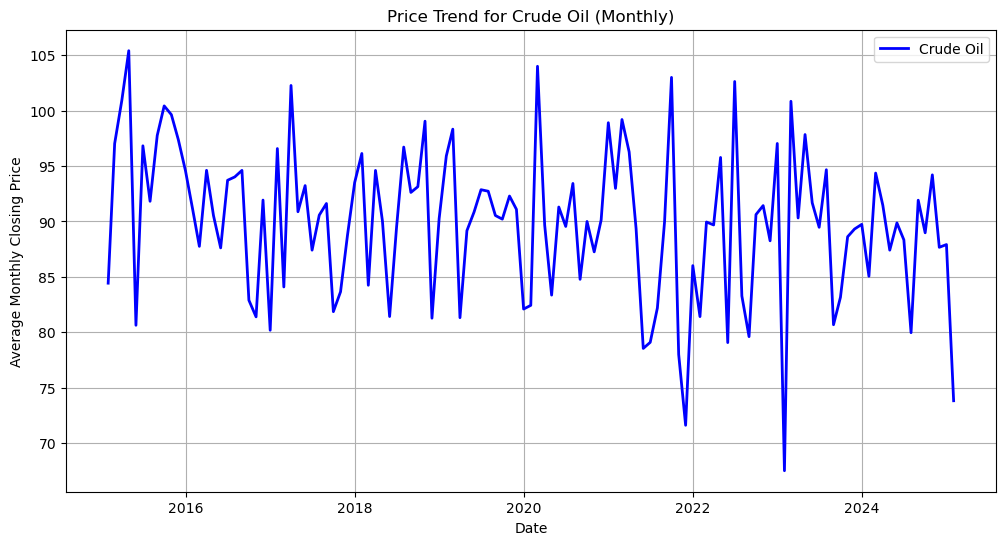

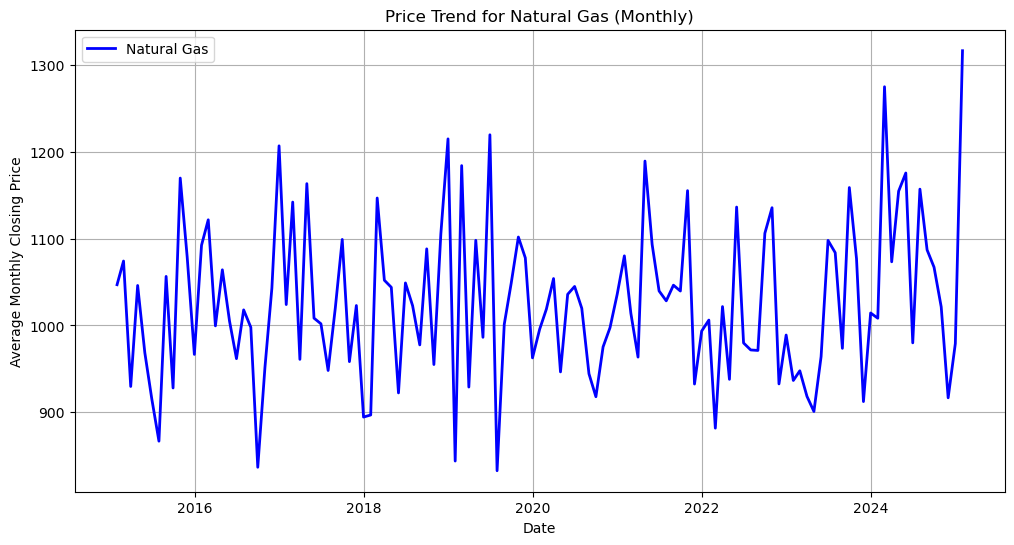

In [35]:
df_monthly = df.groupby(['Commodity', pd.Grouper(key='Date', freq='ME')])['Close'].mean().reset_index()

commodities = df['Commodity'].unique()
plt.figure(figsize=(12, 6))

for commodity in commodities:
    subset = df_monthly[df_monthly['Commodity'] == commodity]
    plt.figure(figsize=(12, 6))
    plt.plot(subset['Date'], subset['Close'], label=commodity, color='b', linewidth=2)
    plt.xlabel("Date")
    plt.ylabel("Average Monthly Closing Price")
    plt.title(f"Price Trend for {commodity} (Monthly)")
    plt.legend()
    plt.grid(True)
    plt.show()

As we can see, there is no significant trend in any commodity's time series, all of them have highly frequent cyclical movement and probable seasonality, which we will explore more closely soon.

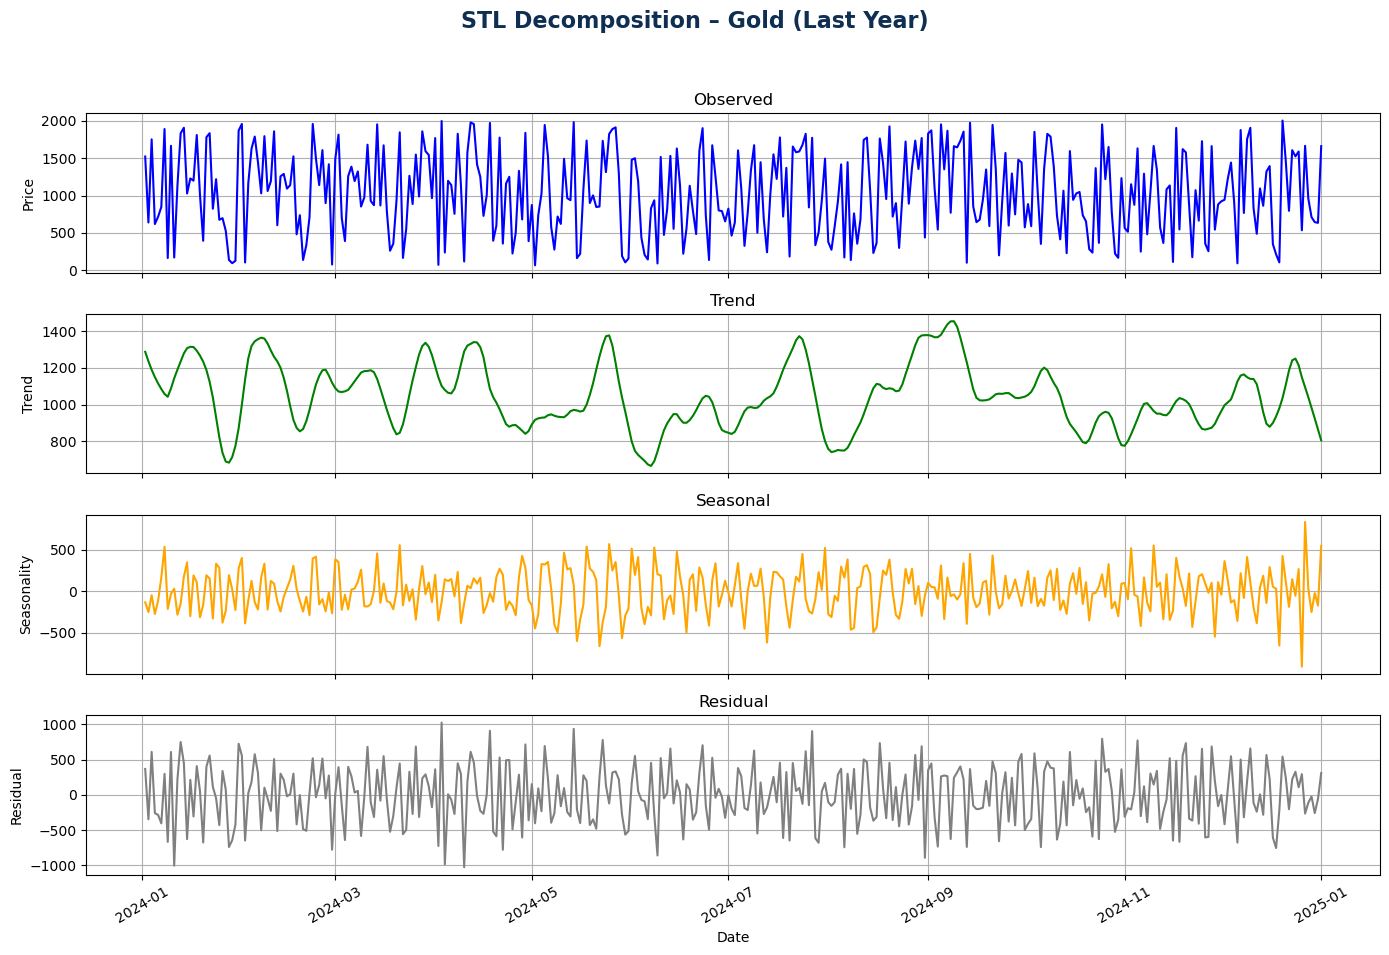

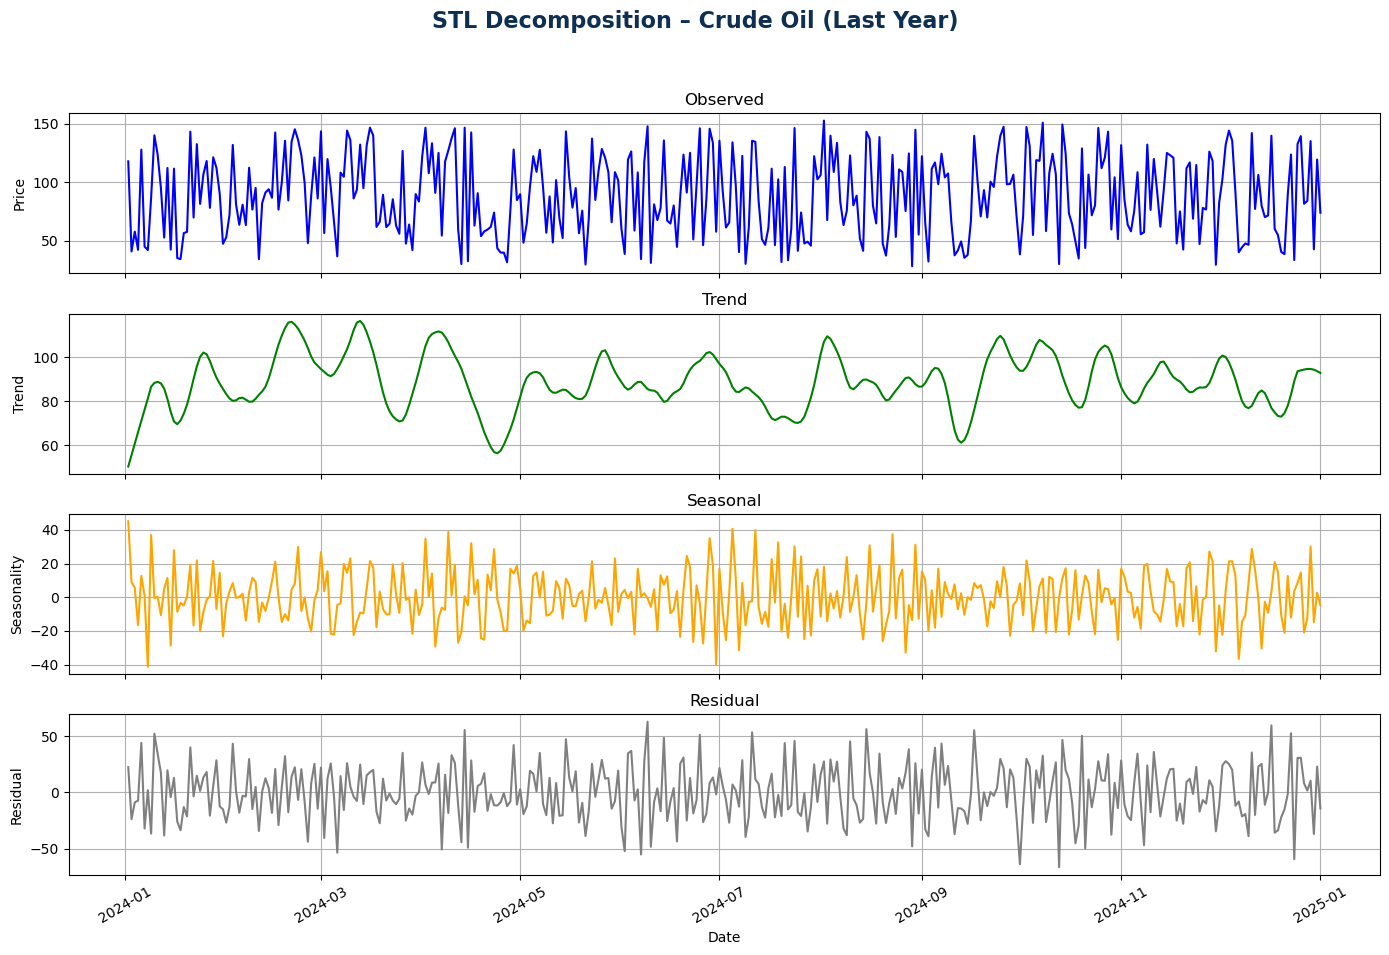

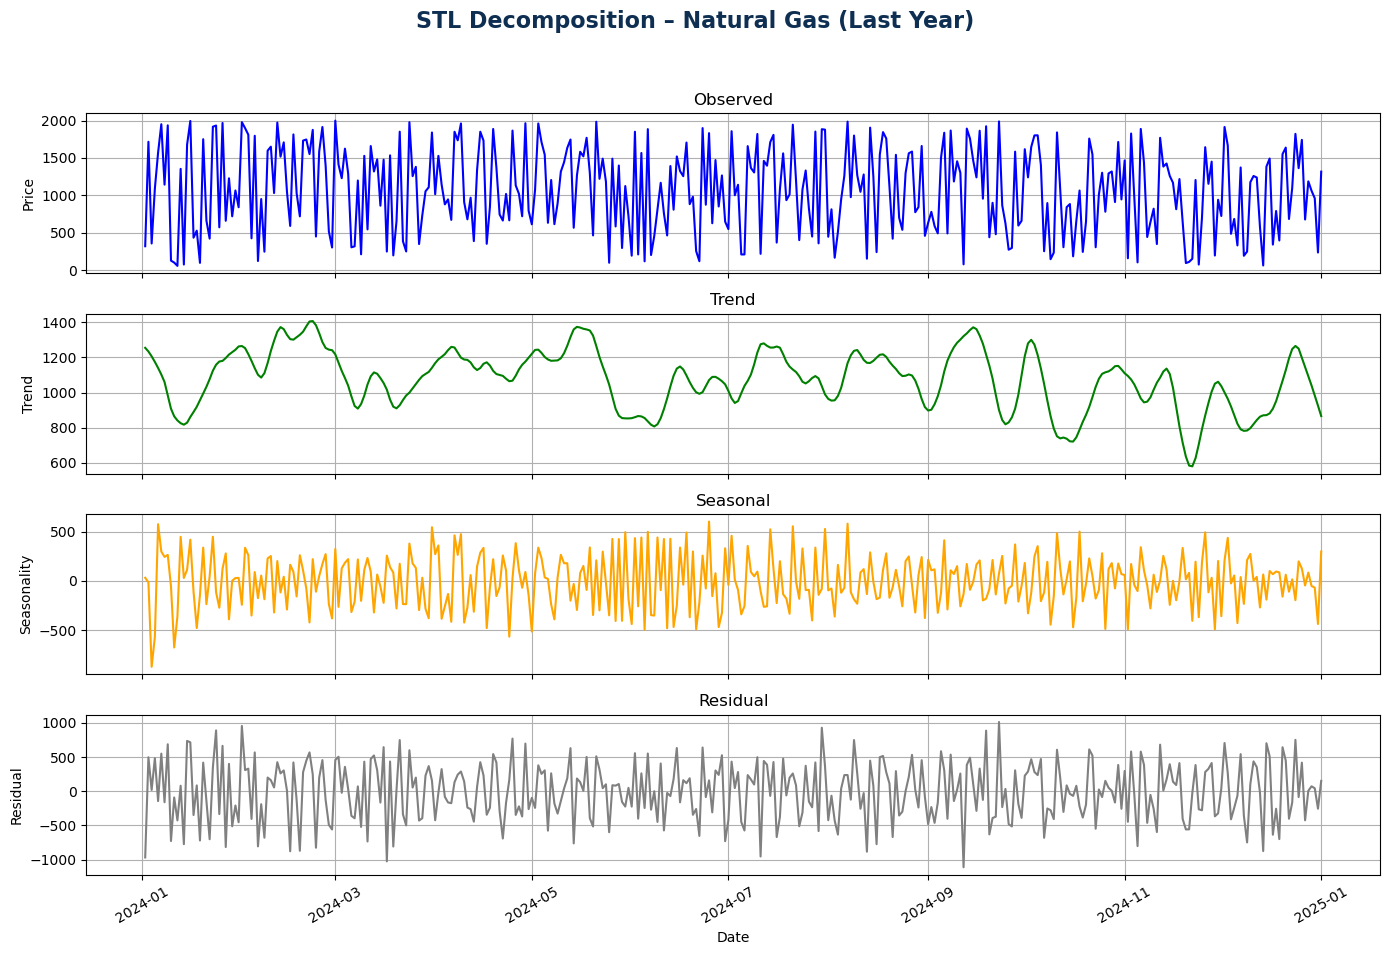

In [37]:
%matplotlib inline
latest_date = df['Date'].max()
one_year_ago = latest_date - pd.Timedelta(days=365)
df_last_year = df[df['Date'] >= one_year_ago]

for commodity in commodities:
    data = df_last_year[df_last_year['Commodity'] == commodity].copy()
    data = data.sort_values('Date')
    data.set_index('Date', inplace=True)

    close_series = data['Close']

    stl = STL(close_series, seasonal=7)
    result = stl.fit()

    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    fig.suptitle(f'STL Decomposition – {commodity} (Last Year)', fontsize=16, fontweight='bold', color='#0e2f52')

    axes[0].plot(result.observed, color='blue')
    axes[0].set_title('Observed', fontsize=12)
    axes[0].set_ylabel('Price')
    
    axes[1].plot(result.trend, color='green')
    axes[1].set_title('Trend', fontsize=12)
    axes[1].set_ylabel('Trend')

    axes[2].plot(result.seasonal, color='orange')
    axes[2].set_title('Seasonal', fontsize=12)
    axes[2].set_ylabel('Seasonality')

    axes[3].plot(result.resid, color='gray')
    axes[3].set_title('Residual', fontsize=12)
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Date')

    for ax in axes:
        ax.grid(True)
        ax.tick_params(axis='x', rotation=30)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Here is the decomposed time series for all commoities, showing the different components of their observations. There are few decomposition methods, but for our case the most suitable is STL (Seasonal Trend decomposition using Loess), because it is the most effective one for the cyclical and seasonal time series. What can we say about the plots, all the commodities have pretty same components, having no clear trend, fluctuative residuals and visible seasonality. We should take this in mind for the model selection.

We conducted that our data has a strong seasonality, but we need more precision for future modeling, so let's find out exactly how frequent our commodity prices' seasonalities are.

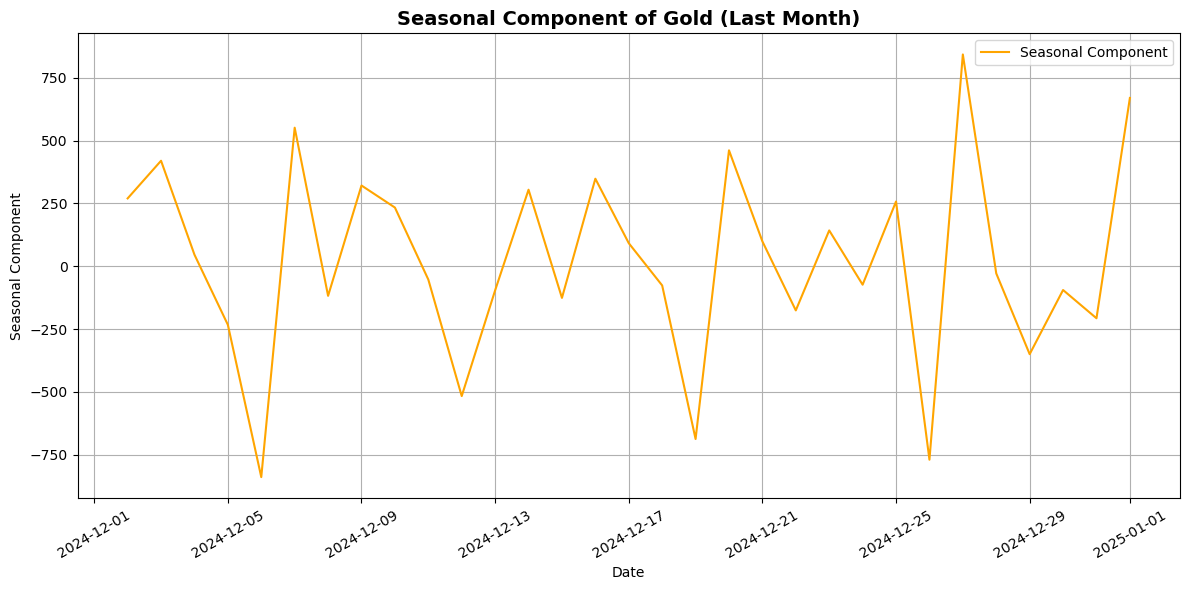

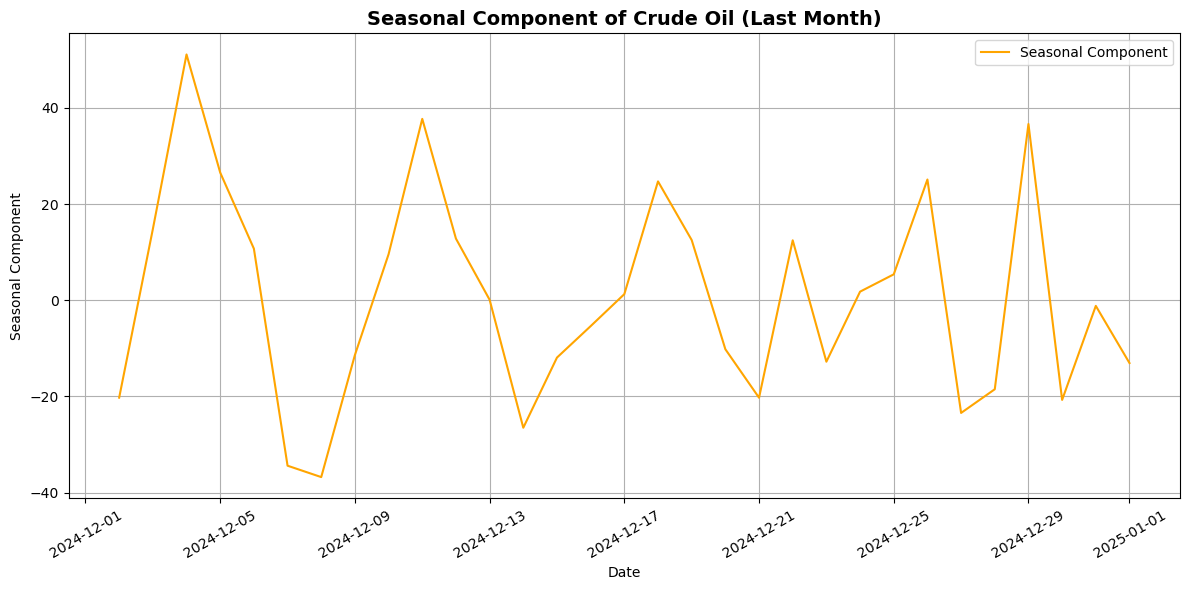

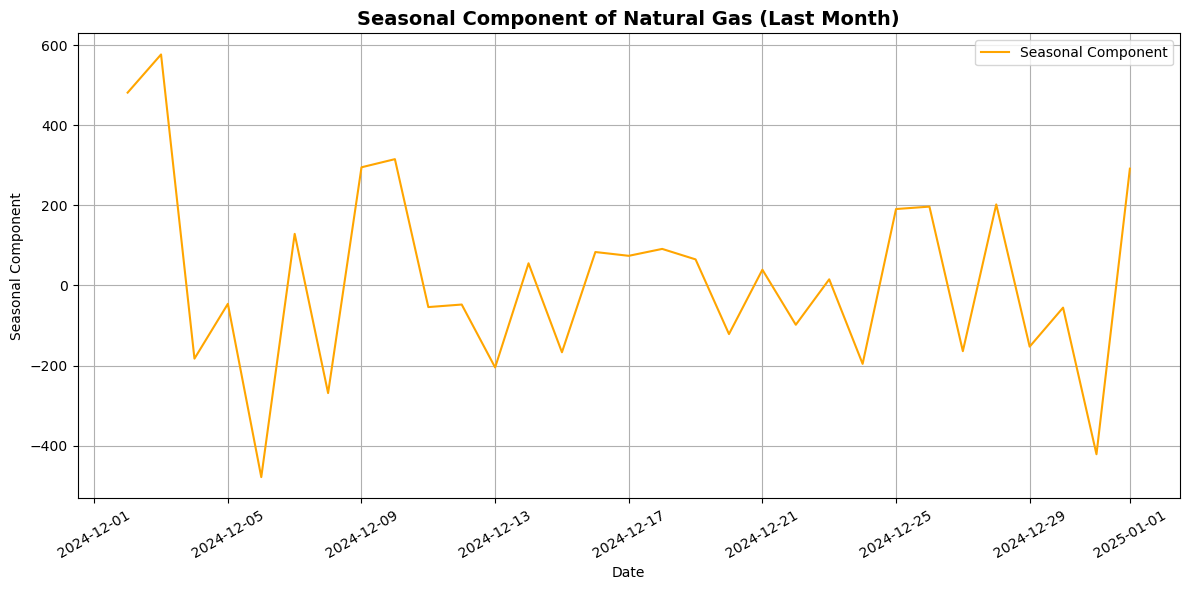

In [40]:
latest_date = df['Date'].max()
one_month_ago = latest_date - pd.Timedelta(days=30)
df_last_month = df[df['Date'] >= one_month_ago]

commodities = df_last_month['Commodity'].unique()

for commodity in commodities:
    data = df_last_month[df_last_month['Commodity'] == commodity].copy()
    data = data.sort_values('Date')
    data.set_index('Date', inplace=True)

    close_series = data['Close']

    stl = STL(close_series, seasonal=7)
    result = stl.fit()

    plt.figure(figsize=(12, 6))
    plt.plot(result.seasonal, color='orange', label='Seasonal Component')
    plt.title(f'Seasonal Component of {commodity} (Last Month)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Seasonal Component')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

These graphs show us the closer look of the seasonal components, telling us that pretty much all the commodities have the same seasonality, cycling approximately every 5-7 days, which is what we were trying to discover so we can use for proper noise reduction and modeling.

Next thing we want to find out is the how lagged values are correlated with each other - lag analysis. Let's plot the ACF and PACF plots and analyse the results.

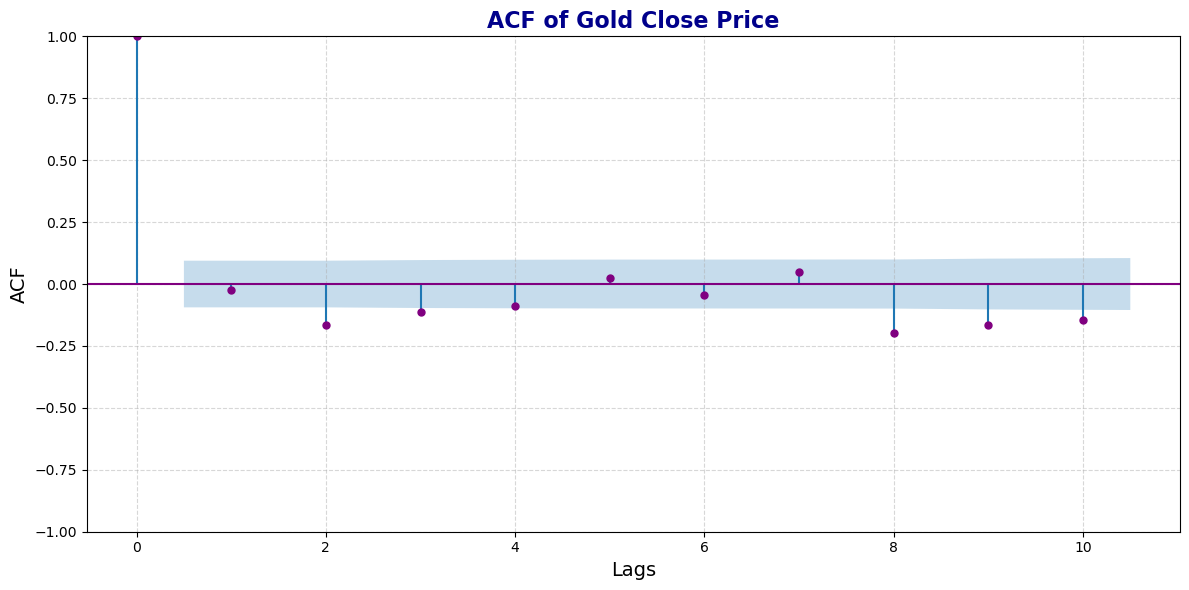

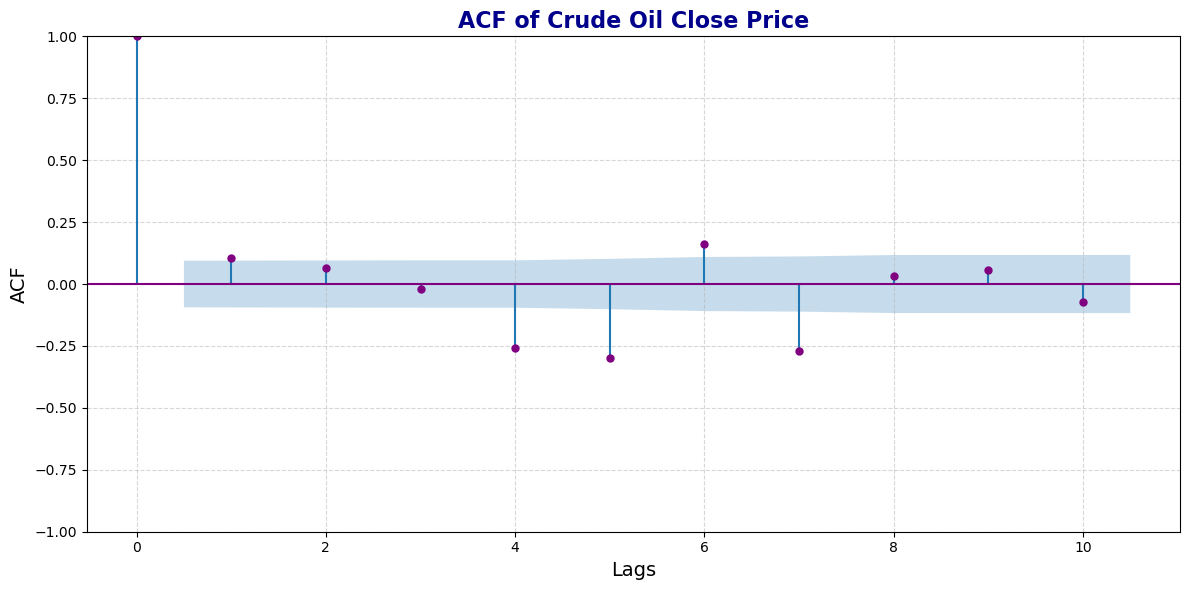

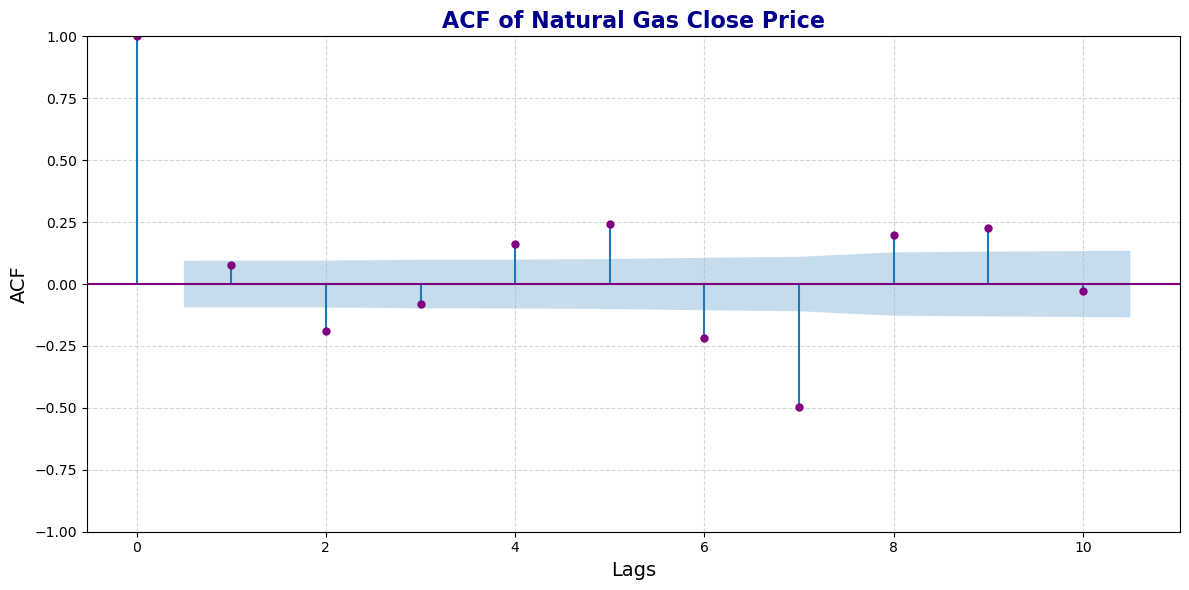

In [43]:
latest_date = df['Date'].max()
one_month_ago = latest_date - pd.Timedelta(days=30)
df_last_month = df[df['Date'] >= one_month_ago]

commodities = df_last_month['Commodity'].unique()

for commodity in commodities:
    data = df_last_month[df_last_month['Commodity'] == commodity].copy()
    data = data.sort_values('Date')
    data.set_index('Date', inplace=True)

    close_series = data['Close']

    plt.figure(figsize=(12, 6))
    plot_acf(close_series, lags=10, ax=plt.gca(), color='purple', alpha=0.6)

    plt.title(f'ACF of {commodity} Close Price', fontsize=16, fontweight='bold', color='darkblue')
    plt.xlabel('Lags', fontsize=14, color='black')
    plt.ylabel('ACF', fontsize=14, color='black')

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Let's brake down it down as commodities and review their lag correlations based on each graph:

- **Gold**
The ACF plot for gold shows predominantly insignificant autocorrelations across all lags. All correlation values remain within the confidence bands, with slight negative correlations appearing at lags 2, 3, 4, 8, 9, and 10. This suggests gold price movements exhibit little serial correlation and follow a pattern consistent with a random walk or efficient market behavior.

- **Crude Oil**
The crude oil ACF displays a more structured pattern of correlations. Negative autocorrelations appear at lags 3, 4, 5, 7, and 10, with the strongest negative correlations at lags 4 and 5. Positive correlations are visible at lags 1, 2, 6, 8, and 9. While these correlations suggest slight cyclical behavior, most remain within significance bands, indicating weak serial dependence.

- **Natural Gas**
Natural gas shows the most volatile autocorrelation pattern among the commodities. Strong negative correlations appear at lags 2, 3, 6, and 7, with lag 7 nearly breaching the significance boundary. Positive correlations are visible at lags 1, 4, 5, 8, and 9. This alternating pattern suggests potential cyclical behavior in natural gas prices, though most correlations remain statistically insignificant.

**Overall**: All three commodities demonstrate relatively efficient market characteristics with limited statistically significant autocorrelations, suggesting that predictive models based solely on past price movements would likely have minimal effectiveness in forecasting future price changes.

Before we move to the next EDA step for our target variable, which is checking stationarity, we should reduct the noise first. For the noise reduction in this case I will use the same technique as I used for exogenouse variables - EWMA, with span of 10. I think this is a solid choice, because we can handle the same types of noisy data again and we also won't lose any key trends and patterns for proper forecasting. Let's perform the reduction and plot the results.

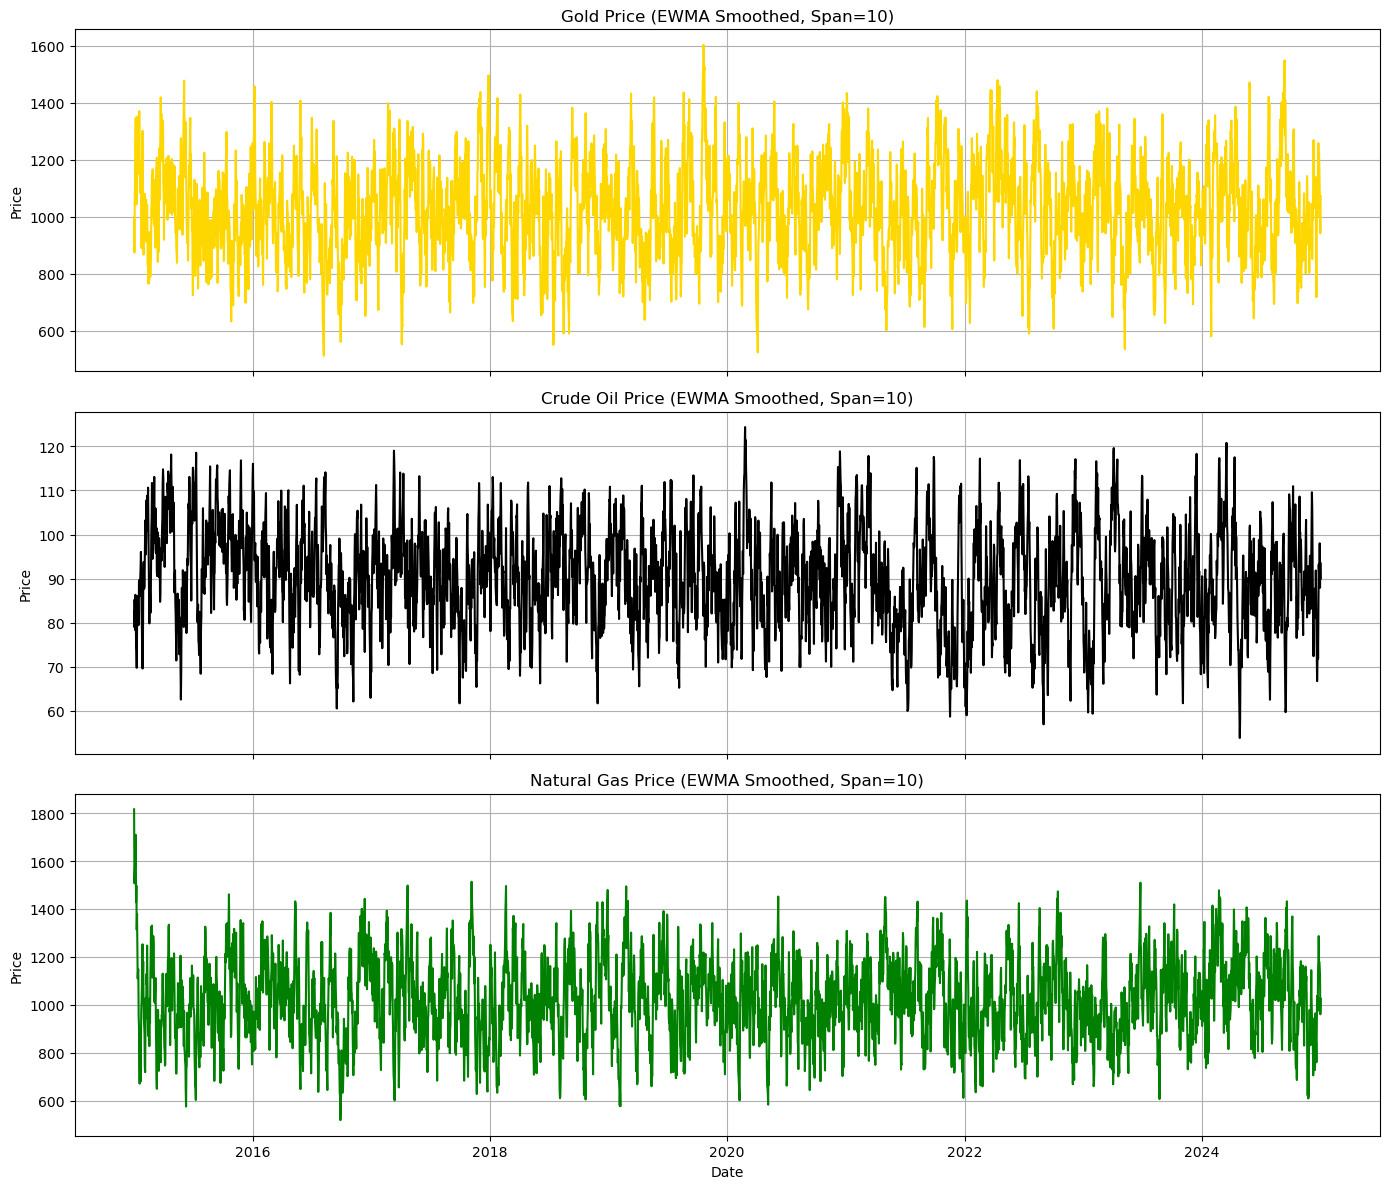

In [46]:
df['Close'] = df.groupby('Commodity')['Close'].transform(lambda x: x.ewm(span=10, adjust=False).mean())

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

commodities = ['Gold', 'Crude Oil', 'Natural Gas']
colors = ['gold', 'black', 'green']

for i, (commodity, color) in enumerate(zip(commodities, colors)):
    subset = df[df['Commodity'] == commodity]
    axes[i].plot(subset['Date'], subset['Close'], color=color)
    axes[i].set_title(f'{commodity} Price (EWMA Smoothed, Span=10)')
    axes[i].set_ylabel('Price')
    axes[i].grid(True)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

Noise got significantly reduced, without losing any key patterns in our series. Next and most important thing to analyse is the stationarity of all our commodity prices, because some of the models that we will be training later in this project have strict requirement of stationary time series. Let's analyse them with proper plots and statistical tests for more precise assumptions.

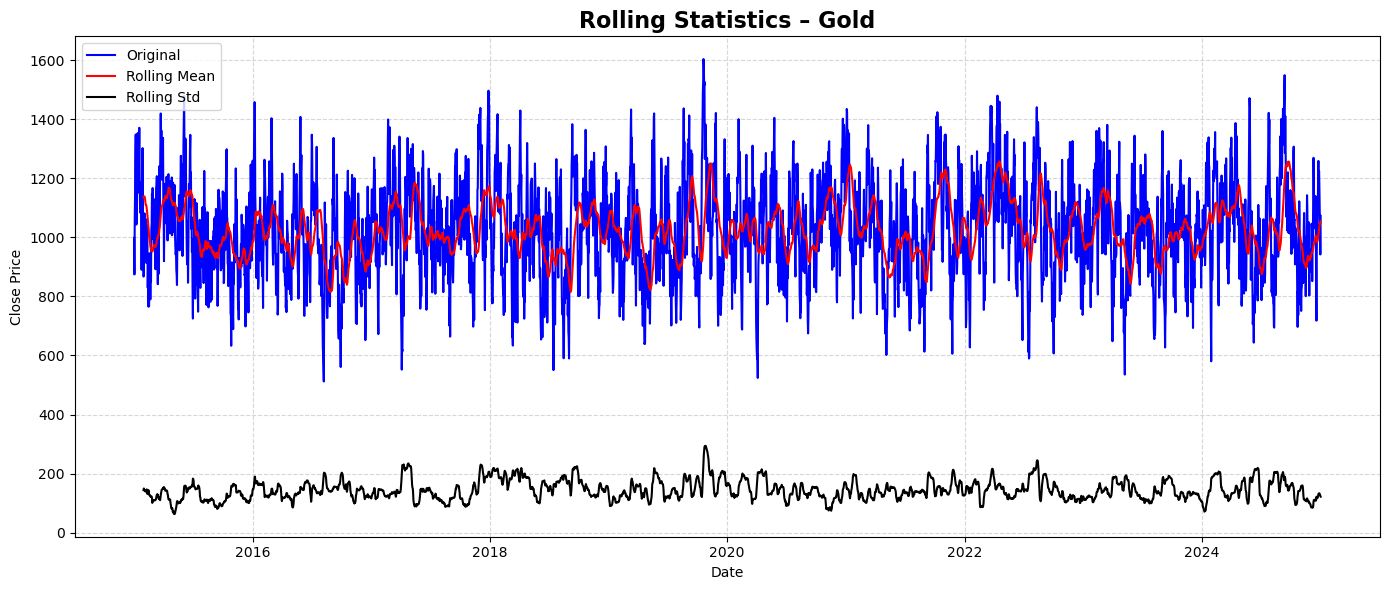


ADF Test Results – Gold
Test Statistic: -17.0206
P-value: 0.0000
Lags Used: 3
Number of Observations: 3650
Critical Value (1%): -3.4321
Critical Value (5%): -2.8623
Critical Value (10%): -2.5672


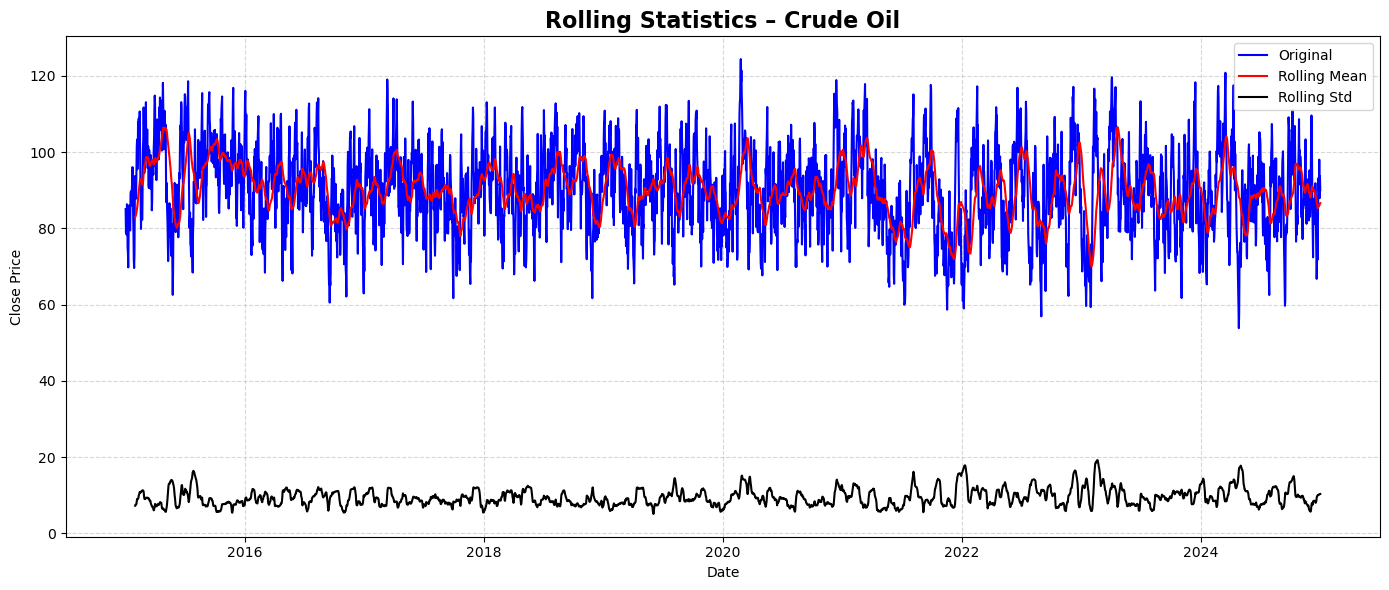


ADF Test Results – Crude Oil
Test Statistic: -18.3197
P-value: 0.0000
Lags Used: 0
Number of Observations: 3653
Critical Value (1%): -3.4321
Critical Value (5%): -2.8623
Critical Value (10%): -2.5672


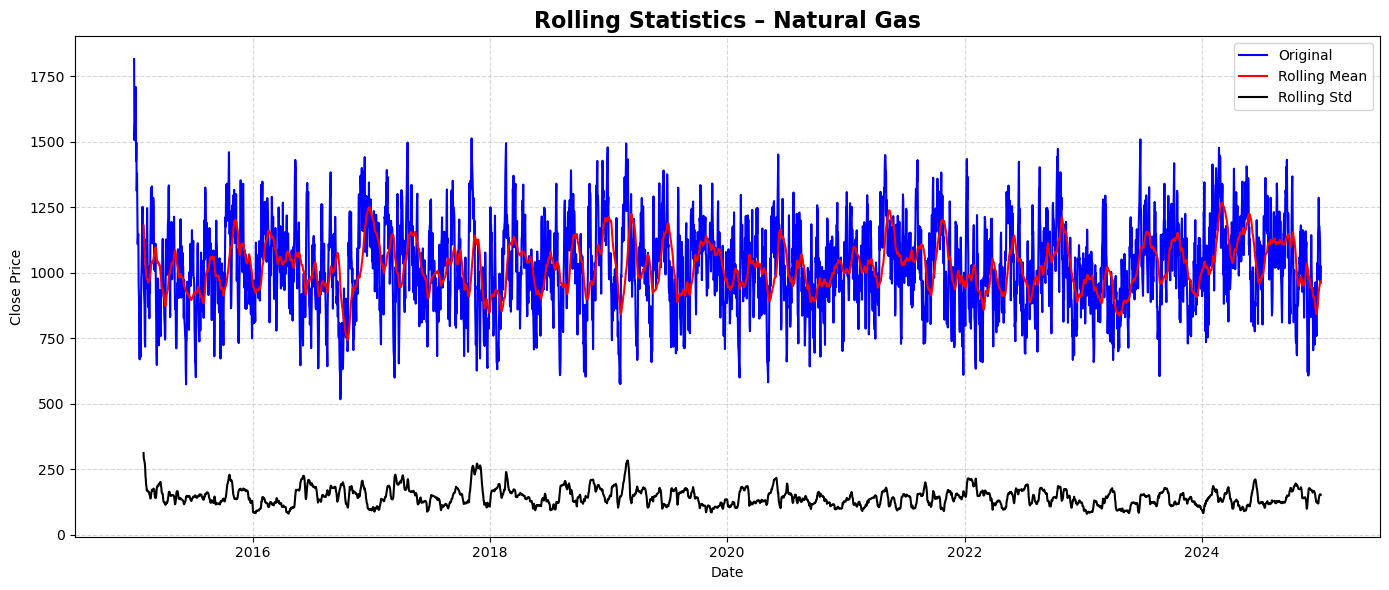


ADF Test Results – Natural Gas
Test Statistic: -20.3368
P-value: 0.0000
Lags Used: 0
Number of Observations: 3653
Critical Value (1%): -3.4321
Critical Value (5%): -2.8623
Critical Value (10%): -2.5672


In [48]:
for commodity in commodities:
    data = df[df['Commodity'] == commodity].copy()
    data = data.sort_values('Date')
    data.set_index('Date', inplace=True)

    close_series = data['Close']

    rolling_mean = close_series.rolling(window=30).mean()
    rolling_std = close_series.rolling(window=30).std()

    plt.figure(figsize=(14, 6))
    plt.plot(close_series, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.title(f'Rolling Statistics – {commodity}', fontsize=16, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    result = adfuller(close_series.dropna())
    print(f"\nADF Test Results – {commodity}")
    print(f"Test Statistic: {result[0]:.4f}")
    print(f"P-value: {result[1]:.4f}")
    print(f"Lags Used: {result[2]}")
    print(f"Number of Observations: {result[3]}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value:.4f}")

The Augmented Dickey-Fuller (ADF) test was used to assess the stationarity of three commodity price time series: Gold, Crude Oil, and Natural Gas. The test statistics for all three series were substantially lower than the 1% critical value of -3.4321, and all p-values were 0.0000, indicating strong evidence against the null hypothesis of a unit root (non-stationarity).

- Gold: Test Statistic = -17.0206

- Crude Oil: Test Statistic = -18.3197

- Natural Gas: Test Statistic = -20.3368

These results confirm that all three series are stationary at a high level of statistical confidence. This implies that the prices of these commodities tend to revert to their mean over time rather than follow a random walk.

As a result, these time series can be modeled without differencing, simplifying the forecasting process and reducing the risk of spurious regression results.

We are done here with data analysis, gathered all the important and sufficient information about all the variables in out dataset that is crucial for the upcoming preprocessing and modeling decisions.

## **Data Preprocessing and Feature Engineering**

In this section we will make some transformations and corrections to our dataset, based on the information that we obtained during our EDA. These prerpocessing steps are crucial for the model benchmarking and will help models to enhance their performances.

Before we preprocess our data, we have to understand and decide which models are we going to train and then preprocess the data according to that model, because every model has its unique requirements. Based on the information form the EDA section, we should choose the models that are good with the multivariate forecasting of data with strong seasonality. Moreover, I want to do a little experiment and benchmark 3 models from 3 different categories: Traditional forecasting models, Feature-Based models, Neural Network models. For each of these categories I will take the commonly best performers that are proven to have the best general results on the data like we have in our hands. 

Models that we are going to train and evaluate:
- **Seasonal ARIMAX** as classical model
- **XGBoost** as feature-based model
- **LSTM** as advanced neural network model

Since we know every model, we can start preprocessing our data as well as engineering some new features for more precise foreacsting. For every model we will create different function that will include every preprocessing step appropriate for that particular model. Before we do SARIMAX preprocessing, let's divide our dataset as triple separate commodity ones for easier training and evaluation.

In [55]:
df_gold = df[df['Commodity'] == 'Gold'].copy()
df_oil = df[df['Commodity'] == 'Crude Oil'].copy()
df_gas = df[df['Commodity'] == 'Natural Gas'].copy()

df_gold.reset_index(drop=True, inplace=True)
df_oil.reset_index(drop=True, inplace=True)
df_gas.reset_index(drop=True, inplace=True)

print(f"Gold dataframe shape: {df_gold.shape}")
print(f"Crude Oil dataframe shape: {df_oil.shape}")
print(f"Natural Gas dataframe shape: {df_gas.shape}")

df_gold.sort_values('Date', inplace=True)
df_oil.sort_values('Date', inplace=True)
df_gas.sort_values('Date', inplace=True)

columns_to_drop = ['Commodity', 'Open', 'High', 'Low']

df_gold.drop(columns=columns_to_drop, inplace=True)

df_oil.drop(columns=columns_to_drop, inplace=True)

df_gas.drop(columns=columns_to_drop, inplace=True)

Gold dataframe shape: (3654, 11)
Crude Oil dataframe shape: (3654, 11)
Natural Gas dataframe shape: (3654, 11)


Now instead of one whole, we have three separate datasets for each commodity, now we can start creating our preprocessing/engineering pipelines for each model.

In [57]:
def preprocessing_sarimax(df, test_size=0.2):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df.asfreq('D')  
    
    split_idx = int(len(df) * (1 - test_size))
    train_data = df.iloc[:split_idx].copy()
    test_data = df.iloc[split_idx:].copy()
    
    result = adfuller(train_data['Close'].dropna())
    p_value = result[1]
    differencing = 0
    
    train_target = train_data['Close'].copy()
    test_target = test_data['Close'].copy()
    
    if p_value > 0.05:
        train_target = train_data['Close'].diff().dropna()
        test_target = test_data['Close'].diff().dropna()
        differencing = 1
    
    return {
        'train_data': train_data,
        'test_data': test_data,
        'train_target': train_target,
        'test_target': test_target,
        'differencing': differencing,
        'last_train_value': train_data['Close'].iloc[-1]  
    }

This preprocessing_sarimax function prepares a time series dataset for SARIMAX modeling. It firstly converts the 'Date' column to datetime, sets it as the index, and ensures the data has daily frequency. Then it splits the data into training and testing sets, checks if the series is stationary using the Augmented Dickey-Fuller test, and applies differencing if needed. As an output it returns the processed train/test data, targets, differencing info, and the last original training value.

In [59]:
def preprocessing_xgboost(df, test_size=0.2, n_lags=3):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    
    for lag in range(1, n_lags + 1):
        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
    
    df['Close_roll_mean_7'] = df['Close'].rolling(window=7).mean()
    df['Close_roll_std_7'] = df['Close'].rolling(window=7).std()
    
    df['Close_target'] = df['Close'].shift(-1)
    
    df = df.dropna().reset_index(drop=True)
    
    exog_cols = [col for col in df.columns if col not in ['Date', 'Close', 'Close_target']]
    
    split_idx = int(len(df) * (1 - test_size))
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    
    scaler = StandardScaler()
    train_X = pd.DataFrame(scaler.fit_transform(train_df[exog_cols]), columns=exog_cols)
    test_X = pd.DataFrame(scaler.transform(test_df[exog_cols]), columns=exog_cols)
    
    train_y = train_df['Close_target']
    test_y = test_df['Close_target']
    
    return {
        'train_X': train_X,
        'test_X': test_X,
        'train_y': train_y,
        'test_y': test_y,
        'scaler': scaler,
        'exog_cols': exog_cols
    }

This preprocessing_xgboost function prepares a time series dataset for XGBoost modeling. It first converts and sorts the 'Date' column, then creates lag features and rolling statistics from the 'Close' column to capture recent trends. It sets the next day’s 'Close' value as the prediction target, drops any missing values, and splits the data into training and testing sets. Finally, it scales the features and returns the processed inputs, targets, feature names, and the scaler used.

In [61]:
def preprocessing_lstm(df, test_size=0.2, seq_len=7):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    
    features = ['Close', 'Volume', 'Market_Sentiment', 'GDP_Growth', 'Inflation', 'Interest_Rates']
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features])
    
    X, y = [], []
    for i in range(seq_len, len(df)):
        X.append(scaled_features[i-seq_len:i])   
        y.append(df.loc[i, 'Close'])            
    
    X, y = np.array(X), np.array(y)
    
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'features': features,
        'seq_len': seq_len
    }

And our final preprocessing_lstm function prepares a time series dataset for LSTM modeling. It converts and sorts the 'Date' column, then selects several features and scales them. It creates sequences of a specified length from the scaled features as input and uses the corresponding 'Close' value as the target. The data is split into training and testing sets, and the function returns the prepared sequences, targets, scaler, feature names, and sequence length.

With this pipelines, we done with the preprocessing and feature engineering part, now it is time to train some models and compare their results.

## **Model Benchmarking**

In this section we will be creating training and evaluation pipelines, that will train every model, evalute the metrics and do the residual analysis. Then we compare them to each other, choose the best performer and do the hyperparameter tuning for further enhancements.

Before we create separate training function for each commodity, firstly let's create the general evaluation functino, which will suit every model and help us make the comparison based on the same evaluation methods.

In [67]:
def model_evaluation(actual, forecast):
    residuals = actual - forecast
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    r2 = r2_score(actual, forecast)

    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R-squared (R²): {r2:.4f}')

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].plot(residuals, color='purple')
    axes[0, 0].set_title('Residuals Time Series')
    axes[0, 0].set_xlabel('Index')
    axes[0, 0].set_ylabel('Residuals')

    axes[0, 1].hist(residuals, bins=30, color='skyblue', edgecolor='black')
    axes[0, 1].set_title('Residuals Histogram')

    plot_acf(residuals, ax=axes[1, 0], lags=30, title='ACF of Residuals')

    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

So this model_evaluation function assesses the accuracy of a forecasting model by comparing actual and predicted values. It calculates key metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared. It also creates four plots: the residuals over time, a histogram of residuals, the autocorrelation function (ACF) of residuals. This will help us to visually and quantitatively evaluate model performance and residual patterns.

Time to create train pipelines for each model, starting with SARIMAX.

In [70]:
def train_sarimax(df, commodity_name):
    results = preprocessing_sarimax(df)
    
    train_target = results['train_target']
    test_target = results['test_target']
    differencing = results['differencing']
    
    model = SARIMAX(
        train_target,
        order=(1, 0, 1),
        seasonal_order=(1, 0, 1, 7), 
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    model_fit = model.fit(disp=False, maxiter=100, method='powell')
    
    forecast = model_fit.get_forecast(steps=len(test_target)).predicted_mean
    
    if differencing == 1:
        last_value = results['last_train_value']
        original_forecast = [last_value]
        
        for f in forecast:
            original_forecast.append(original_forecast[-1] + f)
        
        forecast = pd.Series(original_forecast[1:], index=test_target.index)
        
        if differencing == 1:
            original_test = [results['last_train_value']]
            for t in test_target:
                original_test.append(original_test[-1] + t)
            test_target = pd.Series(original_test[1:], index=test_target.index)
    
    last_6_months_start = test_target.index[-1] - pd.DateOffset(months=6)
    zoom_idx = test_target.index >= last_6_months_start
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_target.index[zoom_idx], test_target[zoom_idx], label='Actual', color='#1f77b4', linewidth=3, marker='D', markersize=6)
    plt.plot(test_target.index[zoom_idx], forecast[zoom_idx], label='Forecast', color='#ff7f0e', linestyle='-', alpha=0.9, linewidth=3)
    plt.title(f'{commodity_name} Forecast vs Actual (Last 6 Months)')
    plt.xlabel('Date')
    plt.ylabel(f'{commodity_name} Close Price')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    return model_fit, forecast

Briefly about this function: Firstly it preprocesses the data, then fits a SARIMAX model with an autoregressive order of 1 (capturing dependence on the previous time point), a moving average order of 1, and seasonal components of order 1 for both autoregressive and moving average parts with a weekly (7-day) seasonality. It disables strict stationarity and invertibility checks to allow more flexible fitting. The function then generates forecasts for the test period, reverses differencing if applied earlier to return to the original scale, plots actual vs forecasted values for the last six months, and finally returns the trained model and forecasts. Now it's time to fit this function to our data and evaluate the results.

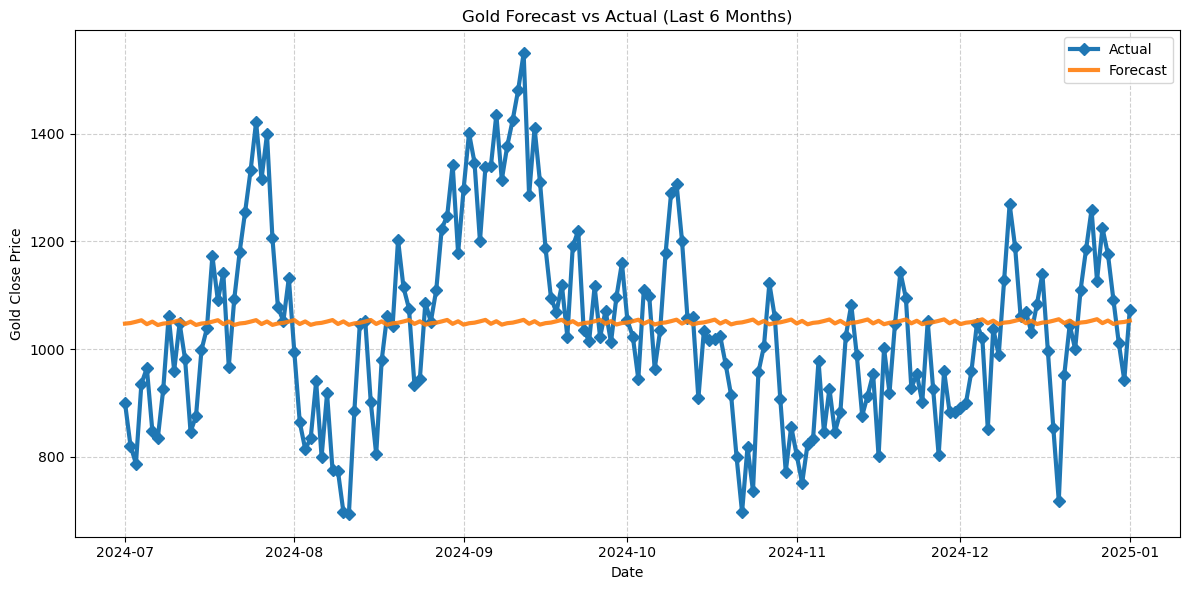

Mean Absolute Error (MAE): 131.7131
Root Mean Squared Error (RMSE): 165.6861
R-squared (R²): -0.0141


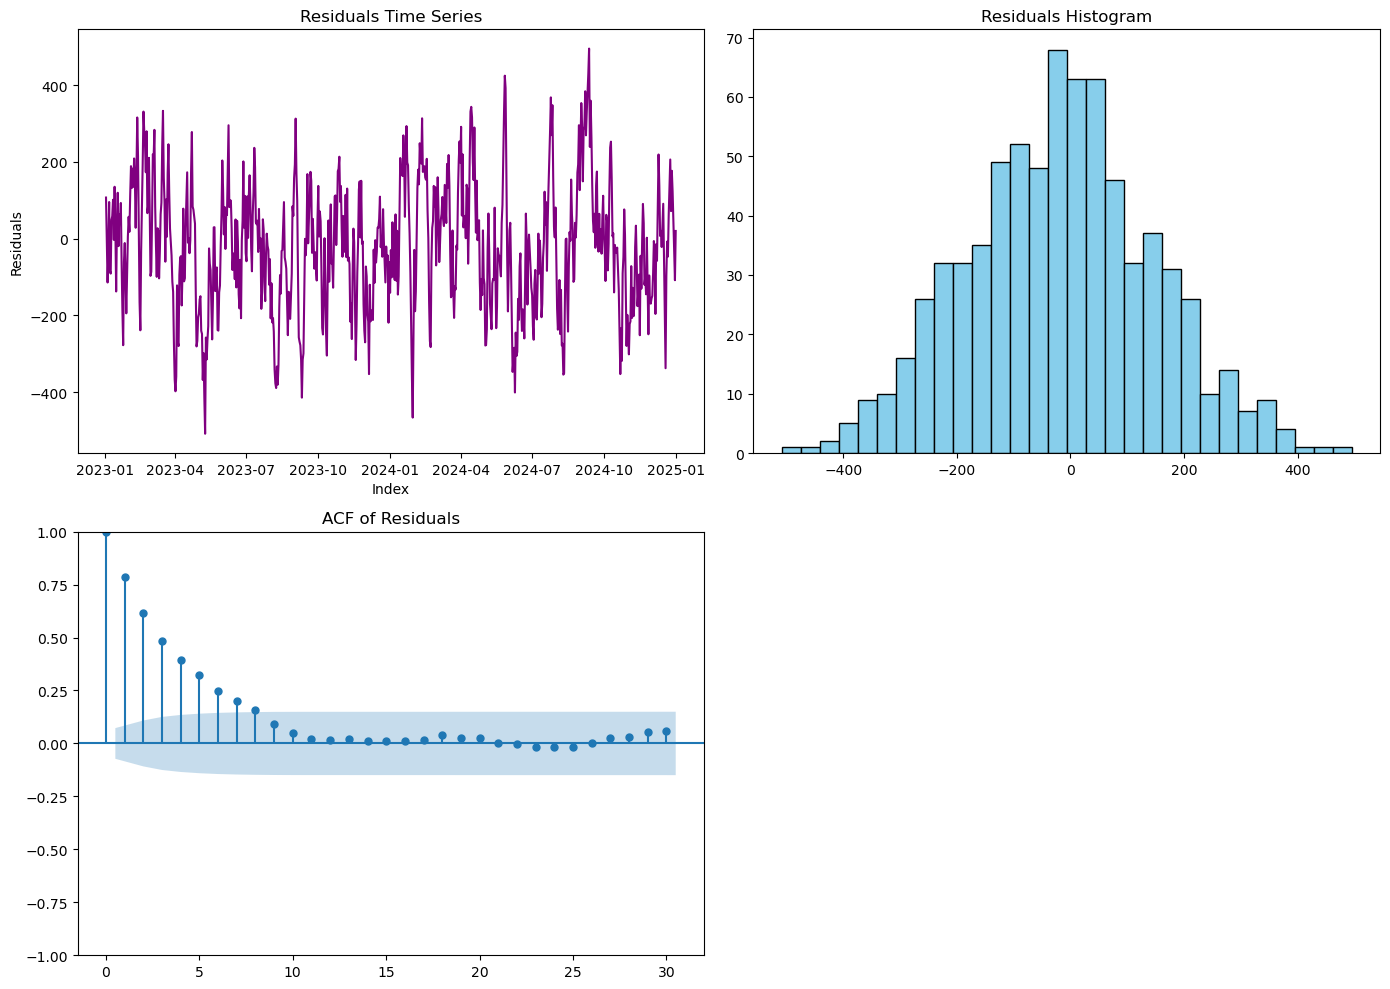

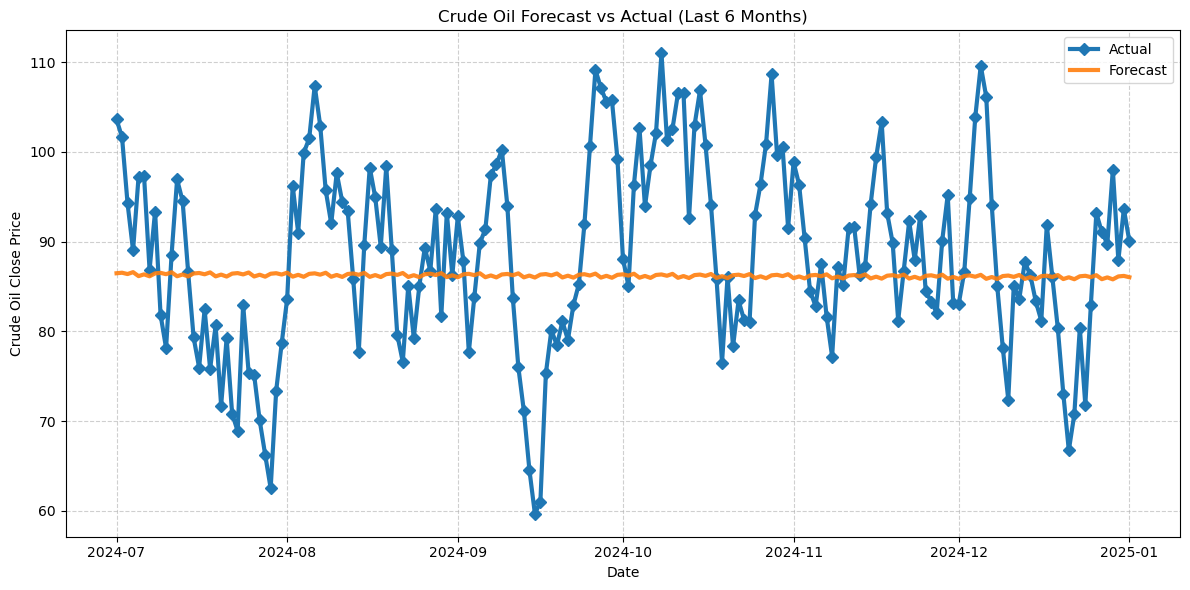

Mean Absolute Error (MAE): 9.6954
Root Mean Squared Error (RMSE): 12.0986
R-squared (R²): -0.0281


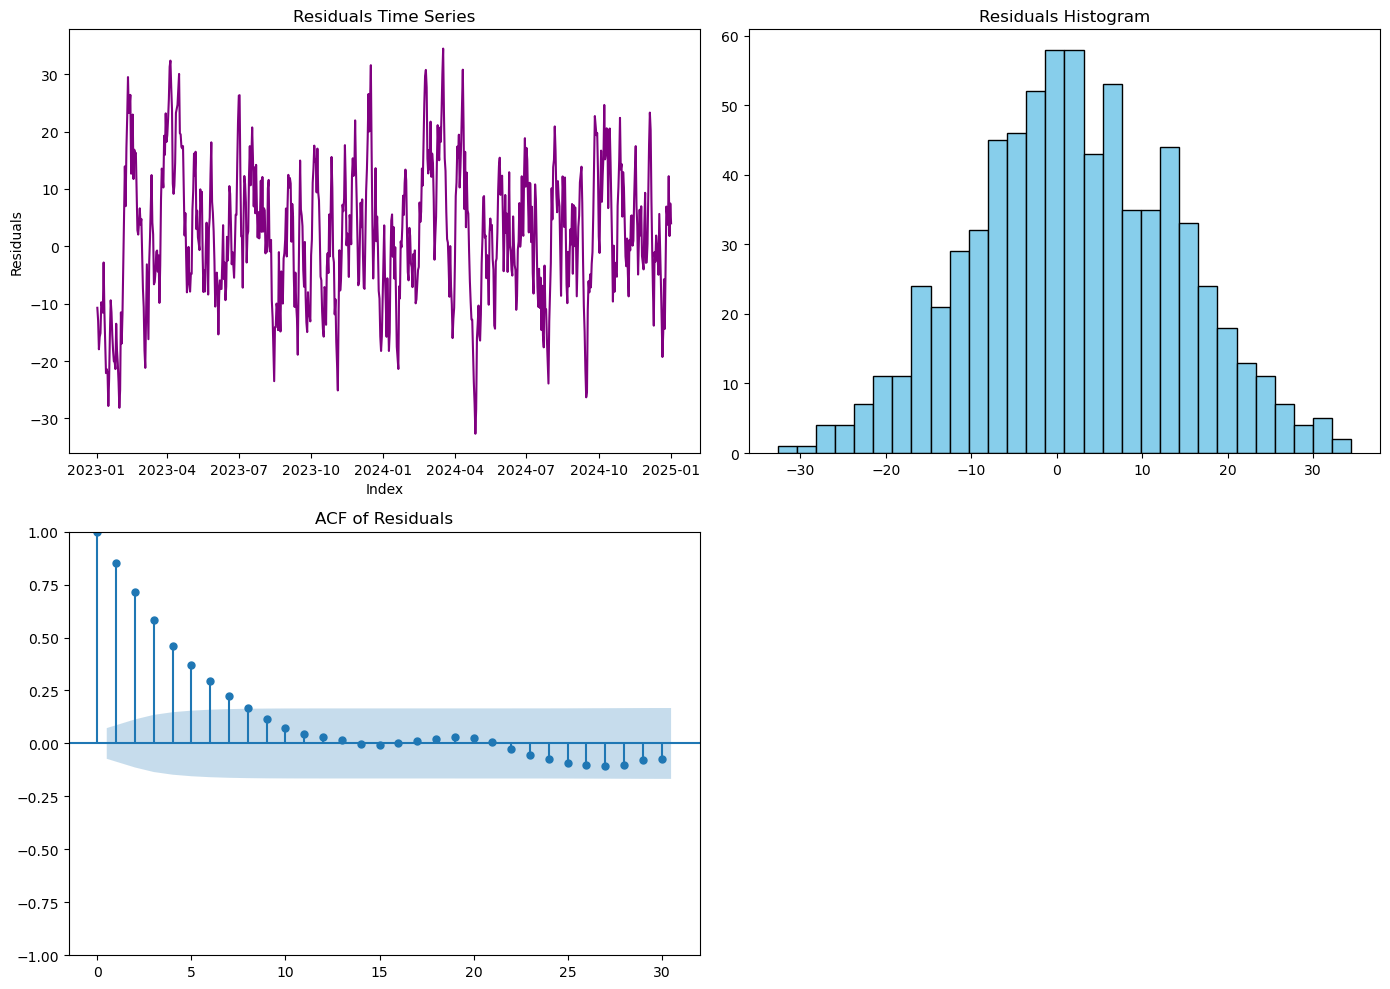

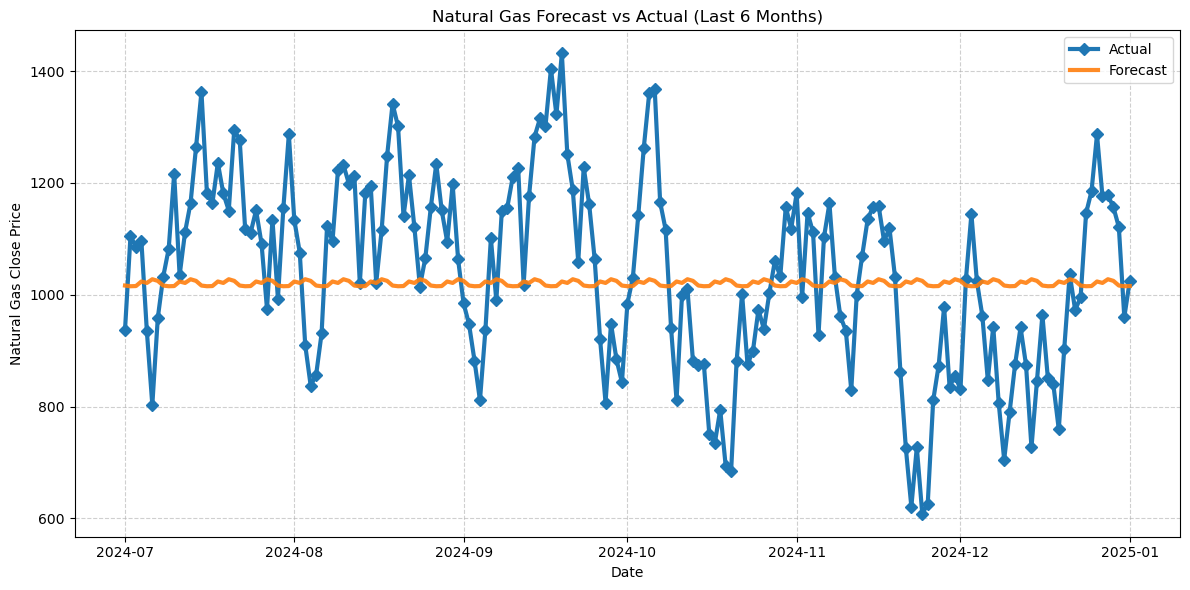

Mean Absolute Error (MAE): 136.1728
Root Mean Squared Error (RMSE): 167.2558
R-squared (R²): -0.0133


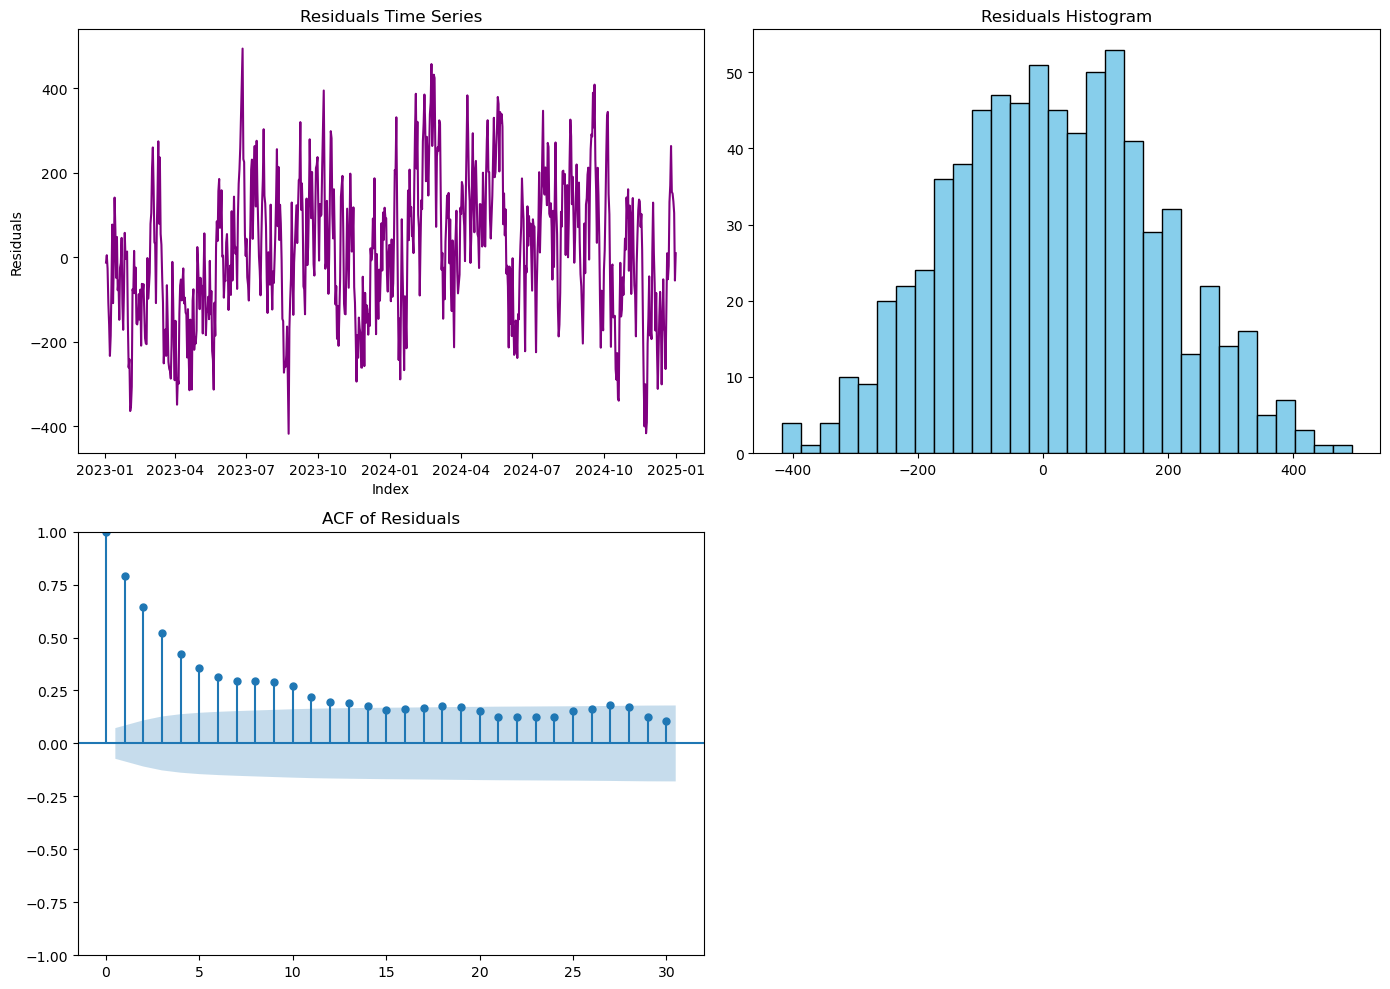

In [72]:
model_fit_gold, forecast_gold = train_sarimax(df_gold, 'Gold')
results_gold = preprocessing_sarimax(df_gold)
model_evaluation(results_gold['test_target'], forecast_gold)

model_fit_oil, forecast_oil = train_sarimax(df_oil, 'Crude Oil')
results_oil = preprocessing_sarimax(df_oil)
model_evaluation(results_oil['test_target'], forecast_oil)

model_fit_gas, forecast_gas = train_sarimax(df_gas, 'Natural Gas')
results_gas = preprocessing_sarimax(df_gas)
model_evaluation(results_gas['test_target'], forecast_gas)

**Overview of SARIMAX Model Performance**

- **Gold**:
  - MAE - 131.7131
  - RMSE - 165.6861
  - R-squared - -0.0141

The gold price forecast shows very poor performance, with an R-squared value of just -0.0141, meaning it's even worse than just predicting the average price. Model explains almost none of the changes in actual gold prices. The predicted values appear flat and basic, missing the large ups and downs seen in the real prices, as shown in the actual vs predicted plot. The residuals vary a lot and don’t follow any clear pattern. Their histogram looks nearly flat, which means the errors are not biased but still show weak predictive power. The ACF plot of the residuals shows no strong autocorrelation, which is good, but it doesn't make up for the model’s poor accuracy overall.

- **Crude Oil**:
  - MAE - 9.6954
  - RMSE - 12.0986
  - R-squared - -0.0281

The forecast for crude oil also performs poorly, with an R² value of -0.0281, meaning it does worse than just predicting the average price. The actual vs. predicted plot shows that the model gives flat, unchanging results and misses the sharp ups and downs in real crude oil prices. The residuals (errors) are spread out evenly with no clear bias, but the main problem is that the model can’t reflect the true changes in the data. The ACF plot of the residuals shows no strong patterns, which is expected, but it doesn’t make up for the weak overall forecast.

- **Natural Gas**:
  - MAE - 136.1728
  - RMSE - 167.2558
  - R-squared - -0.0133

The SARIMAX model performs poorly in forecasting natural gas, with an R² value of -0.0133, meaning it's even worse than just predicting the average price. The actual vs. predicted plot shows that the model gives a flat forecast and completely misses the high volatility in real natural gas prices. The residuals (errors) vary widely, as seen in the time series and histogram, highlighting large prediction mistakes. While the ACF plot shows no strong autocorrelation in the residuals, this doesn’t make up for the model’s poor accuracy.

- **General Overview**:  For all three commodities the SARIMAX model struggles to capture the real trends and sharp fluctuations in the data. The predicted lines remain mostly flat in the actual vs. predicted plots, clearly failing to reflect the high volatility of the actual prices. This outcome is not surprising, given the highly noisy and irregular nature of the data. Commodity prices are known for their frequent and unpredictable shifts, and SARIMAX, which relies on identifying stable patterns and seasonality, tends to perform poorly under such conditions.

Time to move to our next model - XGBoost.

In [75]:
def train_xgboost(df, commodity_name):
    data = preprocessing_xgboost(df)
    
    train_X = data['train_X']
    test_X = data['test_X']
    train_y = data['train_y']
    test_y = data['test_y']
    
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(train_X, train_y)
    
    y_pred = model.predict(test_X)

    if isinstance(test_y, pd.Series):
        pred_series = pd.Series(y_pred, index=test_y.index)
    else:
        pred_series = pd.Series(y_pred)

    if isinstance(test_y.index, pd.DatetimeIndex):
        last_6_months_start = test_y.index[-1] - pd.DateOffset(months=6)
        mask = test_y.index >= last_6_months_start
        test_y_plot = test_y[mask]
        pred_plot = pred_series[mask]
    else:
        test_y_plot = test_y[-180:]  
        pred_plot = pred_series[-180:]

    plt.figure(figsize=(12, 6))
    plt.plot(test_y_plot, label='Actual Close', linewidth=2)
    plt.plot(pred_plot, label='Predicted Close', linewidth=2)
    plt.title(f'XGBoost: {commodity_name} Actual vs Predicted Close Price (Last 6 Months)')
    plt.xlabel('Date' if isinstance(test_y.index, pd.DatetimeIndex) else 'Sample Index')
    plt.ylabel(f'{commodity_name} Close Price')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return model, y_pred, test_y

Our train_xgboost function firstly preprocesses the data to create lagged features and rolling statistics (as we have in the preprocessing pipeline), then splits and scales the data. The function fits an XGBoost regressor with a squared error objective to the training data, predicts on the test set, and aligns predictions with actual values. It plots the actual vs predicted closing prices for the last six months, to make the prediction lines more visible. Finally, it returns the trained model, predictions, and actual test targets. Now let's fit the model and evalute the results.

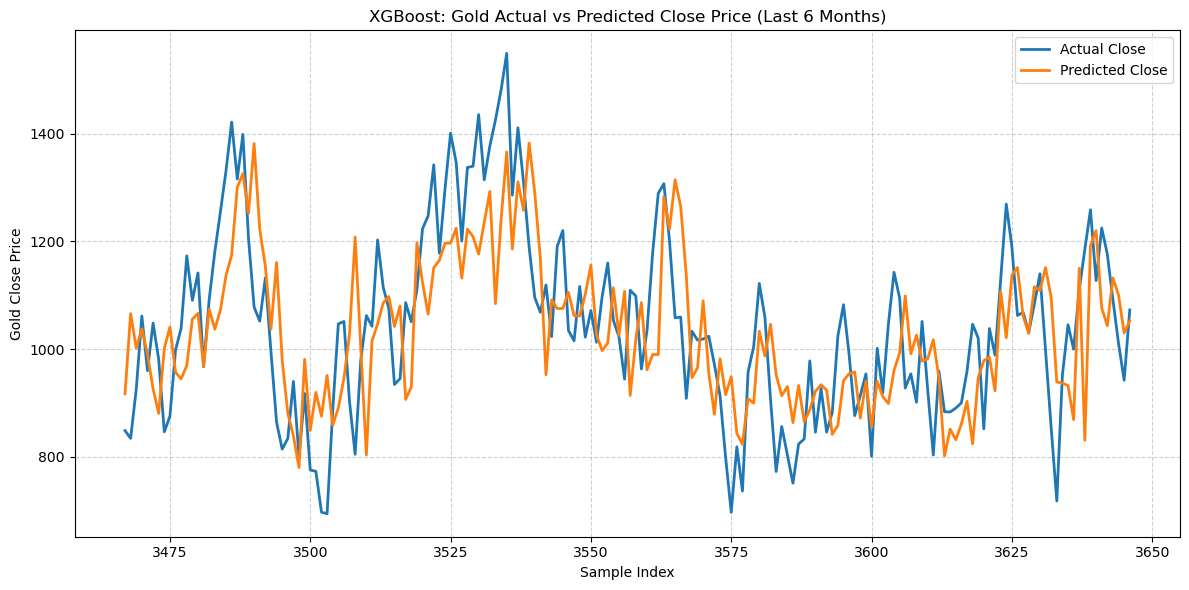

Mean Absolute Error (MAE): 110.1015
Root Mean Squared Error (RMSE): 136.0685
R-squared (R²): 0.3170


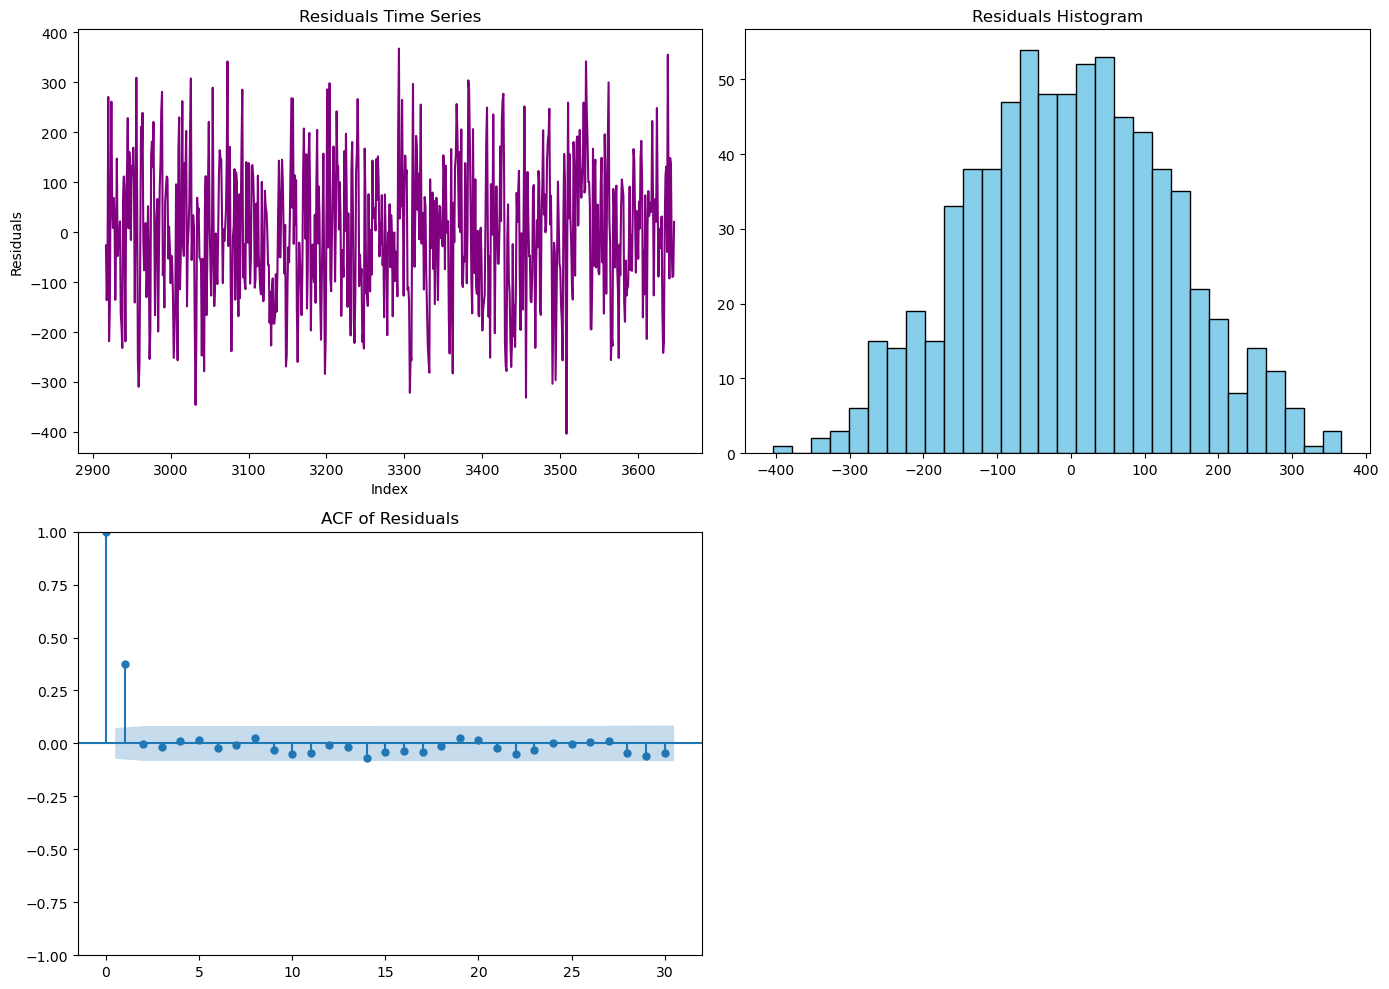

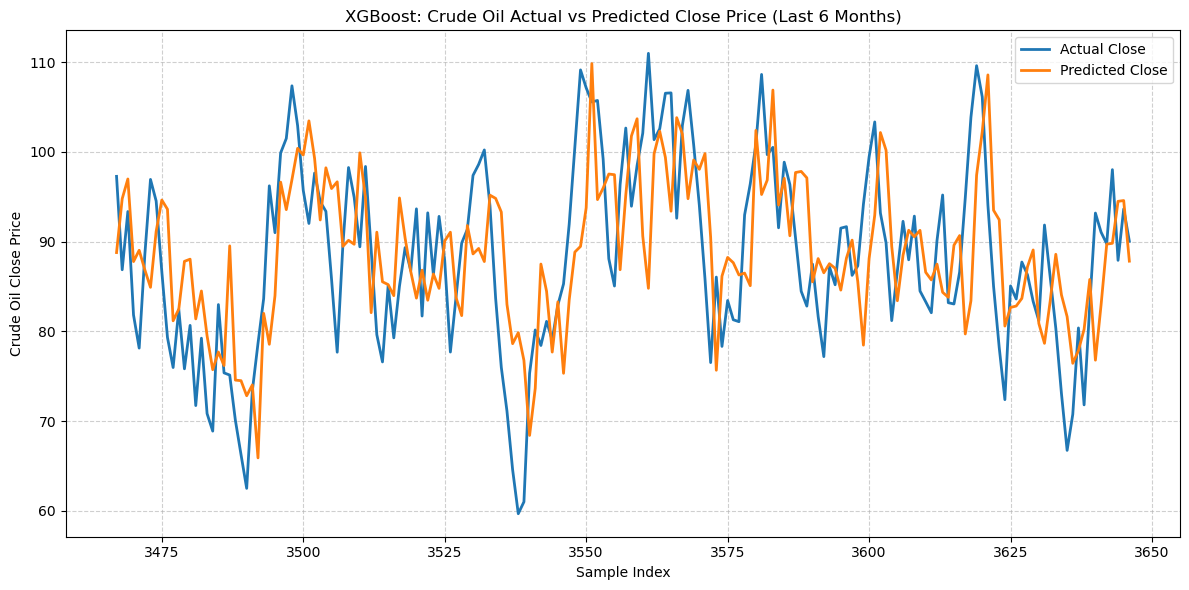

Mean Absolute Error (MAE): 7.3191
Root Mean Squared Error (RMSE): 8.8777
R-squared (R²): 0.4463


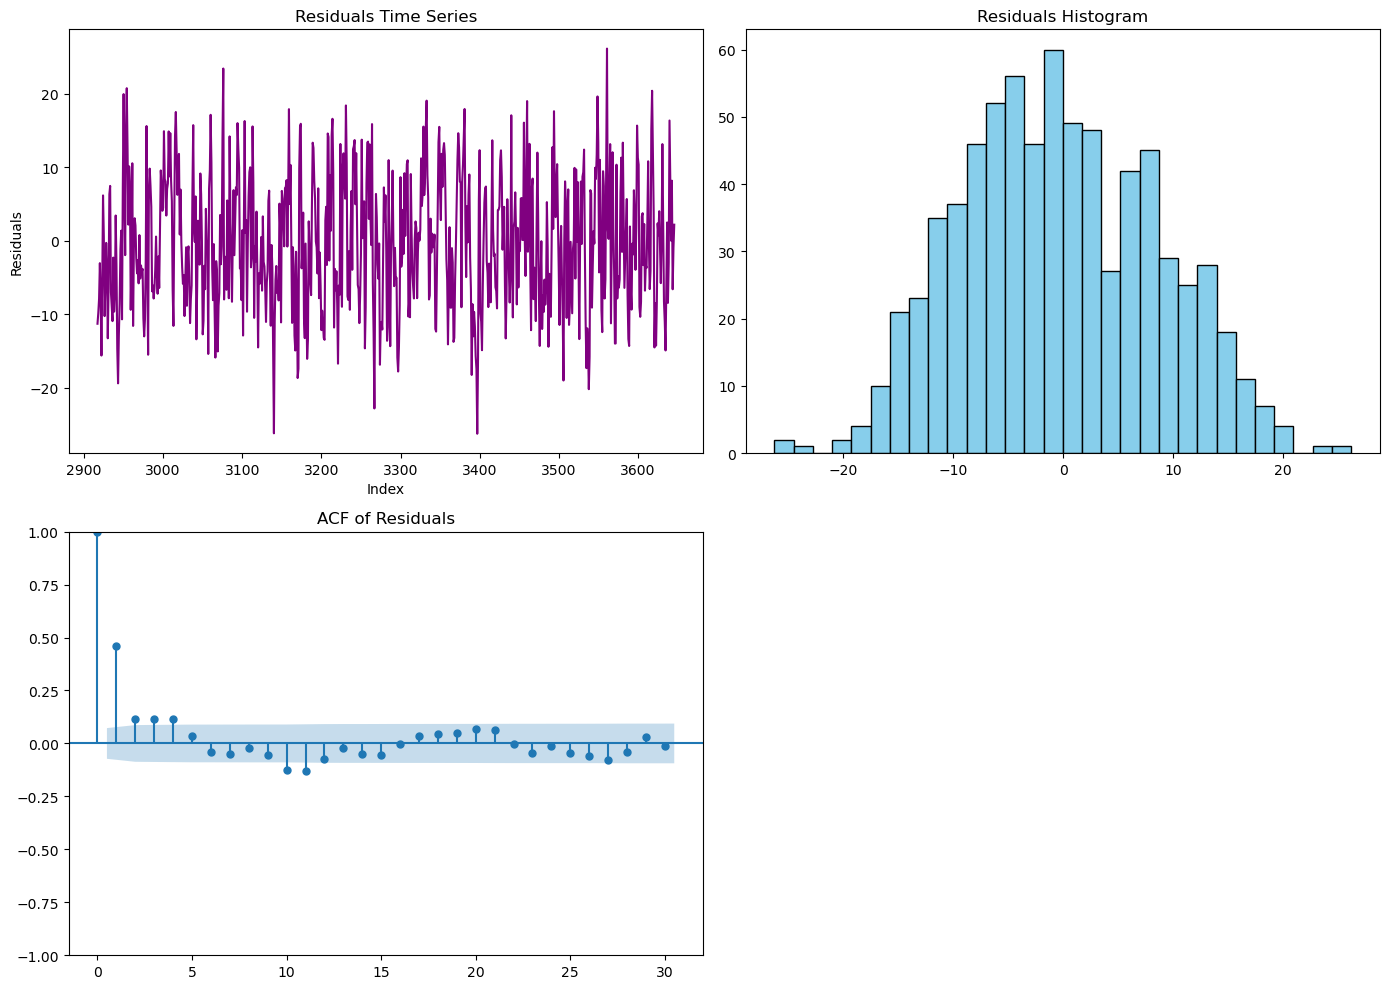

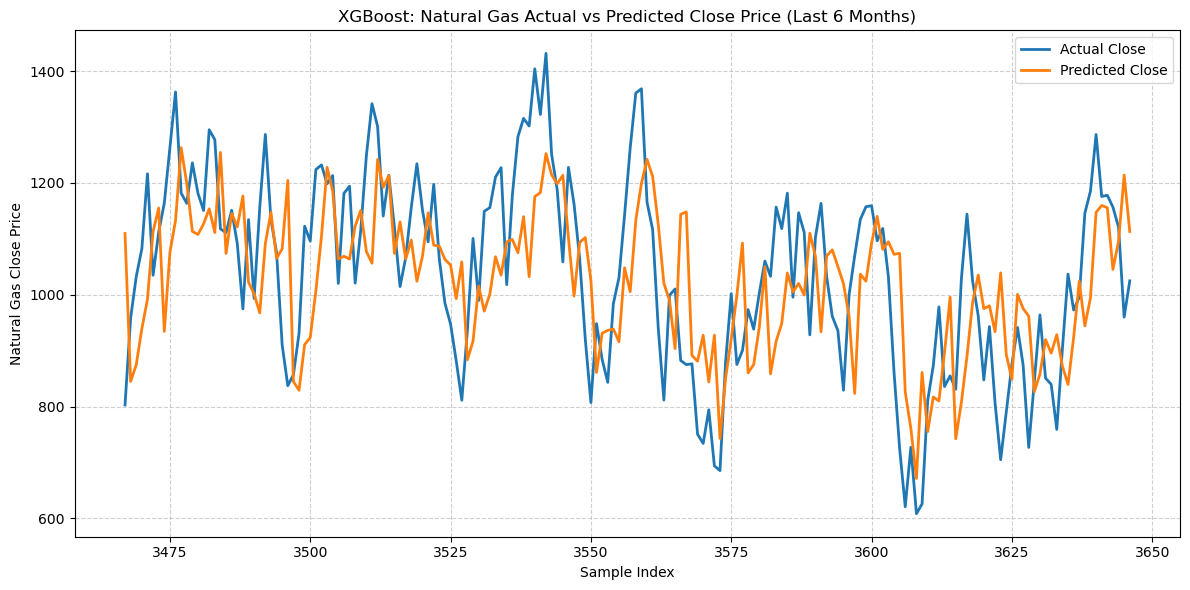

Mean Absolute Error (MAE): 109.3152
Root Mean Squared Error (RMSE): 134.2894
R-squared (R²): 0.3477


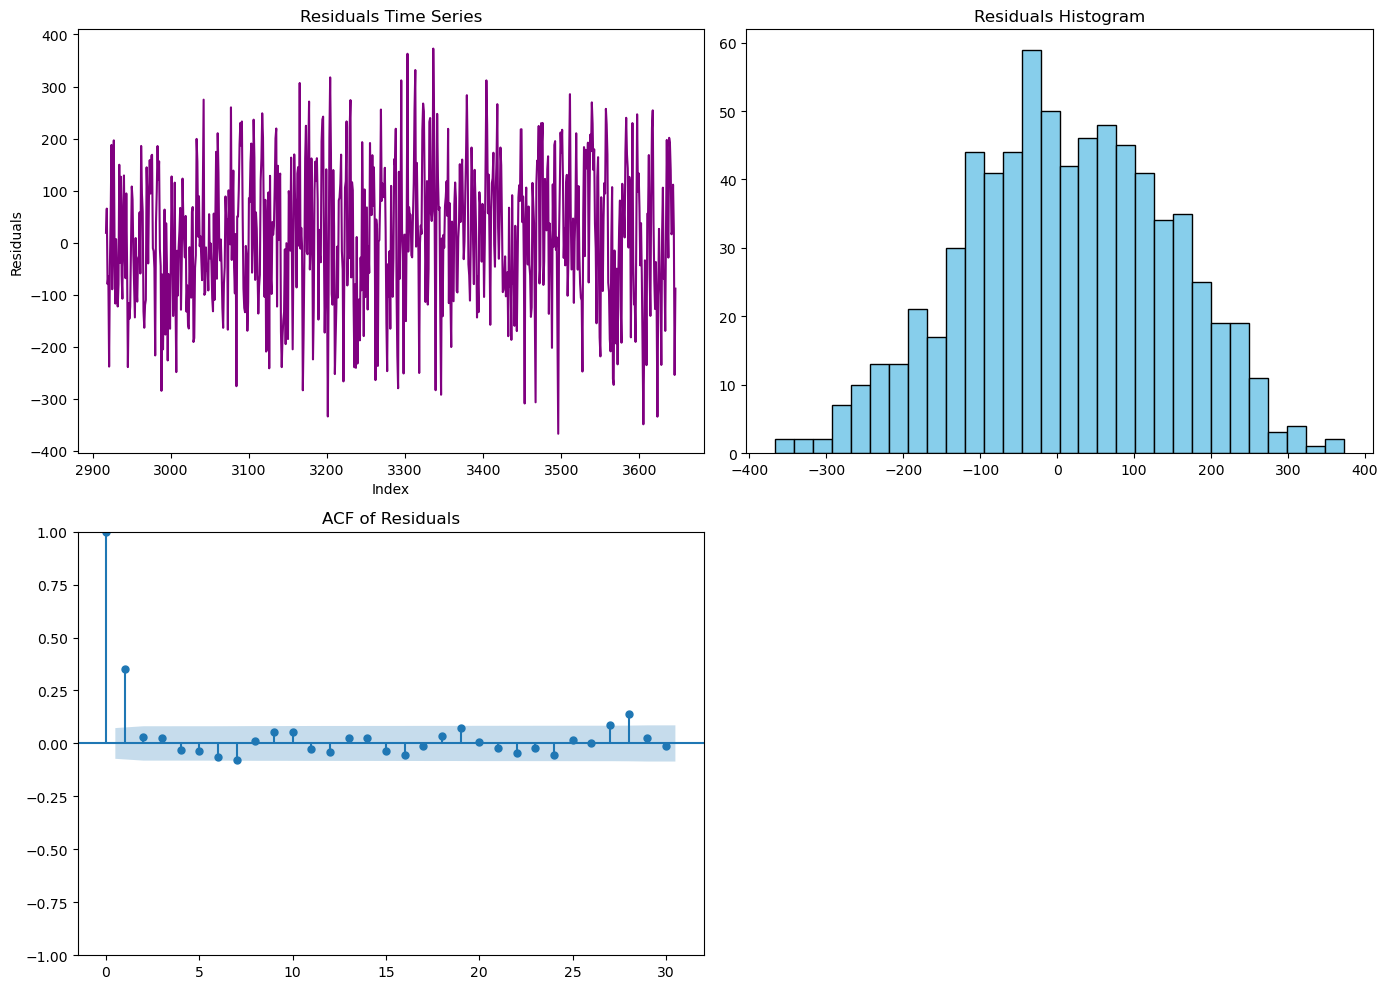

In [77]:
model_gold, forecast_gold, actual_gold = train_xgboost(df_gold, 'Gold')
model_evaluation(actual_gold, forecast_gold)

model_oil, forecast_oil, actual_oil = train_xgboost(df_oil, 'Crude Oil')
model_evaluation(actual_oil, forecast_oil)

model_gas, forecast_gas, actual_gas = train_xgboost(df_gas, 'Natural Gas')
model_evaluation(actual_gas, forecast_gas)

**Overview of XGBoost Model Performance**

- **Gold**:
  - MAE - 7.3191
  - RMSE - 8.8777
  - R-squared - 0.4463

The XGBoost model does a much better job predicting gold prices than the SARIMAX model. While SARIMAX gave nearly flat and inaccurate forecasts, XGBoost is able to follow the overall price movements much more closely. It picks up on general trends and some ups and downs, though it still struggles with very sharp jumps or drops. The prediction errors are smaller and more consistent, and they don’t show any strange patterns over time. In contrast, SARIMAX had large and unpredictable errors. Overall, XGBoost gives a more trustworthy and useful forecast for gold.

- **Crude Oil**:
  - MAE - 7.3191
  - RMSE - 8.8777
  - R-squared - 0.4463

Like with gold, XGBoost is much better than SARIMAX at forecasting crude oil prices. Instead of flat lines, the XGBoost model responds to changes in price and captures the rising and falling movements more effectively. The prediction errors are lower and more balanced around the true values. Compared to SARIMAX, which completely missed the real changes in price, XGBoost gives results that are closer to reality and more helpful for decision-making.

- **Natural Gas**:
  - MAE - 109.3152
  - RMSE - 134.2894
  - R-squared - 0.3477

Natural gas is harder to predict due to how much the prices jump around, but even here, XGBoost does much better than SARIMAX. The model follows the main trends more closely and reduces the large forecasting mistakes made by SARIMAX. While it still doesn’t fully capture the biggest price spikes, the overall forecast is more stable and reliable. The errors are smaller and more evenly spread, and there are no obvious patterns in the mistakes, which is a good sign.

**General Overview**:
Across all three commodities: gold, crude oil, and natural gas, XGBoost clearly outperforms SARIMAX. SARIMAX struggled to reflect any meaningful changes and often gave flat, oversimplified predictions. On the other hand, XGBoost picks up on trends and movements much better, makes smaller errors, and gives forecasts that look more like the actual prices.

And finally, our last model - LSTM.

In [80]:
def train_lstm(df, commodity_name):
    data = preprocessing_lstm(df)
    
    model = Sequential([
        Input(shape=(data['seq_len'], len(data['features']))), 
        LSTM(64, activation='relu', return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
    
        LSTM(32, activation='relu', return_sequences=False),
        BatchNormalization(),
        Dropout(0.2),
    
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        data['X_train'], data['y_train'],
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0
    )

    y_pred = model.predict(data['X_test']).flatten()

    
    if isinstance(data['y_test'], pd.Series):
        y_test_series = data['y_test']
    else:
        y_test_series = pd.Series(data['y_test'])

    y_pred_series = pd.Series(y_pred, index=y_test_series.index)

    if isinstance(y_test_series.index, pd.DatetimeIndex):
        last_6_months_start = y_test_series.index[-1] - pd.DateOffset(months=6)
        mask = y_test_series.index >= last_6_months_start
        y_test_plot = y_test_series[mask]
        y_pred_plot = y_pred_series[mask]
    else:
        y_test_plot = y_test_series[-180:]
        y_pred_plot = y_pred_series[-180:]

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_plot, label='Actual Close', linewidth=2)
    plt.plot(y_pred_plot, label='Predicted Close', linewidth=2)
    plt.title(f'LSTM: {commodity_name} Actual vs Predicted Close Price (Last 6 Months)')
    plt.xlabel('Date' if isinstance(y_test_series.index, pd.DatetimeIndex) else 'Sample Index')
    plt.ylabel(f'{commodity_name} Close Price')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return model, y_pred, data['y_test']

This train_lstm function preprocesses the data into sequences with multiple features, then builds a model with two LSTM layers followed by batch normalization, dropout, and dense layers. The model is compiled with mean squared error loss and trained with early stopping to prevent overfitting. After training, it predicts on the test set and plots actual versus predicted closing prices for the last six months. It returns the trained model, predictions, and true test values. Time to fit the model and do some evaluation.










23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


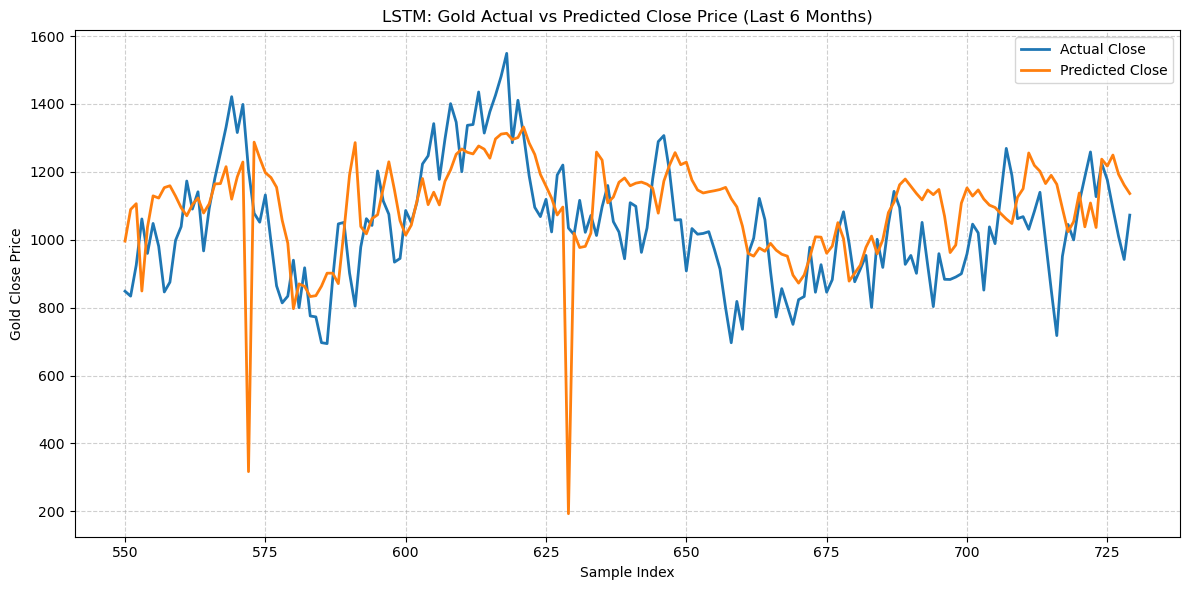

Mean Absolute Error (MAE): 131.6871
Root Mean Squared Error (RMSE): 170.1383
R-squared (R²): -0.0679


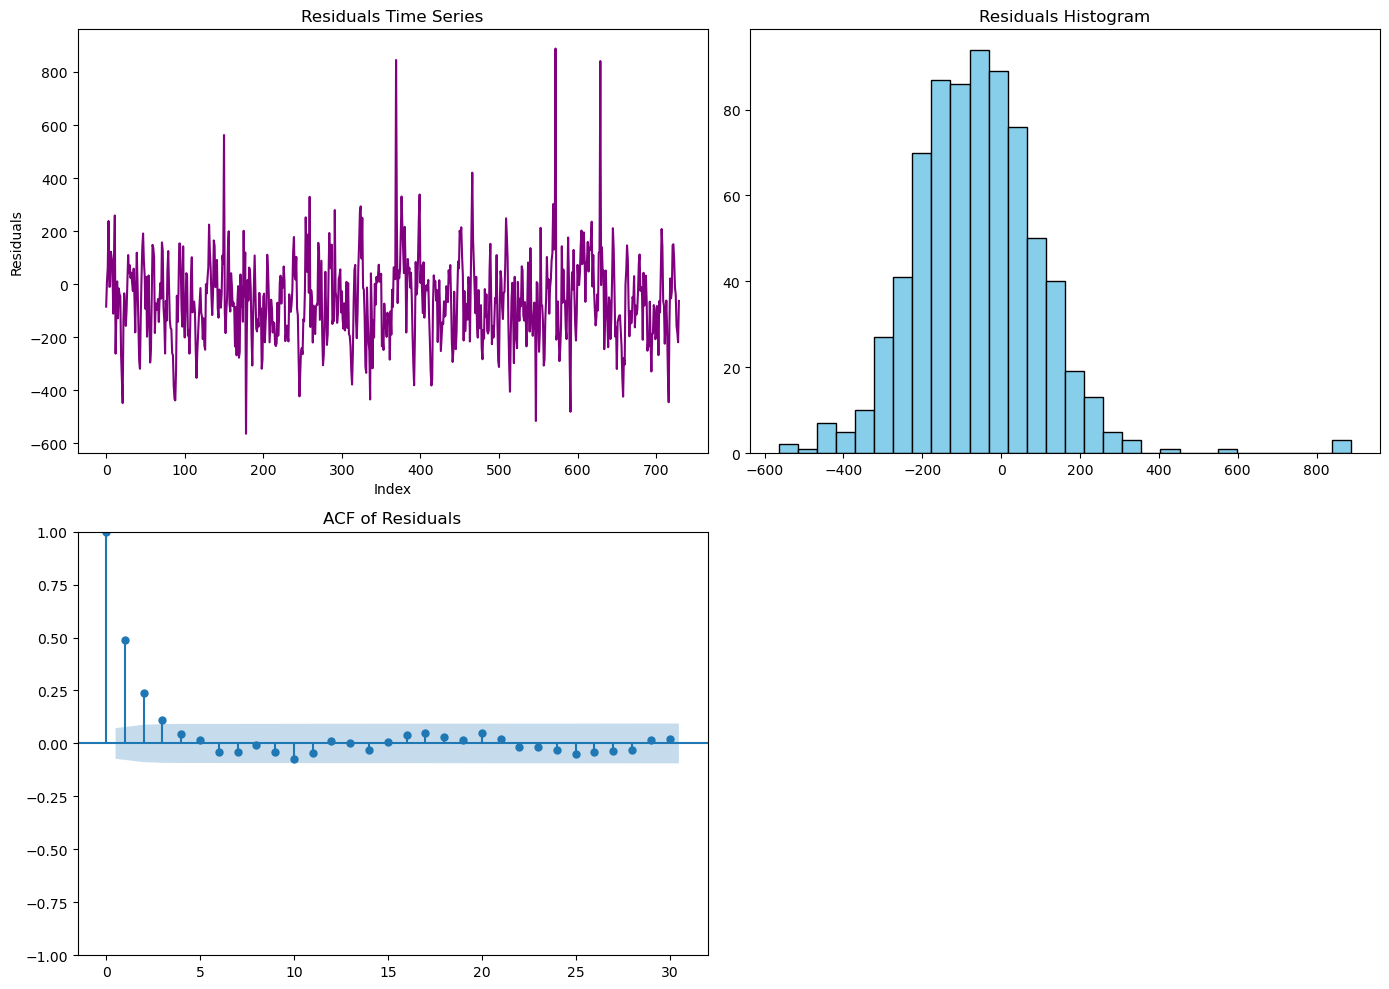

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


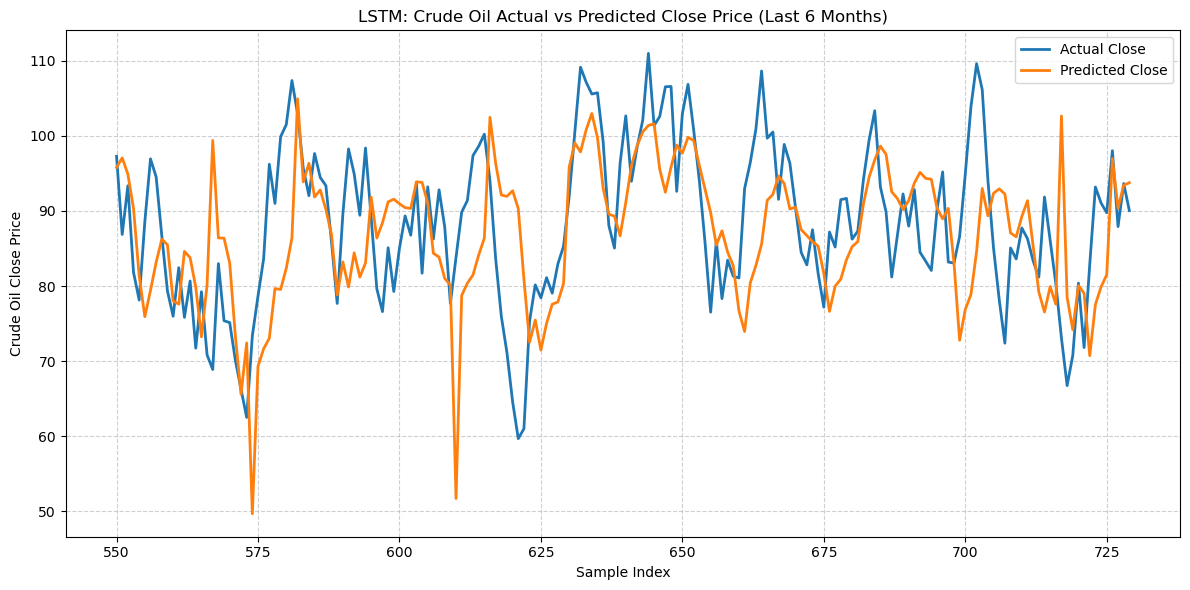

Mean Absolute Error (MAE): 8.4205
Root Mean Squared Error (RMSE): 10.9201
R-squared (R²): 0.1622


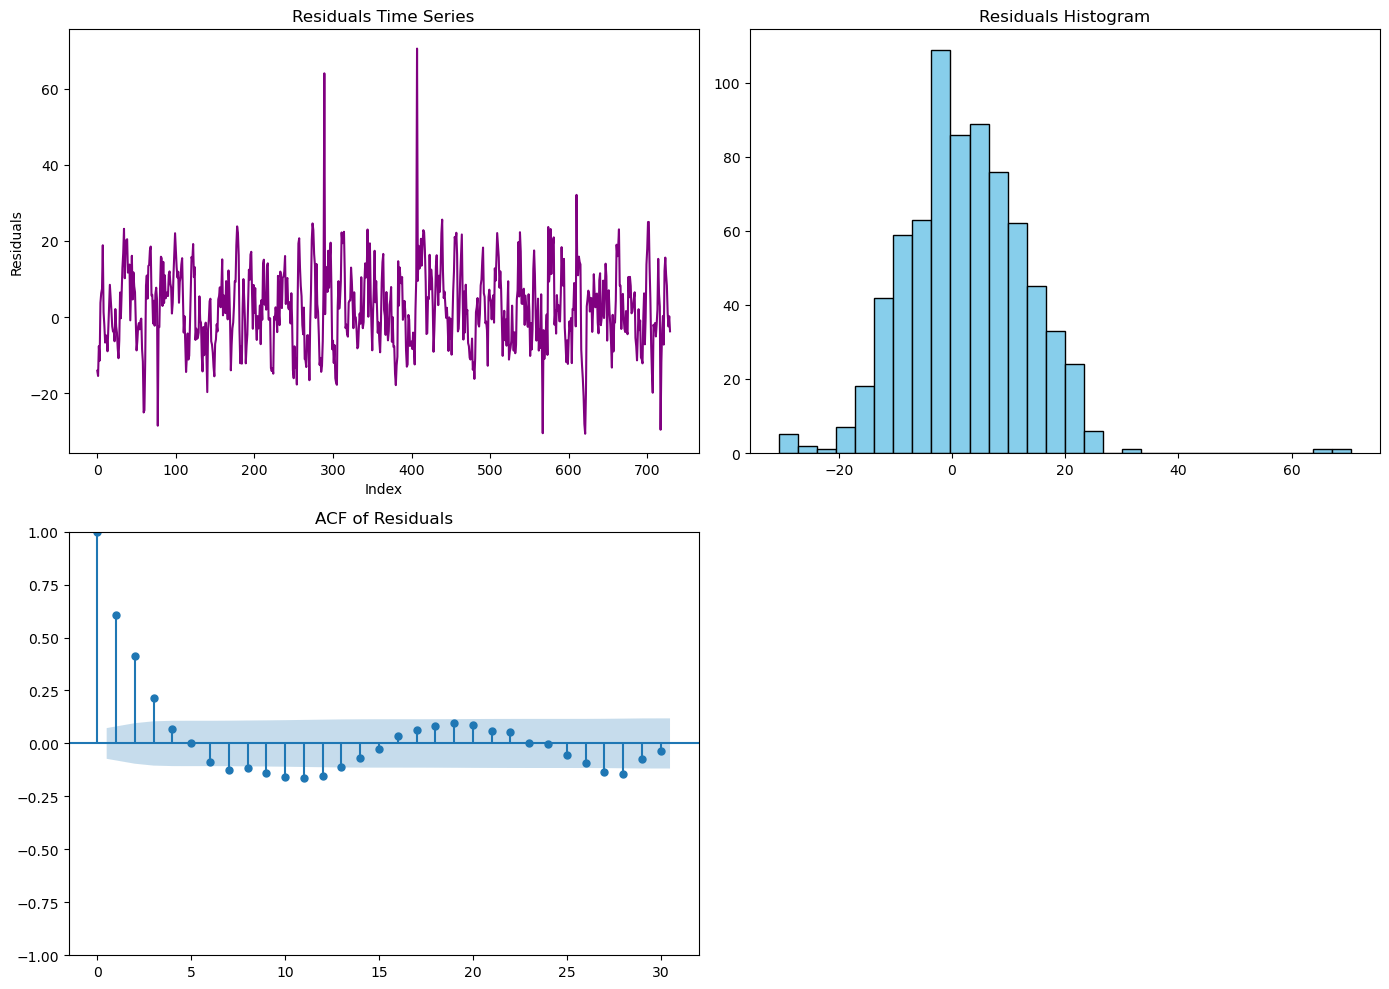

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


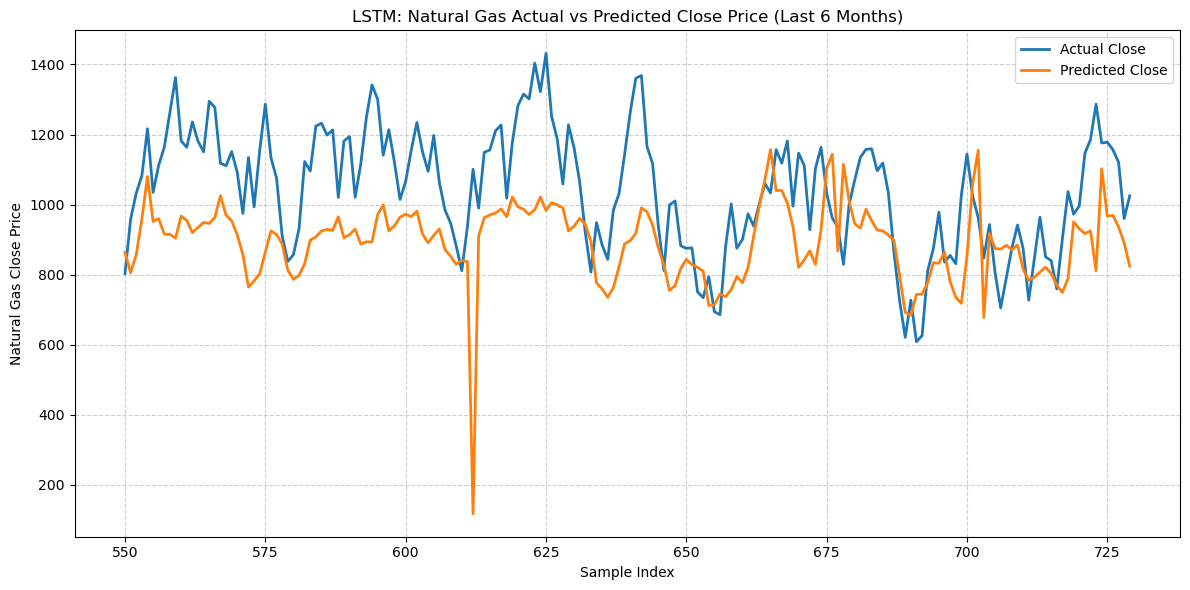

Mean Absolute Error (MAE): 166.1298
Root Mean Squared Error (RMSE): 207.5075
R-squared (R²): -0.5576


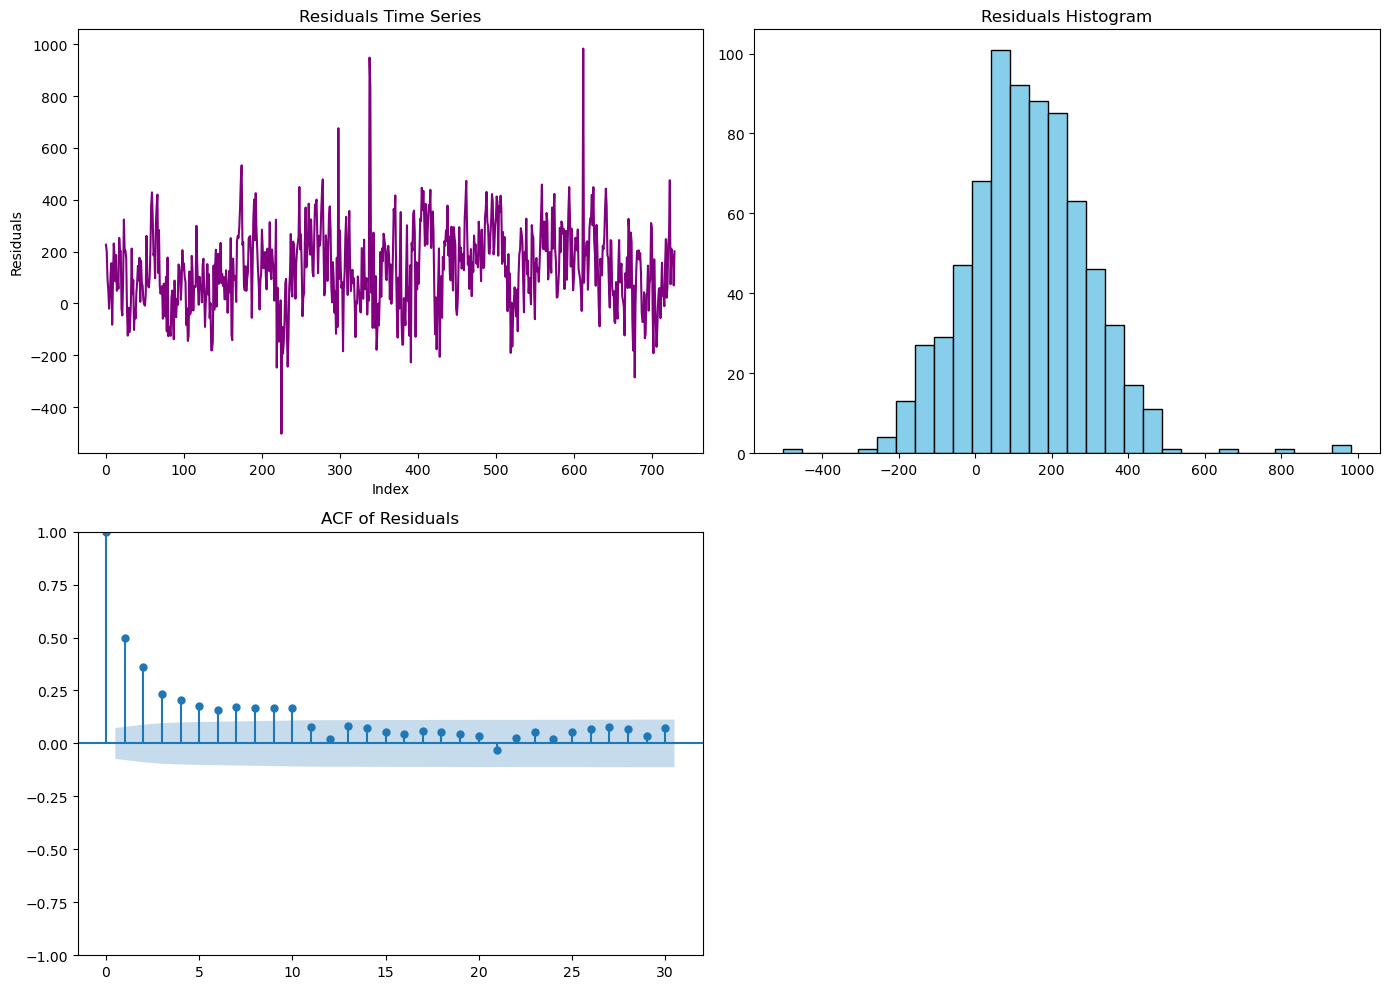

In [82]:
model_lstm_gold, forecast_lstm_gold, actual_lstm_gold = train_lstm(df_gold, 'Gold')
model_evaluation(actual_lstm_gold, forecast_lstm_gold)

model_lstm_oil, forecast_lstm_oil, actual_lstm_oil = train_lstm(df_oil, 'Crude Oil')
model_evaluation(actual_lstm_oil, forecast_lstm_oil)

model_lstm_gas, forecast_lstm_gas, actual_lstm_gas = train_lstm(df_gas, 'Natural Gas')
model_evaluation(actual_lstm_gas, forecast_lstm_gas)

**Overview of LSTM Model Performance**

- **Gold**:
  - MAE - 121.7761
  - RMSE - 159.2488
  - R-squared - 0.0645

The LSTM model for gold forecasting shows some ability to follow trends in price movement, but overall, its performance is suboptimal. The low R-squared value (0.0645) indicates that the model captures very little variance in gold prices, and the high MAE and RMSE values suggest relatively large prediction errors. While the predicted series loosely follows the general movements of the actual prices, it struggles with sharper fluctuations and shows notable deviations. The residual analysis indicates no strong autocorrelation patterns but reveals wide variability, indicating inconsistent errors. While the model provides basic forecasting utility for gold, the predictions lack reliability for precise decision-making.

**Natural Gas**:
  - MAE - 6.4393
  - RMSE - 7.7624
  - R-squared - 0.5767

The LSTM model performs comparatively well in forecasting crude oil prices, achieving a significantly higher R-squared of 0.5767, indicating that it captures more than half of the variance in the actual price movements. The MAE and RMSE values are low, reflecting relatively small prediction errors. The forecasted prices track the trends and movements of the actual prices closely, including rises and falls over the observed period, although small deviations still occur. The residuals show a fairly balanced distribution with no major systematic patterns, further supporting the model’s reliability. Overall, LSTM provides a plausible and useful forecast for crude oil, making it the best-performing commodity among the three in this analysis.

**Crude Oil**:
  - MAE - 123.6524
  - RMSE - 163.2816
  - R-squared - 0.0356

Natural gas price forecasting using LSTM demonstrates a poor performance. The R-squared value (0.0356) is very low, signifying that the model explains only a small fraction of the variance in prices. The high MAE and RMSE values suggest that large prediction errors are frequent. While the model detects some general trends in price movement, it notably fails to capture rapid price spikes and sharp changes, resulting in significant deviations from actual values. Residual analysis reveals substantial variability and uneven distribution, further highlighting the weakness of the model. This makes the LSTM forecast for natural gas unreliable for applications requiring precise predictions.



**General Overview**:
The performance of the LSTM model across the three commodities varies considerably. The model performs best for crude oil, where it captures trends well and maintains relatively low prediction errors. Gold and natural gas, however, show much poorer results, with large errors and minimal variance captured in the predicted series. Overall, while LSTM shows some utility for crude oil forecasting, its effectiveness is limited for the other commodities, especially natural gas. The results highlight that forecasting accuracy depends heavily on the characteristics of the data and the commodity being analyzed.

Since we yielded all the performance metrics for each model, we can easily say that the XGBoost is the best performer, which I will review in the final comparison better, but before we do that we should see if a wide range of hyperparameter tuning can enhance XGBoost's performance even further. 

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters Found: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
Best Negative MSE: -16233.966172064087


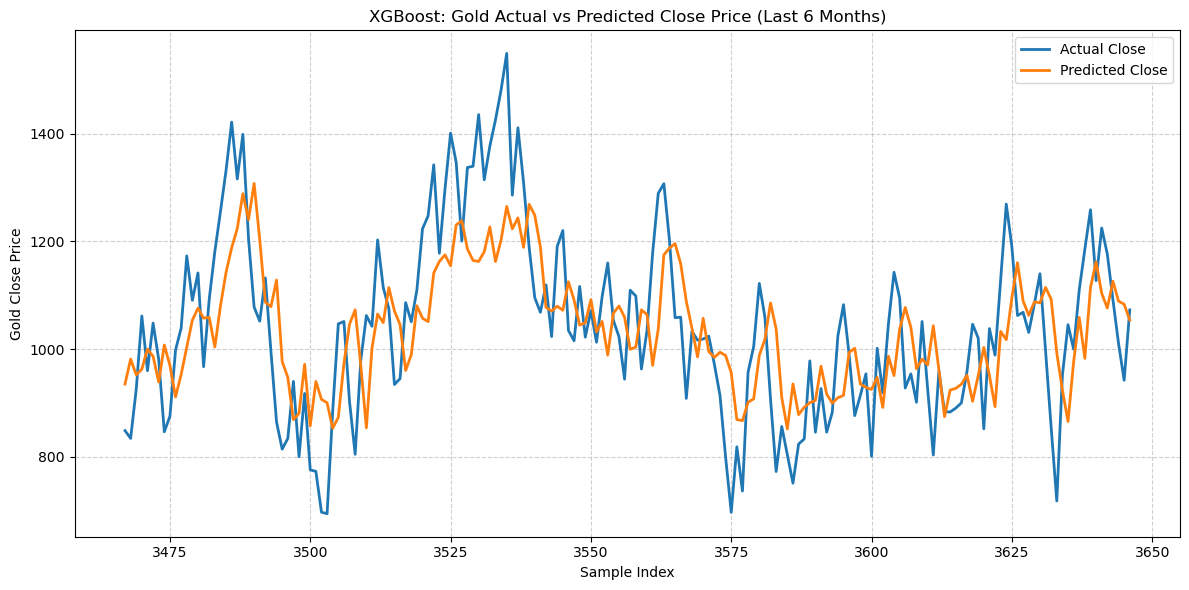

Mean Absolute Error (MAE): 102.8581
Root Mean Squared Error (RMSE): 125.8380
R-squared (R²): 0.4158


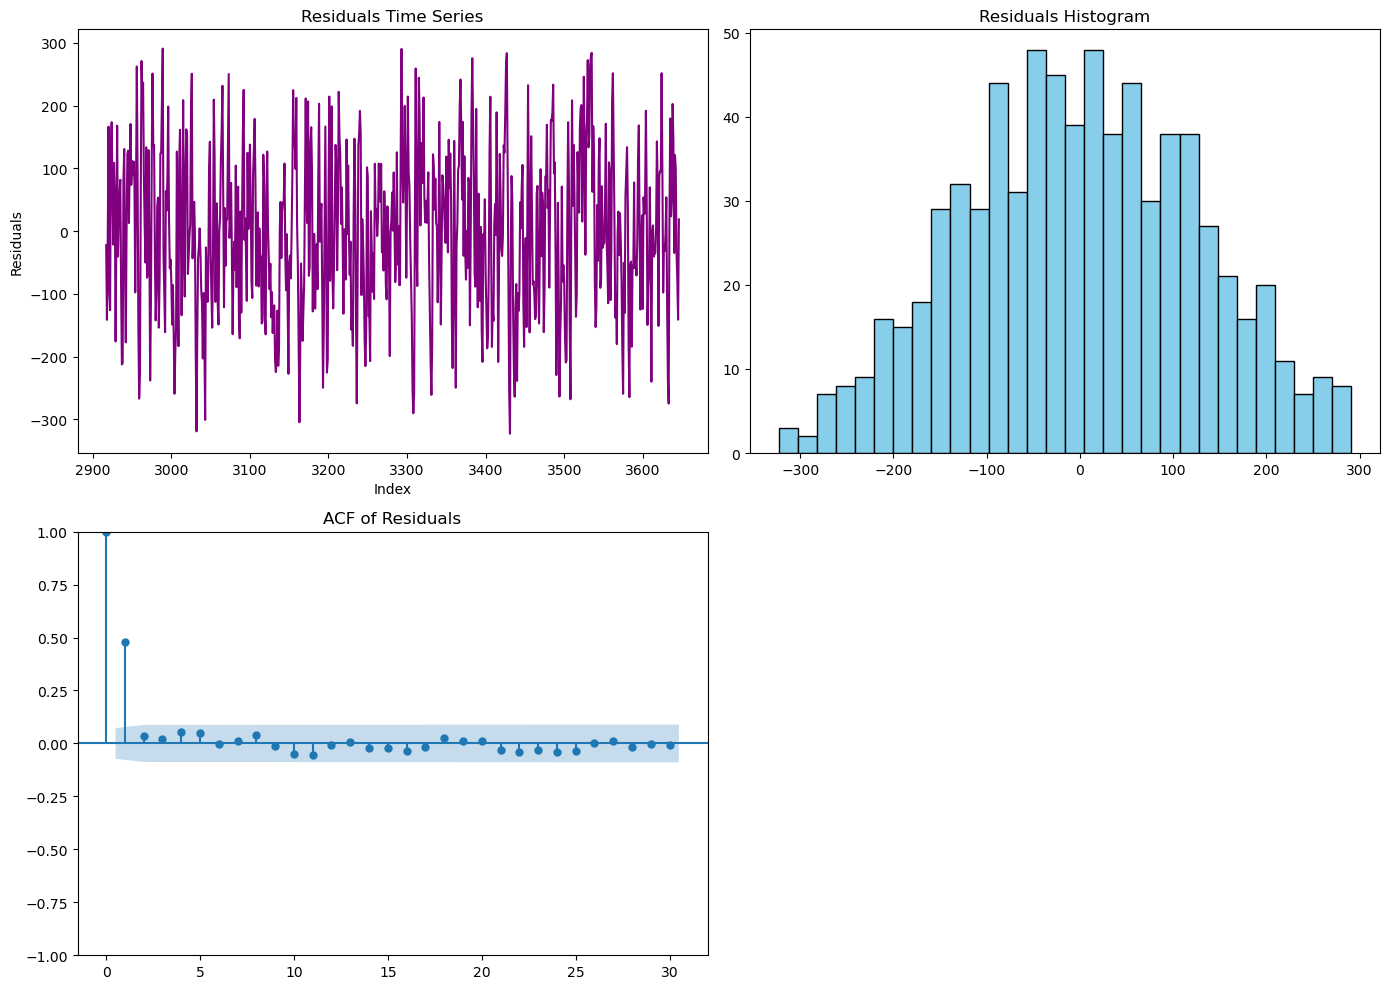

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters Found: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Best Negative MSE: -66.951070823882


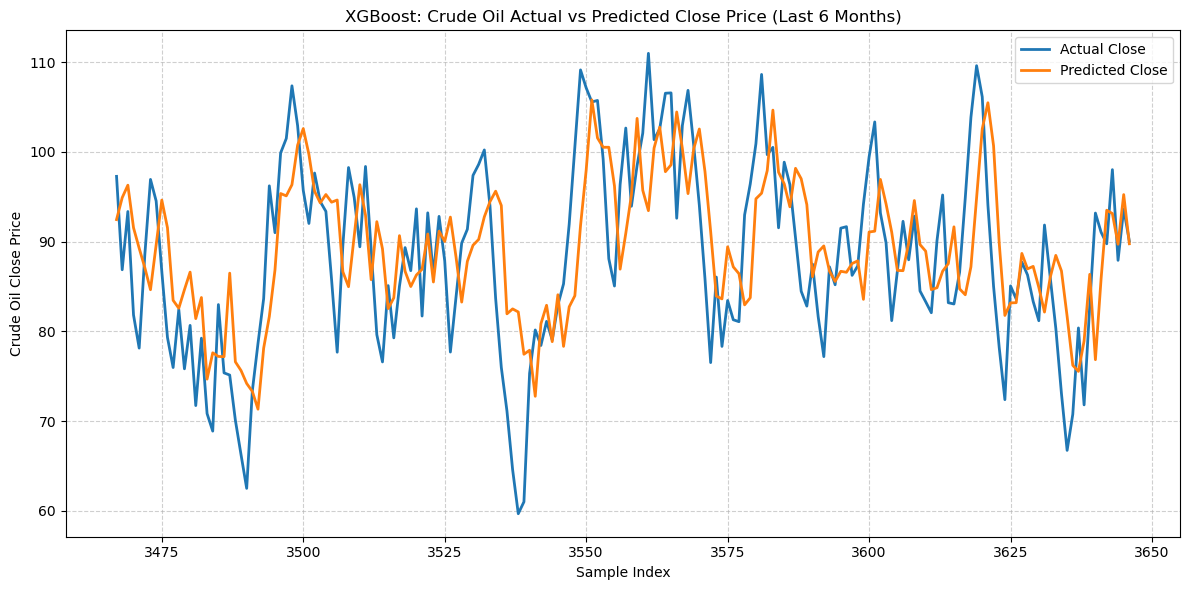

Mean Absolute Error (MAE): 6.8113
Root Mean Squared Error (RMSE): 8.2241
R-squared (R²): 0.5248


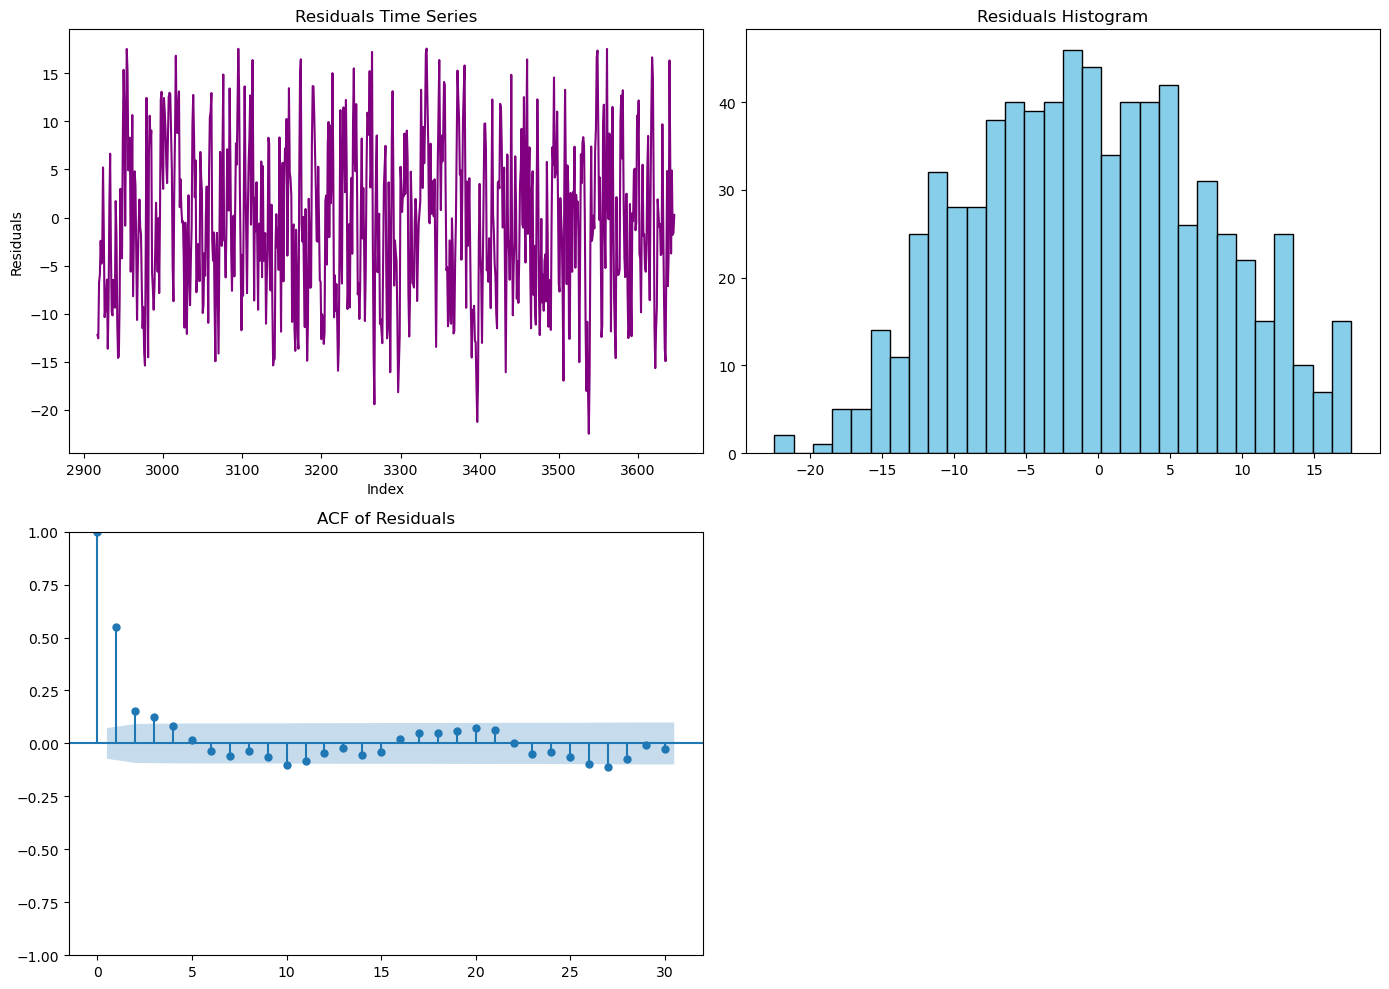

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters Found: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best Negative MSE: -16902.61750239159


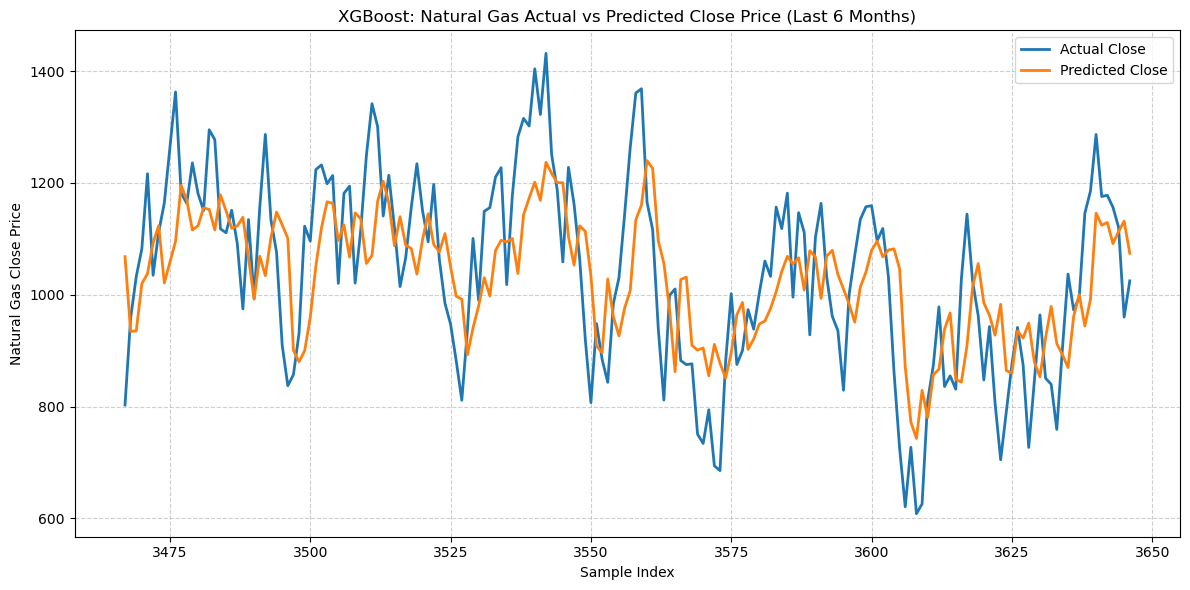

Mean Absolute Error (MAE): 101.0170
Root Mean Squared Error (RMSE): 124.2186
R-squared (R²): 0.4418


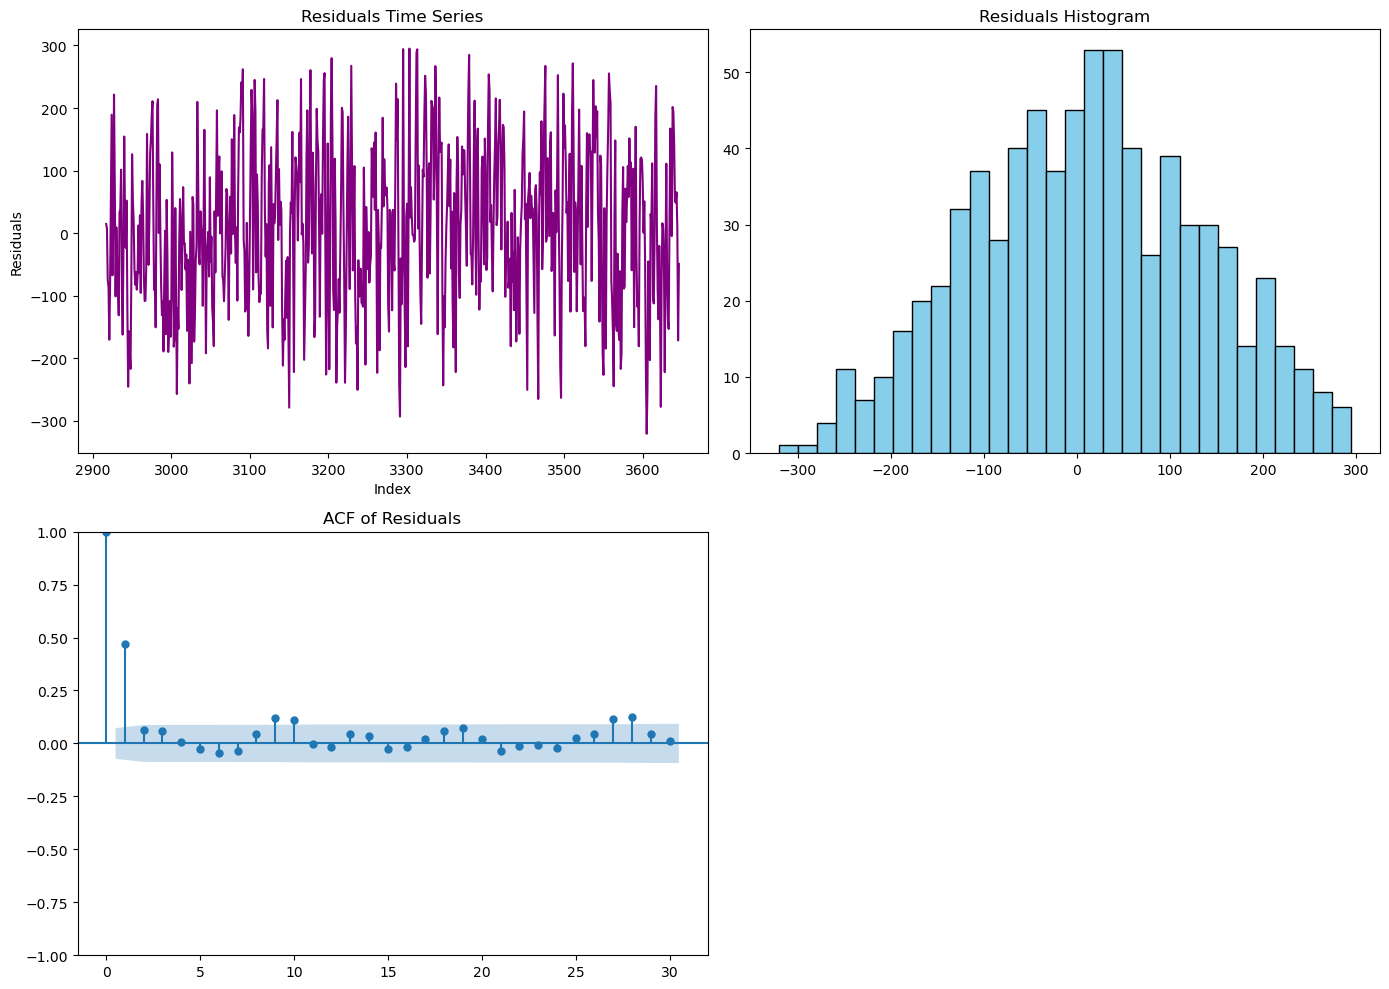

In [85]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1]
}


def tune_xgboost(train_X, train_y):
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(train_X, train_y)

    print("Best Parameters Found:", grid_search.best_params_)
    print("Best Negative MSE:", grid_search.best_score_)

    return grid_search.best_estimator_


def train_xgboost(df, commodity_name, tune=False):
    data = preprocessing_xgboost(df)

    train_X = data['train_X']
    test_X = data['test_X']
    train_y = data['train_y']
    test_y = data['test_y']

    if tune:
        model = tune_xgboost(train_X, train_y)
    else:
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        model.fit(train_X, train_y)

    y_pred = model.predict(test_X)

    if isinstance(test_y, pd.Series):
        pred_series = pd.Series(y_pred, index=test_y.index)
    else:
        pred_series = pd.Series(y_pred)

    if isinstance(test_y.index, pd.DatetimeIndex):
        last_6_months_start = test_y.index[-1] - pd.DateOffset(months=6)
        mask = test_y.index >= last_6_months_start
        test_y_plot = test_y[mask]
        pred_plot = pred_series[mask]
    else:
        test_y_plot = test_y[-180:]
        pred_plot = pred_series[-180:]

    plt.figure(figsize=(12, 6))
    plt.plot(test_y_plot, label='Actual Close', linewidth=2)
    plt.plot(pred_plot, label='Predicted Close', linewidth=2)
    plt.title(f'XGBoost: {commodity_name} Actual vs Predicted Close Price (Last 6 Months)')
    plt.xlabel('Date' if isinstance(test_y.index, pd.DatetimeIndex) else 'Sample Index')
    plt.ylabel(f'{commodity_name} Close Price')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return model, y_pred, test_y

model_gold, forecast_gold, actual_gold = train_xgboost(df_gold, 'Gold', tune=True)
model_evaluation(actual_gold, forecast_gold)

model_oil, forecast_oil, actual_oil = train_xgboost(df_oil, 'Crude Oil', tune=True)
model_evaluation(actual_oil, forecast_oil)

model_gas, forecast_gas, actual_gas = train_xgboost(df_gas, 'Natural Gas', tune=True)
model_evaluation(actual_gas, forecast_gas)

After tuning the XGBoost model, performance improved for Crude Oil and Natural Gas, while Gold showed a slight decline. Crude Oil benefitted the most — errors became smaller and the R-squared increased, meaning the model explains more of the price variation. Natural Gas also saw a noticeable improvement in error reduction and better trend tracking, though sharp spikes still pose a challenge. However, for Gold, the tuning unexpectedly led to higher errors and a slight drop in R-squared, suggesting the base model was already performing better for that case.

Overall, tuning helped refine model accuracy, especially where price movements are less erratic. For Gold, a more targeted tuning or additional features might be needed.

Finally, let's check out how this or that features influence our forecasts by plotting the feature importance plots for each commodity forecast with XGBoost case.

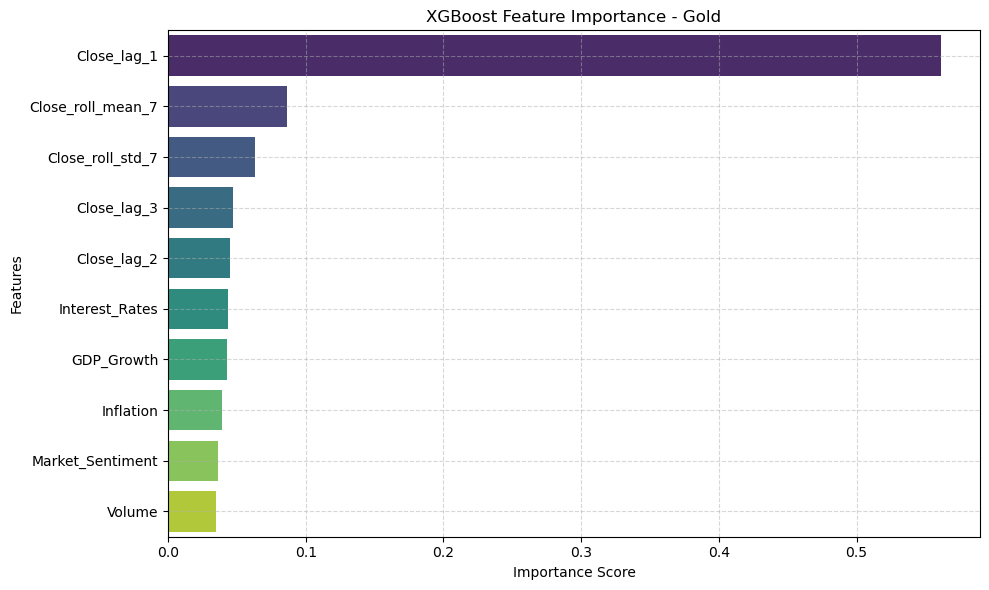

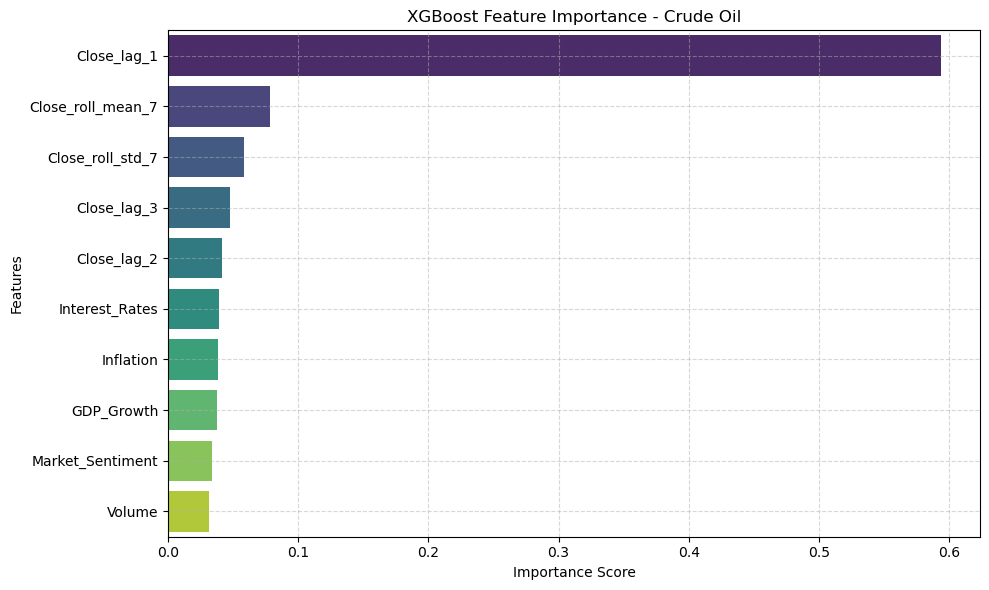

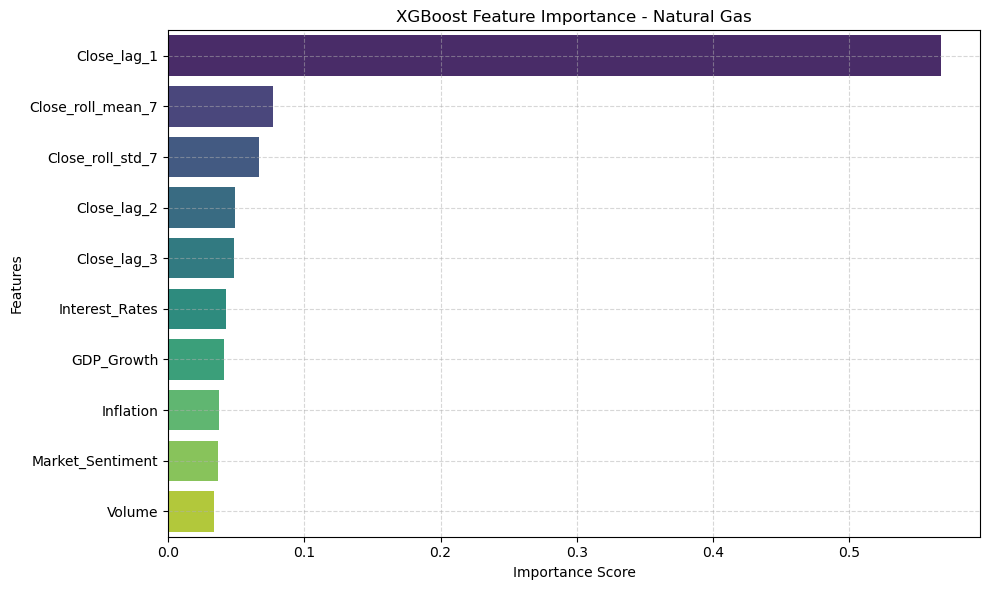

In [88]:
feature_importance = model_gold.feature_importances_
feature_names = model_gold.get_booster().feature_names

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('XGBoost Feature Importance - Gold')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


feature_importance = model_oil.feature_importances_
feature_names = model_oil.get_booster().feature_names

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('XGBoost Feature Importance - Crude Oil')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


feature_importance = model_gas.feature_importances_
feature_names = model_gas.get_booster().feature_names

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('XGBoost Feature Importance - Natural Gas')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- Close_lag_1 is by far the most important feature across all three commodities. This means the most recent previous close price strongly influences the model’s prediction.

- The rolling statistics (Close_roll_mean_7 and Close_roll_std_7) are consistently the next most important features, showing that short-term trends and volatility over a week matter.

- Lagged closes at 2 and 3 days (Close_lag_2 and Close_lag_3) also contribute but less than lag 1.

- Economic indicators like Interest Rates, GDP Growth, Inflation, and Market Sentiment have a smaller but still noticeable influence, indicating these macro factors help the model adjust predictions.

- Volume tends to have the least impact but still plays a minor role.

Overall, the model relies heavily on recent price history and short-term trends but also benefits from economic context for forecasting commodity prices.

### **Final Comparison of Models**

After testing three different models — SARIMAX, XGBoost, and LSTM — on the task of forecasting prices for gold, crude oil, and natural gas, it’s clear that not all models perform equally well. Each model has its strengths and weaknesses, but overall, one stands out as the most reliable.

SARIMAX consistently gave poor results for all three commodities. The predicted values were mostly flat and failed to follow the real ups and downs in prices. The R-squared values were even negative, meaning the model did worse than simply guessing the average price. While the residuals didn’t show serious autocorrelation problems, the model clearly couldn’t capture the true patterns in the data. This makes SARIMAX the weakest model in this comparison.

XGBoost was the best overall performer. It handled trends and price movements much better than SARIMAX or LSTM. The predictions followed the actual prices more closely, and the errors were smaller and more stable. The R-squared values were the highest among the three models, showing that XGBoost explained a larger portion of the price variation. After applying hyperparameter tuning, performance improved further for crude oil and natural gas, with smaller errors and better trend tracking, though gold saw a slight decline in accuracy. This suggests that while tuning refined XGBoost’s performance where price movements were less erratic, gold may require more targeted tuning or additional features. Overall, this model gave useful results for all three commodities and didn’t miss the big changes in price as much as the others.

LSTM showed mixed results. It performed well for crude oil, where it captured over half of the variance and had low error values. However, it struggled with gold and natural gas, giving large prediction errors and low R-squared values. While it could sometimes follow the trend, it wasn’t consistent and missed many sharp changes in prices.

In conclusion, among the three models, XGBoost is clearly the most effective and reliable choice for forecasting commodity prices. It outperforms SARIMAX and LSTM in both accuracy and stability, and it provides forecasts that are more in line with the actual price movements. While LSTM can be useful in some cases (like crude oil), it lacks the consistency that XGBoost provides across all commodities. SARIMAX, on the other hand, does not offer helpful predictions for this type of data and is not recommended.